<a href="https://colab.research.google.com/github/KyuhyoJeon/007022/blob/master/BYOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import argparse

# parser = argparse.ArgumentParser()
# parser.add_argument('--name', default='byol_cifar_experiment', 
#                     type=str, help='Project name')
# parser.add_argument('--transfrom', default='simclr_transform', 
#                     type=str, help='Data augment transform')
# # random patch, 224 resize, random hrizontal flip, color distortion, 
# # random swquence brightness, contrast, saturation, hue adjustment, 
# # and optional gray scale conversion, Gaussian blur, solarization
# parser.add_argument('--image_size', default=224, 
#                     type=int, help='Image size')
# parser.add_argument('--backbone_name', default='resnet50', 
#                     type=str, help='Network babone name')
# parser.add_argument('--optimizer_name', default='lars', 
#                     type=str, help='Parameters update optimizer name')
# parser.add_argument('--total_epochs', default=1000, 
#                     type=int, help='Total training epochs')
# parser.add_argument('--warmup_epochs', default=10, 
#                     type=int, help='Warm-up epochs')
# parser.add_argument('--base_lr', default=0.2, 
#                     type=float, help='Training base learning rate') # lr * batch_size / 256
# parser.add_argument('--weight_decay', default=1.5e-6, 
#                     type=float, help='A global weight decay')
# parser.add_argument('--momentum_tau', default=0.996, 
#                     type=float, help='Target network parameter update momentum rate')
# # momentum_tau.next = 1 - (1 - momentum_tau) * (cosine(pie * k / K) + 1) / 2, 
# # k = current training step, K = maximum training step
# # momentum_tau is increased to one during training
# parser.add_argument('--batch_size', default=4096, 
#                     type=int, help='Data batch size')
# parser.add_argument('--data_dir', default='./data',
#                     type=str, help='Dataset download directory')
# args = parser.parse_args()
project_name='byol_cifar_experiment'
transfrom='simclr_transform'
image_size=224
total_epochs=1000
warmup_epochs=10
base_lr=0.2 # Using lr * batch_size / 256
weight_decay=1.5e-6
base_tau=0.996
batch_size=4096
num_workers=8
checkpoint_epochs = 5
data_dir='./data'
ckpt_dir='./ckpt'

device='cuda'
train_knn_monitor = True
train_knn_interval = 5
train_knn_k = 200
hide_progress = True
eval_optim_name = 'sgd'
eval_optim_weight_decay = 0
eval_optim_momentum = 0.9
eval_warmup_lr = 0
eval_warmup_epochs = 0
eval_base_lr = 30
eval_final_lr = 0
eval_num_epochs = 30

mlp_hidden_size=4096
projection_size=256
base_target_ema=4e-3 # 1 - base_tau
optim_beta=0.9
optim_trust_coef=1e-3
optim_weight_decay=1.5e-6
optim_exclude_bias_from_adaption=True
bn_decay_rate=0.9
bn_eps=1e-5
seed=1337

imagenet_mean_std = [[0.485, 0.456, 0.406],[0.229, 0.224, 0.225]]

backbone_name='resnet50'
optim_name='lars' # adam/sgd/lars

dryrun = True

if dryrun:
  image_size=32
  total_epochs = 10
  batch_size = 256
  num_workers=0
  dryrun_subset_size = 100
  backbone_name = 'resnet18'

debug = False

if debug:
  image_size=32
  total_epochs = 1
  warmup_epochs = 1
  batch_size = 2
  num_workers = 0
  debug_subset_size = 8
  backbone_name = 'resnet18'

do_eval = True

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms

class simclr_transform:
  # augmentations: 
  # random patch, 224 resize, random hrizontal flip, color distortion, 
  # random swquence brightness, contrast, saturation, hue adjustment, 
  # and optional gray scale conversion, Gaussian blur, solarization
  def __init__(self, size, mean_std=imagenet_mean_std, s=1.0):
    self.transform = transforms.Compose(
        [
        transforms.RandomSizedCrop(size=size), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomApply(
            [transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply(
            [transforms.GaussianBlur(kernel_size=size//20*2+1, sigma=(0.1, 2.0))], p=0.5), 
        transforms.ToTensor(),
        transforms.Normalize(*mean_std)
        ]
    )
  def __call__(self, x):
    x1 = self.transform(x)
    x2 = self.transform(x)
    return x1, x2

cifar_train = datasets.CIFAR10(
    data_dir, 
    train=True, 
    transform=simclr_transform(image_size), 
    download=True
)

if debug:
  cifar_train = torch.utils.data.Subset(cifar_train, range(0, debug_subset_size))
  cifar_train.classes = cifar_train.dataset.classes
  cifar_train.targets = cifar_train.dataset.targets
# elif dryrun:
#   cifar_train = torch.utils.data.Subset(cifar_train, range(0, dryrun_subset_size))
#   cifar_train.classes = cifar_train.dataset.classes
#   cifar_train.targets = cifar_train.dataset.targets

train_loader = torch.utils.data.DataLoader(
    cifar_train, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers, 
    drop_last=True, 
    pin_memory=True
)

from PIL import Image

class Transform_single():
  def __init__(self, size, train, normalize=imagenet_mean_std):
    if train == True:
      self.transform = transforms.Compose(
          [transforms.RandomResizedCrop(size, scale=(0.08, 1.0), 
                                        ratio=(3.0/4.0,4.0/3.0), 
                                        interpolation=Image.BICUBIC
                                        ),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(*normalize)]
      )
    else:
      self.transform = transforms.Compose(
          [transforms.Resize(int(size*(8/7)), 
                             interpolation=Image.BICUBIC
                             ), # 224 -> 256 
           transforms.CenterCrop(size),
           transforms.ToTensor(),
           transforms.Normalize(*normalize)]
      )

  def __call__(self, x):
    return self.transform(x)

cifar_memory = datasets.CIFAR10(
    root=data_dir, 
    train=True, 
    download=False, 
    transform=Transform_single(size=image_size, train=False), 
    )
memory_loader = torch.utils.data.DataLoader(
    cifar_memory, 
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
    )

cifar_test = datasets.CIFAR10(
    root=data_dir, 
    train=False, 
    download=False, 
    transform=Transform_single(size=image_size, train=False), 
)
test_loader = torch.utils.data.DataLoader(
    cifar_test, 
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
    pin_memory=True,
)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:841: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


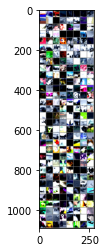

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


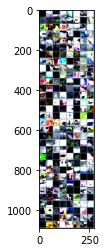

 ship truck horse  ship  bird   cat  bird horse  bird  frog  deer  frog horse truck airplane   cat  bird  deer  frog   dog truck airplane airplane  ship truck automobile truck airplane truck truck truck  bird   cat   cat  frog  bird horse horse  bird airplane horse  ship horse  bird horse  frog   cat  deer   cat  frog  deer horse automobile  frog airplane   cat truck horse   dog airplane  frog automobile  deer truck   dog  frog automobile  frog airplane   dog  frog   dog   cat  ship   dog  deer airplane  deer  ship   dog   dog  frog  frog  frog truck  bird airplane truck  deer airplane  ship truck  ship airplane  deer  bird horse truck   cat  ship  bird   dog   cat  frog  frog  bird   cat truck airplane airplane airplane airplane automobile   cat   cat  deer horse  ship   dog horse  ship truck  bird airplane   cat  bird  bird  bird  bird  deer  deer  bird  ship truck  ship  ship   cat  bird  deer airplane  bird   cat   cat  bird   dog  bird truck horse  ship  deer   cat airplane horse 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_loader)
(images1, images2), labels = dataiter.next()

imshow(torchvision.utils.make_grid(images1))
imshow(torchvision.utils.make_grid(images2))
print(' '.join('%5s' % train_loader.dataset.classes[labels[j]] for j in range(len(labels))))

In [ ]:
import torch.nn as nn
from torchvision import models

resnet = eval(f'models.{backbone_name}()')
# resnet = eval(f"{backbone_name}()")
resnet.output_dim = resnet.fc.in_features
resnet.fc = nn.Identity()

# if backbone_name == 'resnet18':
#   resnet = models.resnet18(pretrained=False)
# elif backbone_name == 'resnet50':
#   resnet = models.resnet50(pretrained=False)
# else:
#   raise NotImplementedError("Backbone is not implemented!")

In [ ]:
import copy
import math
from torch.nn import functional

class MLP(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    self.net = nn.Sequential(
        nn.Linear(input_dim, mlp_hidden_size), 
        nn.BatchNorm1d(mlp_hidden_size, momentum=1-bn_decay_rate, eps=bn_eps), 
        nn.ReLU(inplace=True), 
        nn.Linear(mlp_hidden_size, projection_size)
    )
  def forward(self, x):
    return self.net(x)

class BYOL(nn.Module):
  def __init__(self, backbone):
    super().__init__()

    self.backbone=backbone
    self.projector = MLP(resnet.output_dim)
    self.online_encoder = nn.Sequential(
        self.backbone, 
        self.projector,
    )
    self.predictor = MLP(projection_size)
    self.target_encoder = copy.deepcopy(self.online_encoder)

  def target_ema(self, k, K, base_tau=base_tau):
    return 1-(1-base_tau)*(math.cos(math.pi*k/K)+1)/2

  def reset_moving_average(self):
    del self.target_encoder
    self.target_encoder = copy.deepcopy(self.online_encoder)

  def update_moving_average(self, global_step, max_steps):
    tau = self.target_ema(global_step, max_steps)
    for online, target in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
      target.data = tau*target.data + (1-tau)*online.data
  
  def loss_function(self, p, z):
    p=functional.normalize(p, dim=-1, p=2)
    z=functional.normalize(z, dim=-1, p=2)
    return 2 - 2*(p*z).sum(dim=-1)

  def forward(self, x1, x2):
    z1_online, z2_online = self.online_encoder(x1), self.online_encoder(x2)
    p1_online, p2_online = self.predictor(z1_online), self.predictor(z2_online)
    with torch.no_grad():
      z1_target, z2_target = self.target_encoder(x1), self.target_encoder(x2)
    
    loss1, loss2 = self.loss_function(p1_online, z2_target.detach()), self.loss_function(p2_online, z1_target.detach())

    loss = loss1+loss2
    return loss.mean()

In [ ]:
byol = BYOL(resnet)
byol = byol.cuda('cuda')

In [ ]:
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer

class LARS(Optimizer):
  def __init__(self, 
                named_modules, 
                lr,
                momentum=0.9, # beta? YES
                trust_coef=1e-3,
                weight_decay=1.5e-6,
              exclude_bias_from_adaption=True):
    defaults = dict(momentum=momentum,
            lr=lr,
            weight_decay=weight_decay,
              trust_coef=trust_coef)
    parameters = self.exclude_from_model(named_modules, exclude_bias_from_adaption)
    super(LARS, self).__init__(parameters, defaults)

  @torch.no_grad() 
  def step(self):
    for group in self.param_groups: # only 1 group in most cases 
      weight_decay = group['weight_decay']
      momentum = group['momentum']
      lr = group['lr']

      trust_coef = group['trust_coef']
      # print(group['name'])
      # eps = group['eps']
      for p in group['params']:
        # breakpoint()
        if p.grad is None:
          continue
        global_lr = lr
        velocity = self.state[p].get('velocity', 0)  
        # if name in self.exclude_from_layer_adaptation:
        if self._use_weight_decay(group):
          p.grad.data += weight_decay * p.data 

        trust_ratio = 1.0 
        if self._do_layer_adaptation(group):
          w_norm = torch.norm(p.data, p=2)
          g_norm = torch.norm(p.grad.data, p=2)
          trust_ratio = trust_coef * w_norm / g_norm if w_norm > 0 and g_norm > 0 else 1.0 
        scaled_lr = global_lr * trust_ratio # trust_ratio is the local_lr 
        next_v = momentum * velocity + scaled_lr * p.grad.data 
        update = next_v
        p.data = p.data - update 


  def _use_weight_decay(self, group):
    return False if group['name'] == 'exclude' else True
  def _do_layer_adaptation(self, group):
    return False if group['name'] == 'exclude' else True

  def exclude_from_model(self, named_modules, exclude_bias_from_adaption=True):
    base = [] 
    exclude = []
    for name, module in named_modules:
      if type(module) in [nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d]:
        # if isinstance(module, torch.nn.modules.batchnorm._BatchNorm)
        for name2, param in module.named_parameters():
          exclude.append(param)
      else:
        for name2, param in module.named_parameters():
          if name2 == 'bias':
            exclude.append(param)
          elif name2 == 'weight':
            base.append(param)
          else:
            pass # non leaf modules 
    return [{
        'name': 'base',
        'params': base
        },{
        'name': 'exclude',
        'params': exclude
    }] if exclude_bias_from_adaption == True else [{
        'name': 'base',
        'params': base+exclude 
    }]

LARS optimizer is from Github PatrickHua/SimSiam


> Link: https://github.com/PatrickHua/SimSiam/blob/main/optimizers/lars_simclr.py



In [ ]:
predictor_prefix = ('module.predictor', 'predictor')
parameters = [{
    'name': 'base',
    'params': [param for name, param in byol.named_parameters() if not name.startswith(predictor_prefix)],
    'lr': base_lr
},{
    'name': 'predictor',
    'params': [param for name, param in byol.named_parameters() if name.startswith(predictor_prefix)],
    'lr': base_lr
}]
if optim_name == 'lars':
  optimizer = LARS(byol.named_modules(), lr=base_lr*batch_size/256, weight_decay=weight_decay)
elif optim_name == 'adam':
  optimizer = Adam(parameters, lr=base_lr*batch_size/256)
elif optim_name == 'sgd':
  optimizer = SGD(parameters, lr=base_lr*batch_size/256, momentum=0.9)
else: # default is LARS
  optimizer = LARS(byol.named_modules(), lr=base_lr*batch_size/256, weight_decay=weight_decay)

In [ ]:
class LR_Scheduler(object):
  def __init__(self, optimizer, warmup_epochs, warmup_lr, num_epochs, base_lr, final_lr, iter_per_epoch, constant_predictor_lr=False):
    self.base_lr = base_lr
    self.constant_predictor_lr = constant_predictor_lr
    warmup_iter = iter_per_epoch * warmup_epochs
    warmup_lr_schedule = np.linspace(warmup_lr, base_lr, warmup_iter)
    decay_iter = iter_per_epoch * (num_epochs - warmup_epochs)
    cosine_lr_schedule = final_lr+0.5*(base_lr-final_lr)*(1+np.cos(np.pi*np.arange(decay_iter)/decay_iter))
    
    self.lr_schedule = np.concatenate((warmup_lr_schedule, cosine_lr_schedule))
    self.optimizer = optimizer
    self.iter = 0
    self.current_lr = 0
  def step(self):
    for param_group in self.optimizer.param_groups:

      if self.constant_predictor_lr and param_group['name'] == 'predictor':
        param_group['lr'] = self.base_lr
      else:
        lr = param_group['lr'] = self.lr_schedule[self.iter]
    
    self.iter += 1
    self.current_lr = lr
    return lr
  def get_lr(self):
    return self.current_lr

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F 
# code copied from https://colab.research.google.com/github/facebookresearch/moco/blob/colab-notebook/colab/moco_cifar10_demo.ipynb#scrollTo=RI1Y8bSImD7N
# test using a knn monitor
def knn_monitor(net, memory_data_loader, test_data_loader, k=200, t=0.1, hide_progress=False):
  net.eval()
  classes = len(memory_data_loader.dataset.classes)
  total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
  with torch.no_grad():
    # generate feature bank
    for data, target in tqdm(memory_data_loader, desc='Feature extracting', leave=False, disable=hide_progress):
      feature = net(data.cuda(non_blocking=True))
      feature = F.normalize(feature, dim=1)
      feature_bank.append(feature)
    # [D, N]
    feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
    # [N]
    feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
    # loop test data to predict the label by weighted knn search
    test_bar = tqdm(test_data_loader, desc='kNN', disable=hide_progress)
    for data, target in test_bar:
      data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
      feature = net(data)
      feature = F.normalize(feature, dim=1)
      
      pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, k, t)

      total_num += data.size(0)
      total_top1 += (pred_labels[:, 0] == target).float().sum().item()
      test_bar.set_postfix({'Accuracy':total_top1 / total_num * 100})
  return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
  # compute cos similarity between each feature vector and feature bank ---> [B, N]
  sim_matrix = torch.mm(feature, feature_bank)
  # [B, K]
  sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
  # [B, K]
  sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
  sim_weight = (sim_weight / knn_t).exp()

  # counts for each class
  one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
  # [B*K, C]
  one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
  # weighted score ---> [B, C]
  pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

  pred_labels = pred_scores.argsort(dim=-1, descending=True)
  return pred_labels

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict
from datetime import datetime
import os

if not os.path.exists(ckpt_dir):
  os.makedirs(ckpt_dir)

tmp_dir = os.path.join(ckpt_dir, f"{backbone_name}")
if not os.path.exists(tmp_dir):
  os.makedirs(tmp_dir)
tmp_dir = os.path.join(tmp_dir, f"{optim_name}")
if not os.path.exists(tmp_dir):
  os.makedirs(tmp_dir)
tmp_dir = os.path.join(tmp_dir, f"{datetime.now().strftime('%m%d%H')}")
if not os.path.exists(tmp_dir):
  os.makedirs(tmp_dir)

writer = SummaryWriter()

global_step = 0
for epoch in tqdm(range(0, total_epochs), desc=f'Training'):
  metrics = defaultdict(list)
  
  for step, ((x1, x2), labels) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch}/{total_epochs}')):
    x1, x2 = x1.cuda(non_blocking=True), x2.cuda(non_blocking=True)

    main_loss = byol(x1, x2)
    optimizer.zero_grad()
    main_loss.backward()
    optimizer.step()
    byol.update_moving_average(epoch, total_epochs)

    if step%1 == 0:
      print(f'Step [{step}/{len(train_loader)}]:\tLoss: {main_loss.item()}')
    
    writer.add_scalar("Loss/train_step", main_loss, global_step)
    metrics["Loss/train"].append(main_loss.item())
    global_step += 1
  
  for k, v in metrics.items():
    writer.add_scalar(k, np.array(v).mean(), epoch)

  if train_knn_monitor and epoch % train_knn_interval == 0: 
    main_accuracy = knn_monitor(byol.backbone, memory_loader, test_loader, k=min(train_knn_k, len(memory_loader.dataset)), hide_progress=hide_progress) 
  print(f'Training: {epoch}/{total_epochs} Accuracy: {main_accuracy}')

  if epoch%checkpoint_epochs == 0:
    ckpt_path = os.path.join(tmp_dir, f"{project_name}_{optim_name}_{epoch}.pt")
    print(f'Saving model at epoch {epoch}')
    torch.save(resnet.state_dict(), ckpt_path)

ckpt_path = os.path.join(tmp_dir, f"{project_name}_{optim_name}_final.pt")
print(f'Saving final model')
torch.save(resnet.state_dict(), ckpt_path)



Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 0/10:   0%|          | 0/195 [00:00<?, ?it/s]


Epoch 0/10:   1%|          | 1/195 [00:00<03:07,  1.03it/s]

Step [0/195]:	Loss: 3.9819445610046387





Epoch 0/10:   1%|          | 2/195 [00:01<03:01,  1.06it/s]

Step [1/195]:	Loss: 3.886075496673584





Epoch 0/10:   2%|▏         | 3/195 [00:02<02:55,  1.09it/s]

Step [2/195]:	Loss: 3.820904016494751





Epoch 0/10:   2%|▏         | 4/195 [00:03<02:52,  1.10it/s]

Step [3/195]:	Loss: 3.7674601078033447





Epoch 0/10:   3%|▎         | 5/195 [00:04<02:49,  1.12it/s]

Step [4/195]:	Loss: 3.7017972469329834





Epoch 0/10:   3%|▎         | 6/195 [00:05<02:47,  1.13it/s]

Step [5/195]:	Loss: 3.6077022552490234





Epoch 0/10:   4%|▎         | 7/195 [00:06<02:45,  1.14it/s]

Step [6/195]:	Loss: 3.5489752292633057





Epoch 0/10:   4%|▍         | 8/195 [00:07<02:44,  1.14it/s]

Step [7/195]:	Loss: 3.482076644897461





Epoch 0/10:   5%|▍         | 9/195 [00:07<02:42,  1.14it/s]

Step [8/195]:	Loss: 3.3969197273254395





Epoch 0/10:   5%|▌         | 10/195 [00:08<02:41,  1.15it/s]

Step [9/195]:	Loss: 3.3722622394561768





Epoch 0/10:   6%|▌         | 11/195 [00:09<02:39,  1.15it/s]

Step [10/195]:	Loss: 3.2888717651367188





Epoch 0/10:   6%|▌         | 12/195 [00:10<02:38,  1.15it/s]

Step [11/195]:	Loss: 3.2385222911834717





Epoch 0/10:   7%|▋         | 13/195 [00:11<02:37,  1.15it/s]

Step [12/195]:	Loss: 3.1731247901916504





Epoch 0/10:   7%|▋         | 14/195 [00:12<02:36,  1.16it/s]

Step [13/195]:	Loss: 3.1131160259246826





Epoch 0/10:   8%|▊         | 15/195 [00:13<02:35,  1.16it/s]

Step [14/195]:	Loss: 3.0420355796813965





Epoch 0/10:   8%|▊         | 16/195 [00:13<02:34,  1.16it/s]

Step [15/195]:	Loss: 3.0075058937072754





Epoch 0/10:   9%|▊         | 17/195 [00:14<02:34,  1.15it/s]

Step [16/195]:	Loss: 2.966094970703125





Epoch 0/10:   9%|▉         | 18/195 [00:15<02:33,  1.15it/s]

Step [17/195]:	Loss: 2.9318628311157227





Epoch 0/10:  10%|▉         | 19/195 [00:16<02:33,  1.15it/s]

Step [18/195]:	Loss: 2.8199825286865234





Epoch 0/10:  10%|█         | 20/195 [00:17<02:32,  1.14it/s]

Step [19/195]:	Loss: 2.794111490249634





Epoch 0/10:  11%|█         | 21/195 [00:18<02:32,  1.14it/s]

Step [20/195]:	Loss: 2.7692346572875977





Epoch 0/10:  11%|█▏        | 22/195 [00:19<02:31,  1.14it/s]

Step [21/195]:	Loss: 2.6895852088928223





Epoch 0/10:  12%|█▏        | 23/195 [00:20<02:30,  1.15it/s]

Step [22/195]:	Loss: 2.6699905395507812





Epoch 0/10:  12%|█▏        | 24/195 [00:20<02:27,  1.16it/s]

Step [23/195]:	Loss: 2.653991222381592





Epoch 0/10:  13%|█▎        | 25/195 [00:21<02:26,  1.16it/s]

Step [24/195]:	Loss: 2.608703374862671





Epoch 0/10:  13%|█▎        | 26/195 [00:22<02:26,  1.15it/s]

Step [25/195]:	Loss: 2.531337261199951





Epoch 0/10:  14%|█▍        | 27/195 [00:23<02:29,  1.13it/s]

Step [26/195]:	Loss: 2.5146355628967285





Epoch 0/10:  14%|█▍        | 28/195 [00:24<02:29,  1.12it/s]

Step [27/195]:	Loss: 2.4939703941345215





Epoch 0/10:  15%|█▍        | 29/195 [00:25<02:27,  1.13it/s]

Step [28/195]:	Loss: 2.4639148712158203





Epoch 0/10:  15%|█▌        | 30/195 [00:26<02:25,  1.13it/s]

Step [29/195]:	Loss: 2.434114456176758





Epoch 0/10:  16%|█▌        | 31/195 [00:27<02:24,  1.13it/s]

Step [30/195]:	Loss: 2.3744726181030273





Epoch 0/10:  16%|█▋        | 32/195 [00:28<02:25,  1.12it/s]

Step [31/195]:	Loss: 2.3669934272766113





Epoch 0/10:  17%|█▋        | 33/195 [00:28<02:23,  1.13it/s]

Step [32/195]:	Loss: 2.3629112243652344





Epoch 0/10:  17%|█▋        | 34/195 [00:29<02:22,  1.13it/s]

Step [33/195]:	Loss: 2.3573899269104004





Epoch 0/10:  18%|█▊        | 35/195 [00:30<02:21,  1.13it/s]

Step [34/195]:	Loss: 2.3276610374450684





Epoch 0/10:  18%|█▊        | 36/195 [00:31<02:20,  1.13it/s]

Step [35/195]:	Loss: 2.2732691764831543





Epoch 0/10:  19%|█▉        | 37/195 [00:32<02:19,  1.13it/s]

Step [36/195]:	Loss: 2.2711029052734375





Epoch 0/10:  19%|█▉        | 38/195 [00:33<02:17,  1.14it/s]

Step [37/195]:	Loss: 2.2573184967041016





Epoch 0/10:  20%|██        | 39/195 [00:34<02:16,  1.14it/s]

Step [38/195]:	Loss: 2.221836805343628





Epoch 0/10:  21%|██        | 40/195 [00:35<02:16,  1.14it/s]

Step [39/195]:	Loss: 2.219435691833496





Epoch 0/10:  21%|██        | 41/195 [00:35<02:14,  1.14it/s]

Step [40/195]:	Loss: 2.2239694595336914





Epoch 0/10:  22%|██▏       | 42/195 [00:36<02:12,  1.15it/s]

Step [41/195]:	Loss: 2.197706937789917





Epoch 0/10:  22%|██▏       | 43/195 [00:37<02:10,  1.16it/s]

Step [42/195]:	Loss: 2.174504518508911





Epoch 0/10:  23%|██▎       | 44/195 [00:38<02:10,  1.16it/s]

Step [43/195]:	Loss: 2.147871494293213





Epoch 0/10:  23%|██▎       | 45/195 [00:39<02:10,  1.15it/s]

Step [44/195]:	Loss: 2.1462724208831787





Epoch 0/10:  24%|██▎       | 46/195 [00:40<02:09,  1.15it/s]

Step [45/195]:	Loss: 2.119389057159424





Epoch 0/10:  24%|██▍       | 47/195 [00:41<02:08,  1.15it/s]

Step [46/195]:	Loss: 2.125645875930786





Epoch 0/10:  25%|██▍       | 48/195 [00:42<02:08,  1.15it/s]

Step [47/195]:	Loss: 2.0754342079162598





Epoch 0/10:  25%|██▌       | 49/195 [00:42<02:08,  1.14it/s]

Step [48/195]:	Loss: 2.0639777183532715





Epoch 0/10:  26%|██▌       | 50/195 [00:43<02:07,  1.14it/s]

Step [49/195]:	Loss: 2.0739293098449707





Epoch 0/10:  26%|██▌       | 51/195 [00:44<02:06,  1.14it/s]

Step [50/195]:	Loss: 2.049398899078369





Epoch 0/10:  27%|██▋       | 52/195 [00:45<02:05,  1.14it/s]

Step [51/195]:	Loss: 2.034257411956787





Epoch 0/10:  27%|██▋       | 53/195 [00:46<02:04,  1.14it/s]

Step [52/195]:	Loss: 2.0056819915771484





Epoch 0/10:  28%|██▊       | 54/195 [00:47<02:03,  1.14it/s]

Step [53/195]:	Loss: 2.0139827728271484





Epoch 0/10:  28%|██▊       | 55/195 [00:48<02:03,  1.14it/s]

Step [54/195]:	Loss: 1.9870195388793945





Epoch 0/10:  29%|██▊       | 56/195 [00:49<02:02,  1.14it/s]

Step [55/195]:	Loss: 2.0142078399658203





Epoch 0/10:  29%|██▉       | 57/195 [00:49<02:01,  1.14it/s]

Step [56/195]:	Loss: 1.985202670097351





Epoch 0/10:  30%|██▉       | 58/195 [00:50<02:00,  1.14it/s]

Step [57/195]:	Loss: 2.002678394317627





Epoch 0/10:  30%|███       | 59/195 [00:51<01:59,  1.14it/s]

Step [58/195]:	Loss: 1.9713373184204102





Epoch 0/10:  31%|███       | 60/195 [00:52<01:57,  1.15it/s]

Step [59/195]:	Loss: 1.9256141185760498





Epoch 0/10:  31%|███▏      | 61/195 [00:53<01:56,  1.15it/s]

Step [60/195]:	Loss: 1.9247511625289917





Epoch 0/10:  32%|███▏      | 62/195 [00:54<01:56,  1.15it/s]

Step [61/195]:	Loss: 1.91438627243042





Epoch 0/10:  32%|███▏      | 63/195 [00:55<01:56,  1.14it/s]

Step [62/195]:	Loss: 1.9161875247955322





Epoch 0/10:  33%|███▎      | 64/195 [00:56<01:56,  1.12it/s]

Step [63/195]:	Loss: 1.9196834564208984





Epoch 0/10:  33%|███▎      | 65/195 [00:57<01:55,  1.12it/s]

Step [64/195]:	Loss: 1.9171682596206665





Epoch 0/10:  34%|███▍      | 66/195 [00:57<01:55,  1.12it/s]

Step [65/195]:	Loss: 1.8872816562652588





Epoch 0/10:  34%|███▍      | 67/195 [00:58<01:54,  1.12it/s]

Step [66/195]:	Loss: 1.935808539390564





Epoch 0/10:  35%|███▍      | 68/195 [00:59<01:53,  1.12it/s]

Step [67/195]:	Loss: 1.8906066417694092





Epoch 0/10:  35%|███▌      | 69/195 [01:00<01:54,  1.10it/s]

Step [68/195]:	Loss: 1.8856775760650635





Epoch 0/10:  36%|███▌      | 70/195 [01:01<01:52,  1.11it/s]

Step [69/195]:	Loss: 1.8765844106674194





Epoch 0/10:  36%|███▋      | 71/195 [01:02<01:51,  1.11it/s]

Step [70/195]:	Loss: 1.878161907196045





Epoch 0/10:  37%|███▋      | 72/195 [01:03<01:50,  1.11it/s]

Step [71/195]:	Loss: 1.877892255783081





Epoch 0/10:  37%|███▋      | 73/195 [01:04<01:49,  1.12it/s]

Step [72/195]:	Loss: 1.8708537817001343





Epoch 0/10:  38%|███▊      | 74/195 [01:05<01:47,  1.13it/s]

Step [73/195]:	Loss: 1.864512324333191





Epoch 0/10:  38%|███▊      | 75/195 [01:05<01:46,  1.12it/s]

Step [74/195]:	Loss: 1.8382952213287354





Epoch 0/10:  39%|███▉      | 76/195 [01:06<01:46,  1.12it/s]

Step [75/195]:	Loss: 1.8318922519683838





Epoch 0/10:  39%|███▉      | 77/195 [01:07<01:43,  1.14it/s]

Step [76/195]:	Loss: 1.8494374752044678





Epoch 0/10:  40%|████      | 78/195 [01:08<01:43,  1.13it/s]

Step [77/195]:	Loss: 1.8501806259155273





Epoch 0/10:  41%|████      | 79/195 [01:09<01:42,  1.13it/s]

Step [78/195]:	Loss: 1.8209419250488281





Epoch 0/10:  41%|████      | 80/195 [01:10<01:41,  1.13it/s]

Step [79/195]:	Loss: 1.8131518363952637





Epoch 0/10:  42%|████▏     | 81/195 [01:11<01:41,  1.13it/s]

Step [80/195]:	Loss: 1.8052728176116943





Epoch 0/10:  42%|████▏     | 82/195 [01:12<01:39,  1.13it/s]

Step [81/195]:	Loss: 1.8085482120513916





Epoch 0/10:  43%|████▎     | 83/195 [01:13<01:38,  1.14it/s]

Step [82/195]:	Loss: 1.8176159858703613





Epoch 0/10:  43%|████▎     | 84/195 [01:13<01:37,  1.14it/s]

Step [83/195]:	Loss: 1.810161828994751





Epoch 0/10:  44%|████▎     | 85/195 [01:14<01:36,  1.14it/s]

Step [84/195]:	Loss: 1.789562702178955





Epoch 0/10:  44%|████▍     | 86/195 [01:15<01:35,  1.14it/s]

Step [85/195]:	Loss: 1.7946052551269531





Epoch 0/10:  45%|████▍     | 87/195 [01:16<01:34,  1.14it/s]

Step [86/195]:	Loss: 1.8048028945922852





Epoch 0/10:  45%|████▌     | 88/195 [01:17<01:32,  1.15it/s]

Step [87/195]:	Loss: 1.7745046615600586





Epoch 0/10:  46%|████▌     | 89/195 [01:18<01:32,  1.15it/s]

Step [88/195]:	Loss: 1.7850384712219238





Epoch 0/10:  46%|████▌     | 90/195 [01:19<01:31,  1.15it/s]

Step [89/195]:	Loss: 1.7625465393066406





Epoch 0/10:  47%|████▋     | 91/195 [01:19<01:30,  1.15it/s]

Step [90/195]:	Loss: 1.7556397914886475





Epoch 0/10:  47%|████▋     | 92/195 [01:20<01:30,  1.14it/s]

Step [91/195]:	Loss: 1.771618127822876





Epoch 0/10:  48%|████▊     | 93/195 [01:21<01:29,  1.15it/s]

Step [92/195]:	Loss: 1.7582224607467651





Epoch 0/10:  48%|████▊     | 94/195 [01:22<01:28,  1.14it/s]

Step [93/195]:	Loss: 1.7636921405792236





Epoch 0/10:  49%|████▊     | 95/195 [01:23<01:28,  1.13it/s]

Step [94/195]:	Loss: 1.7582030296325684





Epoch 0/10:  49%|████▉     | 96/195 [01:24<01:28,  1.12it/s]

Step [95/195]:	Loss: 1.748345971107483





Epoch 0/10:  50%|████▉     | 97/195 [01:25<01:26,  1.13it/s]

Step [96/195]:	Loss: 1.7534793615341187





Epoch 0/10:  50%|█████     | 98/195 [01:26<01:25,  1.13it/s]

Step [97/195]:	Loss: 1.7269599437713623





Epoch 0/10:  51%|█████     | 99/195 [01:27<01:24,  1.14it/s]

Step [98/195]:	Loss: 1.7231535911560059





Epoch 0/10:  51%|█████▏    | 100/195 [01:27<01:22,  1.15it/s]

Step [99/195]:	Loss: 1.7227593660354614





Epoch 0/10:  52%|█████▏    | 101/195 [01:28<01:22,  1.14it/s]

Step [100/195]:	Loss: 1.733933925628662





Epoch 0/10:  52%|█████▏    | 102/195 [01:29<01:21,  1.14it/s]

Step [101/195]:	Loss: 1.7257723808288574





Epoch 0/10:  53%|█████▎    | 103/195 [01:30<01:20,  1.14it/s]

Step [102/195]:	Loss: 1.7338553667068481





Epoch 0/10:  53%|█████▎    | 104/195 [01:31<01:19,  1.14it/s]

Step [103/195]:	Loss: 1.722735047340393





Epoch 0/10:  54%|█████▍    | 105/195 [01:32<01:18,  1.14it/s]

Step [104/195]:	Loss: 1.7143914699554443





Epoch 0/10:  54%|█████▍    | 106/195 [01:33<01:17,  1.14it/s]

Step [105/195]:	Loss: 1.7131785154342651





Epoch 0/10:  55%|█████▍    | 107/195 [01:34<01:18,  1.13it/s]

Step [106/195]:	Loss: 1.7197353839874268





Epoch 0/10:  55%|█████▌    | 108/195 [01:34<01:16,  1.13it/s]

Step [107/195]:	Loss: 1.714562177658081





Epoch 0/10:  56%|█████▌    | 109/195 [01:35<01:15,  1.14it/s]

Step [108/195]:	Loss: 1.7201659679412842





Epoch 0/10:  56%|█████▋    | 110/195 [01:36<01:14,  1.14it/s]

Step [109/195]:	Loss: 1.7148545980453491





Epoch 0/10:  57%|█████▋    | 111/195 [01:37<01:13,  1.14it/s]

Step [110/195]:	Loss: 1.7035260200500488





Epoch 0/10:  57%|█████▋    | 112/195 [01:38<01:13,  1.13it/s]

Step [111/195]:	Loss: 1.691643238067627





Epoch 0/10:  58%|█████▊    | 113/195 [01:39<01:12,  1.13it/s]

Step [112/195]:	Loss: 1.6867473125457764





Epoch 0/10:  58%|█████▊    | 114/195 [01:40<01:11,  1.13it/s]

Step [113/195]:	Loss: 1.7006889581680298





Epoch 0/10:  59%|█████▉    | 115/195 [01:41<01:10,  1.13it/s]

Step [114/195]:	Loss: 1.6846948862075806





Epoch 0/10:  59%|█████▉    | 116/195 [01:42<01:09,  1.14it/s]

Step [115/195]:	Loss: 1.6790494918823242





Epoch 0/10:  60%|██████    | 117/195 [01:42<01:08,  1.14it/s]

Step [116/195]:	Loss: 1.673548936843872





Epoch 0/10:  61%|██████    | 118/195 [01:43<01:07,  1.14it/s]

Step [117/195]:	Loss: 1.67461359500885





Epoch 0/10:  61%|██████    | 119/195 [01:44<01:06,  1.14it/s]

Step [118/195]:	Loss: 1.6843390464782715





Epoch 0/10:  62%|██████▏   | 120/195 [01:45<01:05,  1.14it/s]

Step [119/195]:	Loss: 1.6768330335617065





Epoch 0/10:  62%|██████▏   | 121/195 [01:46<01:04,  1.14it/s]

Step [120/195]:	Loss: 1.6803861856460571





Epoch 0/10:  63%|██████▎   | 122/195 [01:47<01:03,  1.14it/s]

Step [121/195]:	Loss: 1.6677137613296509





Epoch 0/10:  63%|██████▎   | 123/195 [01:48<01:02,  1.15it/s]

Step [122/195]:	Loss: 1.6568796634674072





Epoch 0/10:  64%|██████▎   | 124/195 [01:48<01:01,  1.16it/s]

Step [123/195]:	Loss: 1.654900074005127





Epoch 0/10:  64%|██████▍   | 125/195 [01:49<01:00,  1.16it/s]

Step [124/195]:	Loss: 1.670996904373169





Epoch 0/10:  65%|██████▍   | 126/195 [01:50<00:59,  1.16it/s]

Step [125/195]:	Loss: 1.6588151454925537





Epoch 0/10:  65%|██████▌   | 127/195 [01:51<00:58,  1.16it/s]

Step [126/195]:	Loss: 1.6524512767791748





Epoch 0/10:  66%|██████▌   | 128/195 [01:52<00:58,  1.15it/s]

Step [127/195]:	Loss: 1.6502270698547363





Epoch 0/10:  66%|██████▌   | 129/195 [01:53<00:58,  1.13it/s]

Step [128/195]:	Loss: 1.6459873914718628





Epoch 0/10:  67%|██████▋   | 130/195 [01:54<00:57,  1.14it/s]

Step [129/195]:	Loss: 1.6593174934387207





Epoch 0/10:  67%|██████▋   | 131/195 [01:55<00:55,  1.15it/s]

Step [130/195]:	Loss: 1.6431448459625244





Epoch 0/10:  68%|██████▊   | 132/195 [01:55<00:55,  1.14it/s]

Step [131/195]:	Loss: 1.646907091140747





Epoch 0/10:  68%|██████▊   | 133/195 [01:56<00:54,  1.14it/s]

Step [132/195]:	Loss: 1.6411954164505005





Epoch 0/10:  69%|██████▊   | 134/195 [01:57<00:53,  1.14it/s]

Step [133/195]:	Loss: 1.6723936796188354





Epoch 0/10:  69%|██████▉   | 135/195 [01:58<00:53,  1.13it/s]

Step [134/195]:	Loss: 1.637633204460144





Epoch 0/10:  70%|██████▉   | 136/195 [01:59<00:52,  1.13it/s]

Step [135/195]:	Loss: 1.6389687061309814





Epoch 0/10:  70%|███████   | 137/195 [02:00<00:51,  1.14it/s]

Step [136/195]:	Loss: 1.6336512565612793





Epoch 0/10:  71%|███████   | 138/195 [02:01<00:50,  1.12it/s]

Step [137/195]:	Loss: 1.5987956523895264





Epoch 0/10:  71%|███████▏  | 139/195 [02:02<00:49,  1.13it/s]

Step [138/195]:	Loss: 1.6248555183410645





Epoch 0/10:  72%|███████▏  | 140/195 [02:03<00:48,  1.13it/s]

Step [139/195]:	Loss: 1.6533639430999756





Epoch 0/10:  72%|███████▏  | 141/195 [02:03<00:47,  1.14it/s]

Step [140/195]:	Loss: 1.6518409252166748





Epoch 0/10:  73%|███████▎  | 142/195 [02:04<00:46,  1.14it/s]

Step [141/195]:	Loss: 1.6363708972930908





Epoch 0/10:  73%|███████▎  | 143/195 [02:05<00:45,  1.15it/s]

Step [142/195]:	Loss: 1.6354460716247559





Epoch 0/10:  74%|███████▍  | 144/195 [02:06<00:45,  1.13it/s]

Step [143/195]:	Loss: 1.6425485610961914





Epoch 0/10:  74%|███████▍  | 145/195 [02:07<00:44,  1.13it/s]

Step [144/195]:	Loss: 1.6095786094665527





Epoch 0/10:  75%|███████▍  | 146/195 [02:08<00:43,  1.14it/s]

Step [145/195]:	Loss: 1.643496036529541





Epoch 0/10:  75%|███████▌  | 147/195 [02:09<00:42,  1.14it/s]

Step [146/195]:	Loss: 1.6302406787872314





Epoch 0/10:  76%|███████▌  | 148/195 [02:10<00:41,  1.13it/s]

Step [147/195]:	Loss: 1.6168243885040283





Epoch 0/10:  76%|███████▋  | 149/195 [02:10<00:40,  1.13it/s]

Step [148/195]:	Loss: 1.6332197189331055





Epoch 0/10:  77%|███████▋  | 150/195 [02:11<00:39,  1.13it/s]

Step [149/195]:	Loss: 1.6204197406768799





Epoch 0/10:  77%|███████▋  | 151/195 [02:12<00:38,  1.13it/s]

Step [150/195]:	Loss: 1.622436285018921





Epoch 0/10:  78%|███████▊  | 152/195 [02:13<00:37,  1.13it/s]

Step [151/195]:	Loss: 1.630731463432312





Epoch 0/10:  78%|███████▊  | 153/195 [02:14<00:36,  1.14it/s]

Step [152/195]:	Loss: 1.6262688636779785





Epoch 0/10:  79%|███████▉  | 154/195 [02:15<00:36,  1.14it/s]

Step [153/195]:	Loss: 1.618138074874878





Epoch 0/10:  79%|███████▉  | 155/195 [02:16<00:35,  1.13it/s]

Step [154/195]:	Loss: 1.6019490957260132





Epoch 0/10:  80%|████████  | 156/195 [02:17<00:34,  1.13it/s]

Step [155/195]:	Loss: 1.604825496673584





Epoch 0/10:  81%|████████  | 157/195 [02:18<00:33,  1.13it/s]

Step [156/195]:	Loss: 1.6036405563354492





Epoch 0/10:  81%|████████  | 158/195 [02:18<00:32,  1.13it/s]

Step [157/195]:	Loss: 1.624136209487915





Epoch 0/10:  82%|████████▏ | 159/195 [02:19<00:32,  1.12it/s]

Step [158/195]:	Loss: 1.6105202436447144





Epoch 0/10:  82%|████████▏ | 160/195 [02:20<00:31,  1.13it/s]

Step [159/195]:	Loss: 1.5963554382324219





Epoch 0/10:  83%|████████▎ | 161/195 [02:21<00:30,  1.12it/s]

Step [160/195]:	Loss: 1.5856311321258545





Epoch 0/10:  83%|████████▎ | 162/195 [02:22<00:29,  1.12it/s]

Step [161/195]:	Loss: 1.5985808372497559





Epoch 0/10:  84%|████████▎ | 163/195 [02:23<00:28,  1.11it/s]

Step [162/195]:	Loss: 1.585953950881958





Epoch 0/10:  84%|████████▍ | 164/195 [02:24<00:27,  1.11it/s]

Step [163/195]:	Loss: 1.5845472812652588





Epoch 0/10:  85%|████████▍ | 165/195 [02:25<00:26,  1.12it/s]

Step [164/195]:	Loss: 1.5778155326843262





Epoch 0/10:  85%|████████▌ | 166/195 [02:26<00:25,  1.12it/s]

Step [165/195]:	Loss: 1.5954316854476929





Epoch 0/10:  86%|████████▌ | 167/195 [02:26<00:24,  1.13it/s]

Step [166/195]:	Loss: 1.5855395793914795





Epoch 0/10:  86%|████████▌ | 168/195 [02:27<00:23,  1.13it/s]

Step [167/195]:	Loss: 1.6108171939849854





Epoch 0/10:  87%|████████▋ | 169/195 [02:28<00:22,  1.13it/s]

Step [168/195]:	Loss: 1.6199920177459717





Epoch 0/10:  87%|████████▋ | 170/195 [02:29<00:22,  1.14it/s]

Step [169/195]:	Loss: 1.591064453125





Epoch 0/10:  88%|████████▊ | 171/195 [02:30<00:21,  1.13it/s]

Step [170/195]:	Loss: 1.5782568454742432





Epoch 0/10:  88%|████████▊ | 172/195 [02:31<00:20,  1.12it/s]

Step [171/195]:	Loss: 1.6154388189315796





Epoch 0/10:  89%|████████▊ | 173/195 [02:32<00:19,  1.13it/s]

Step [172/195]:	Loss: 1.590256690979004





Epoch 0/10:  89%|████████▉ | 174/195 [02:33<00:18,  1.14it/s]

Step [173/195]:	Loss: 1.5926156044006348





Epoch 0/10:  90%|████████▉ | 175/195 [02:33<00:17,  1.14it/s]

Step [174/195]:	Loss: 1.6072419881820679





Epoch 0/10:  90%|█████████ | 176/195 [02:34<00:16,  1.14it/s]

Step [175/195]:	Loss: 1.6001362800598145





Epoch 0/10:  91%|█████████ | 177/195 [02:35<00:15,  1.14it/s]

Step [176/195]:	Loss: 1.5969674587249756





Epoch 0/10:  91%|█████████▏| 178/195 [02:36<00:15,  1.13it/s]

Step [177/195]:	Loss: 1.5711829662322998





Epoch 0/10:  92%|█████████▏| 179/195 [02:37<00:14,  1.14it/s]

Step [178/195]:	Loss: 1.5970075130462646





Epoch 0/10:  92%|█████████▏| 180/195 [02:38<00:13,  1.13it/s]

Step [179/195]:	Loss: 1.5805996656417847





Epoch 0/10:  93%|█████████▎| 181/195 [02:39<00:12,  1.12it/s]

Step [180/195]:	Loss: 1.5841214656829834





Epoch 0/10:  93%|█████████▎| 182/195 [02:40<00:11,  1.11it/s]

Step [181/195]:	Loss: 1.5671350955963135





Epoch 0/10:  94%|█████████▍| 183/195 [02:41<00:10,  1.12it/s]

Step [182/195]:	Loss: 1.5816236734390259





Epoch 0/10:  94%|█████████▍| 184/195 [02:42<00:09,  1.12it/s]

Step [183/195]:	Loss: 1.5495538711547852





Epoch 0/10:  95%|█████████▍| 185/195 [02:42<00:08,  1.12it/s]

Step [184/195]:	Loss: 1.5787999629974365





Epoch 0/10:  95%|█████████▌| 186/195 [02:43<00:08,  1.12it/s]

Step [185/195]:	Loss: 1.559736967086792





Epoch 0/10:  96%|█████████▌| 187/195 [02:44<00:07,  1.13it/s]

Step [186/195]:	Loss: 1.572290062904358





Epoch 0/10:  96%|█████████▋| 188/195 [02:45<00:06,  1.14it/s]

Step [187/195]:	Loss: 1.5794857740402222





Epoch 0/10:  97%|█████████▋| 189/195 [02:46<00:05,  1.14it/s]

Step [188/195]:	Loss: 1.6040441989898682





Epoch 0/10:  97%|█████████▋| 190/195 [02:47<00:04,  1.14it/s]

Step [189/195]:	Loss: 1.5728240013122559





Epoch 0/10:  98%|█████████▊| 191/195 [02:48<00:03,  1.14it/s]

Step [190/195]:	Loss: 1.585857629776001





Epoch 0/10:  98%|█████████▊| 192/195 [02:49<00:02,  1.13it/s]

Step [191/195]:	Loss: 1.551851511001587





Epoch 0/10:  99%|█████████▉| 193/195 [02:49<00:01,  1.14it/s]

Step [192/195]:	Loss: 1.5581181049346924





Epoch 0/10:  99%|█████████▉| 194/195 [02:50<00:00,  1.14it/s]

Step [193/195]:	Loss: 1.5672862529754639





Epoch 0/10: 100%|██████████| 195/195 [02:51<00:00,  1.14it/s]

Step [194/195]:	Loss: 1.5750713348388672





Training:  10%|█         | 1/10 [03:09<28:25, 189.51s/it]


Epoch 1/10:   0%|          | 0/195 [00:00<?, ?it/s]

Training: 0/10 Accuracy: 29.346955128205128
Saving model at epoch 0





Epoch 1/10:   1%|          | 1/195 [00:00<03:09,  1.02it/s]

Step [0/195]:	Loss: 1.5714213848114014





Epoch 1/10:   1%|          | 2/195 [00:01<03:04,  1.05it/s]

Step [1/195]:	Loss: 1.57716965675354





Epoch 1/10:   2%|▏         | 3/195 [00:02<02:59,  1.07it/s]

Step [2/195]:	Loss: 1.5883004665374756





Epoch 1/10:   2%|▏         | 4/195 [00:03<02:56,  1.08it/s]

Step [3/195]:	Loss: 1.5382553339004517





Epoch 1/10:   3%|▎         | 5/195 [00:04<02:54,  1.09it/s]

Step [4/195]:	Loss: 1.6080846786499023





Epoch 1/10:   3%|▎         | 6/195 [00:05<02:52,  1.10it/s]

Step [5/195]:	Loss: 1.5471413135528564





Epoch 1/10:   4%|▎         | 7/195 [00:06<02:50,  1.10it/s]

Step [6/195]:	Loss: 1.571091890335083





Epoch 1/10:   4%|▍         | 8/195 [00:07<02:49,  1.10it/s]

Step [7/195]:	Loss: 1.5489628314971924





Epoch 1/10:   5%|▍         | 9/195 [00:08<02:47,  1.11it/s]

Step [8/195]:	Loss: 1.5772545337677002





Epoch 1/10:   5%|▌         | 10/195 [00:09<02:45,  1.12it/s]

Step [9/195]:	Loss: 1.5578863620758057





Epoch 1/10:   6%|▌         | 11/195 [00:09<02:43,  1.12it/s]

Step [10/195]:	Loss: 1.5375211238861084





Epoch 1/10:   6%|▌         | 12/195 [00:10<02:43,  1.12it/s]

Step [11/195]:	Loss: 1.5396713018417358





Epoch 1/10:   7%|▋         | 13/195 [00:11<02:41,  1.12it/s]

Step [12/195]:	Loss: 1.5648871660232544





Epoch 1/10:   7%|▋         | 14/195 [00:12<02:40,  1.13it/s]

Step [13/195]:	Loss: 1.544576644897461





Epoch 1/10:   8%|▊         | 15/195 [00:13<02:39,  1.13it/s]

Step [14/195]:	Loss: 1.5534241199493408





Epoch 1/10:   8%|▊         | 16/195 [00:14<02:41,  1.11it/s]

Step [15/195]:	Loss: 1.5364413261413574





Epoch 1/10:   9%|▊         | 17/195 [00:15<02:38,  1.12it/s]

Step [16/195]:	Loss: 1.5398905277252197





Epoch 1/10:   9%|▉         | 18/195 [00:16<02:37,  1.13it/s]

Step [17/195]:	Loss: 1.5299420356750488





Epoch 1/10:  10%|▉         | 19/195 [00:17<02:36,  1.13it/s]

Step [18/195]:	Loss: 1.5216763019561768





Epoch 1/10:  10%|█         | 20/195 [00:17<02:35,  1.13it/s]

Step [19/195]:	Loss: 1.5507200956344604





Epoch 1/10:  11%|█         | 21/195 [00:18<02:33,  1.13it/s]

Step [20/195]:	Loss: 1.5519254207611084





Epoch 1/10:  11%|█▏        | 22/195 [00:19<02:33,  1.12it/s]

Step [21/195]:	Loss: 1.4972903728485107





Epoch 1/10:  12%|█▏        | 23/195 [00:20<02:31,  1.13it/s]

Step [22/195]:	Loss: 1.5623469352722168





Epoch 1/10:  12%|█▏        | 24/195 [00:21<02:30,  1.14it/s]

Step [23/195]:	Loss: 1.5391802787780762





Epoch 1/10:  13%|█▎        | 25/195 [00:22<02:30,  1.13it/s]

Step [24/195]:	Loss: 1.5391652584075928





Epoch 1/10:  13%|█▎        | 26/195 [00:23<02:29,  1.13it/s]

Step [25/195]:	Loss: 1.5275497436523438





Epoch 1/10:  14%|█▍        | 27/195 [00:24<02:28,  1.13it/s]

Step [26/195]:	Loss: 1.582958698272705





Epoch 1/10:  14%|█▍        | 28/195 [00:25<02:29,  1.12it/s]

Step [27/195]:	Loss: 1.547502040863037





Epoch 1/10:  15%|█▍        | 29/195 [00:25<02:26,  1.13it/s]

Step [28/195]:	Loss: 1.5309875011444092





Epoch 1/10:  15%|█▌        | 30/195 [00:26<02:24,  1.14it/s]

Step [29/195]:	Loss: 1.5264180898666382





Epoch 1/10:  16%|█▌        | 31/195 [00:27<02:22,  1.15it/s]

Step [30/195]:	Loss: 1.5271272659301758





Epoch 1/10:  16%|█▋        | 32/195 [00:28<02:24,  1.13it/s]

Step [31/195]:	Loss: 1.503019094467163





Epoch 1/10:  17%|█▋        | 33/195 [00:29<02:24,  1.12it/s]

Step [32/195]:	Loss: 1.53148353099823





Epoch 1/10:  17%|█▋        | 34/195 [00:30<02:22,  1.13it/s]

Step [33/195]:	Loss: 1.5092965364456177





Epoch 1/10:  18%|█▊        | 35/195 [00:31<02:21,  1.13it/s]

Step [34/195]:	Loss: 1.5161030292510986





Epoch 1/10:  18%|█▊        | 36/195 [00:32<02:20,  1.13it/s]

Step [35/195]:	Loss: 1.5161874294281006





Epoch 1/10:  19%|█▉        | 37/195 [00:32<02:19,  1.13it/s]

Step [36/195]:	Loss: 1.5227181911468506





Epoch 1/10:  19%|█▉        | 38/195 [00:33<02:19,  1.13it/s]

Step [37/195]:	Loss: 1.5252488851547241





Epoch 1/10:  20%|██        | 39/195 [00:34<02:17,  1.13it/s]

Step [38/195]:	Loss: 1.532178521156311





Epoch 1/10:  21%|██        | 40/195 [00:35<02:16,  1.13it/s]

Step [39/195]:	Loss: 1.534314751625061





Epoch 1/10:  21%|██        | 41/195 [00:36<02:19,  1.10it/s]

Step [40/195]:	Loss: 1.5228731632232666





Epoch 1/10:  22%|██▏       | 42/195 [00:37<02:19,  1.10it/s]

Step [41/195]:	Loss: 1.5089130401611328





Epoch 1/10:  22%|██▏       | 43/195 [00:38<02:16,  1.12it/s]

Step [42/195]:	Loss: 1.5113481283187866





Epoch 1/10:  23%|██▎       | 44/195 [00:39<02:15,  1.11it/s]

Step [43/195]:	Loss: 1.5550514459609985





Epoch 1/10:  23%|██▎       | 45/195 [00:40<02:15,  1.11it/s]

Step [44/195]:	Loss: 1.5504206418991089





Epoch 1/10:  24%|██▎       | 46/195 [00:41<02:13,  1.11it/s]

Step [45/195]:	Loss: 1.5041170120239258





Epoch 1/10:  24%|██▍       | 47/195 [00:41<02:12,  1.12it/s]

Step [46/195]:	Loss: 1.5237863063812256





Epoch 1/10:  25%|██▍       | 48/195 [00:42<02:11,  1.12it/s]

Step [47/195]:	Loss: 1.5330123901367188





Epoch 1/10:  25%|██▌       | 49/195 [00:43<02:09,  1.13it/s]

Step [48/195]:	Loss: 1.500063419342041





Epoch 1/10:  26%|██▌       | 50/195 [00:44<02:09,  1.12it/s]

Step [49/195]:	Loss: 1.5318543910980225





Epoch 1/10:  26%|██▌       | 51/195 [00:45<02:07,  1.13it/s]

Step [50/195]:	Loss: 1.5187911987304688





Epoch 1/10:  27%|██▋       | 52/195 [00:46<02:07,  1.12it/s]

Step [51/195]:	Loss: 1.5286531448364258





Epoch 1/10:  27%|██▋       | 53/195 [00:47<02:07,  1.12it/s]

Step [52/195]:	Loss: 1.530153751373291





Epoch 1/10:  28%|██▊       | 54/195 [00:48<02:06,  1.12it/s]

Step [53/195]:	Loss: 1.5166120529174805





Epoch 1/10:  28%|██▊       | 55/195 [00:49<02:05,  1.12it/s]

Step [54/195]:	Loss: 1.543411135673523





Epoch 1/10:  29%|██▊       | 56/195 [00:49<02:03,  1.12it/s]

Step [55/195]:	Loss: 1.5136559009552002





Epoch 1/10:  29%|██▉       | 57/195 [00:50<02:02,  1.12it/s]

Step [56/195]:	Loss: 1.4960709810256958





Epoch 1/10:  30%|██▉       | 58/195 [00:51<02:02,  1.12it/s]

Step [57/195]:	Loss: 1.4899260997772217





Epoch 1/10:  30%|███       | 59/195 [00:52<02:00,  1.13it/s]

Step [58/195]:	Loss: 1.5208244323730469





Epoch 1/10:  31%|███       | 60/195 [00:53<01:59,  1.13it/s]

Step [59/195]:	Loss: 1.5220990180969238





Epoch 1/10:  31%|███▏      | 61/195 [00:54<01:58,  1.13it/s]

Step [60/195]:	Loss: 1.5137007236480713





Epoch 1/10:  32%|███▏      | 62/195 [00:55<01:56,  1.14it/s]

Step [61/195]:	Loss: 1.4699726104736328





Epoch 1/10:  32%|███▏      | 63/195 [00:56<01:55,  1.14it/s]

Step [62/195]:	Loss: 1.50323486328125





Epoch 1/10:  33%|███▎      | 64/195 [00:56<01:55,  1.13it/s]

Step [63/195]:	Loss: 1.5206115245819092





Epoch 1/10:  33%|███▎      | 65/195 [00:57<01:54,  1.13it/s]

Step [64/195]:	Loss: 1.4663541316986084





Epoch 1/10:  34%|███▍      | 66/195 [00:58<01:53,  1.14it/s]

Step [65/195]:	Loss: 1.480731725692749





Epoch 1/10:  34%|███▍      | 67/195 [00:59<01:53,  1.13it/s]

Step [66/195]:	Loss: 1.4955483675003052





Epoch 1/10:  35%|███▍      | 68/195 [01:00<01:52,  1.13it/s]

Step [67/195]:	Loss: 1.4698851108551025





Epoch 1/10:  35%|███▌      | 69/195 [01:01<01:51,  1.13it/s]

Step [68/195]:	Loss: 1.4836546182632446





Epoch 1/10:  36%|███▌      | 70/195 [01:02<01:50,  1.13it/s]

Step [69/195]:	Loss: 1.4229974746704102





Epoch 1/10:  36%|███▋      | 71/195 [01:03<01:49,  1.13it/s]

Step [70/195]:	Loss: 1.4998283386230469





Epoch 1/10:  37%|███▋      | 72/195 [01:04<01:49,  1.13it/s]

Step [71/195]:	Loss: 1.4785830974578857





Epoch 1/10:  37%|███▋      | 73/195 [01:04<01:48,  1.12it/s]

Step [72/195]:	Loss: 1.5027689933776855





Epoch 1/10:  38%|███▊      | 74/195 [01:05<01:47,  1.13it/s]

Step [73/195]:	Loss: 1.515726089477539





Epoch 1/10:  38%|███▊      | 75/195 [01:06<01:47,  1.12it/s]

Step [74/195]:	Loss: 1.4518322944641113





Epoch 1/10:  39%|███▉      | 76/195 [01:07<01:45,  1.13it/s]

Step [75/195]:	Loss: 1.4698925018310547





Epoch 1/10:  39%|███▉      | 77/195 [01:08<01:45,  1.12it/s]

Step [76/195]:	Loss: 1.468267798423767





Epoch 1/10:  40%|████      | 78/195 [01:09<01:46,  1.10it/s]

Step [77/195]:	Loss: 1.4701781272888184





Epoch 1/10:  41%|████      | 79/195 [01:10<01:45,  1.10it/s]

Step [78/195]:	Loss: 1.4814016819000244





Epoch 1/10:  41%|████      | 80/195 [01:11<01:43,  1.11it/s]

Step [79/195]:	Loss: 1.4593899250030518





Epoch 1/10:  42%|████▏     | 81/195 [01:12<01:41,  1.12it/s]

Step [80/195]:	Loss: 1.4877960681915283





Epoch 1/10:  42%|████▏     | 82/195 [01:13<01:41,  1.12it/s]

Step [81/195]:	Loss: 1.462179183959961





Epoch 1/10:  43%|████▎     | 83/195 [01:13<01:40,  1.12it/s]

Step [82/195]:	Loss: 1.4159947633743286





Epoch 1/10:  43%|████▎     | 84/195 [01:14<01:39,  1.11it/s]

Step [83/195]:	Loss: 1.499230146408081





Epoch 1/10:  44%|████▎     | 85/195 [01:15<01:38,  1.12it/s]

Step [84/195]:	Loss: 1.5372413396835327





Epoch 1/10:  44%|████▍     | 86/195 [01:16<01:38,  1.11it/s]

Step [85/195]:	Loss: 1.4484683275222778





Epoch 1/10:  45%|████▍     | 87/195 [01:17<01:36,  1.12it/s]

Step [86/195]:	Loss: 1.487241506576538





Epoch 1/10:  45%|████▌     | 88/195 [01:18<01:35,  1.12it/s]

Step [87/195]:	Loss: 1.5271670818328857





Epoch 1/10:  46%|████▌     | 89/195 [01:19<01:34,  1.13it/s]

Step [88/195]:	Loss: 1.4423871040344238





Epoch 1/10:  46%|████▌     | 90/195 [01:20<01:33,  1.12it/s]

Step [89/195]:	Loss: 1.4434387683868408





Epoch 1/10:  47%|████▋     | 91/195 [01:21<01:31,  1.13it/s]

Step [90/195]:	Loss: 1.471698522567749





Epoch 1/10:  47%|████▋     | 92/195 [01:21<01:30,  1.14it/s]

Step [91/195]:	Loss: 1.4880664348602295





Epoch 1/10:  48%|████▊     | 93/195 [01:22<01:30,  1.13it/s]

Step [92/195]:	Loss: 1.4819543361663818





Epoch 1/10:  48%|████▊     | 94/195 [01:23<01:29,  1.13it/s]

Step [93/195]:	Loss: 1.4649956226348877





Epoch 1/10:  49%|████▊     | 95/195 [01:24<01:31,  1.09it/s]

Step [94/195]:	Loss: 1.4256477355957031





Epoch 1/10:  49%|████▉     | 96/195 [01:25<01:29,  1.10it/s]

Step [95/195]:	Loss: 1.4823505878448486





Epoch 1/10:  50%|████▉     | 97/195 [01:26<01:28,  1.10it/s]

Step [96/195]:	Loss: 1.4376686811447144





Epoch 1/10:  50%|█████     | 98/195 [01:27<01:27,  1.11it/s]

Step [97/195]:	Loss: 1.4820034503936768





Epoch 1/10:  51%|█████     | 99/195 [01:28<01:25,  1.12it/s]

Step [98/195]:	Loss: 1.4442272186279297





Epoch 1/10:  51%|█████▏    | 100/195 [01:29<01:24,  1.13it/s]

Step [99/195]:	Loss: 1.4705157279968262





Epoch 1/10:  52%|█████▏    | 101/195 [01:30<01:23,  1.12it/s]

Step [100/195]:	Loss: 1.4736323356628418





Epoch 1/10:  52%|█████▏    | 102/195 [01:30<01:22,  1.12it/s]

Step [101/195]:	Loss: 1.4417171478271484





Epoch 1/10:  53%|█████▎    | 103/195 [01:31<01:22,  1.12it/s]

Step [102/195]:	Loss: 1.4720669984817505





Epoch 1/10:  53%|█████▎    | 104/195 [01:32<01:21,  1.12it/s]

Step [103/195]:	Loss: 1.433504581451416





Epoch 1/10:  54%|█████▍    | 105/195 [01:33<01:20,  1.12it/s]

Step [104/195]:	Loss: 1.4452160596847534





Epoch 1/10:  54%|█████▍    | 106/195 [01:34<01:19,  1.11it/s]

Step [105/195]:	Loss: 1.416264295578003





Epoch 1/10:  55%|█████▍    | 107/195 [01:35<01:18,  1.11it/s]

Step [106/195]:	Loss: 1.4934090375900269





Epoch 1/10:  55%|█████▌    | 108/195 [01:36<01:17,  1.12it/s]

Step [107/195]:	Loss: 1.490267276763916





Epoch 1/10:  56%|█████▌    | 109/195 [01:37<01:16,  1.13it/s]

Step [108/195]:	Loss: 1.4675943851470947





Epoch 1/10:  56%|█████▋    | 110/195 [01:38<01:15,  1.12it/s]

Step [109/195]:	Loss: 1.4706569910049438





Epoch 1/10:  57%|█████▋    | 111/195 [01:38<01:14,  1.13it/s]

Step [110/195]:	Loss: 1.4300580024719238





Epoch 1/10:  57%|█████▋    | 112/195 [01:39<01:13,  1.13it/s]

Step [111/195]:	Loss: 1.4705349206924438





Epoch 1/10:  58%|█████▊    | 113/195 [01:40<01:12,  1.13it/s]

Step [112/195]:	Loss: 1.4729403257369995





Epoch 1/10:  58%|█████▊    | 114/195 [01:41<01:11,  1.13it/s]

Step [113/195]:	Loss: 1.4504997730255127





Epoch 1/10:  59%|█████▉    | 115/195 [01:42<01:11,  1.12it/s]

Step [114/195]:	Loss: 1.4438486099243164





Epoch 1/10:  59%|█████▉    | 116/195 [01:43<01:10,  1.11it/s]

Step [115/195]:	Loss: 1.4847303628921509





Epoch 1/10:  60%|██████    | 117/195 [01:44<01:10,  1.11it/s]

Step [116/195]:	Loss: 1.4512163400650024





Epoch 1/10:  61%|██████    | 118/195 [01:45<01:09,  1.11it/s]

Step [117/195]:	Loss: 1.484771728515625





Epoch 1/10:  61%|██████    | 119/195 [01:46<01:07,  1.12it/s]

Step [118/195]:	Loss: 1.4248430728912354





Epoch 1/10:  62%|██████▏   | 120/195 [01:46<01:06,  1.12it/s]

Step [119/195]:	Loss: 1.435558557510376





Epoch 1/10:  62%|██████▏   | 121/195 [01:47<01:06,  1.12it/s]

Step [120/195]:	Loss: 1.4310812950134277





Epoch 1/10:  63%|██████▎   | 122/195 [01:48<01:05,  1.11it/s]

Step [121/195]:	Loss: 1.4475154876708984





Epoch 1/10:  63%|██████▎   | 123/195 [01:49<01:04,  1.11it/s]

Step [122/195]:	Loss: 1.427442193031311





Epoch 1/10:  64%|██████▎   | 124/195 [01:50<01:03,  1.12it/s]

Step [123/195]:	Loss: 1.4164103269577026





Epoch 1/10:  64%|██████▍   | 125/195 [01:51<01:02,  1.11it/s]

Step [124/195]:	Loss: 1.442713975906372





Epoch 1/10:  65%|██████▍   | 126/195 [01:52<01:02,  1.11it/s]

Step [125/195]:	Loss: 1.4707844257354736





Epoch 1/10:  65%|██████▌   | 127/195 [01:53<01:01,  1.11it/s]

Step [126/195]:	Loss: 1.4519906044006348





Epoch 1/10:  66%|██████▌   | 128/195 [01:54<01:00,  1.12it/s]

Step [127/195]:	Loss: 1.4505243301391602





Epoch 1/10:  66%|██████▌   | 129/195 [01:55<00:59,  1.12it/s]

Step [128/195]:	Loss: 1.4334399700164795





Epoch 1/10:  67%|██████▋   | 130/195 [01:55<00:57,  1.13it/s]

Step [129/195]:	Loss: 1.408488154411316





Epoch 1/10:  67%|██████▋   | 131/195 [01:56<00:56,  1.13it/s]

Step [130/195]:	Loss: 1.401050329208374





Epoch 1/10:  68%|██████▊   | 132/195 [01:57<00:56,  1.12it/s]

Step [131/195]:	Loss: 1.4965183734893799





Epoch 1/10:  68%|██████▊   | 133/195 [01:58<00:55,  1.12it/s]

Step [132/195]:	Loss: 1.4248950481414795





Epoch 1/10:  69%|██████▊   | 134/195 [01:59<00:54,  1.12it/s]

Step [133/195]:	Loss: 1.4474945068359375





Epoch 1/10:  69%|██████▉   | 135/195 [02:00<00:53,  1.12it/s]

Step [134/195]:	Loss: 1.4743573665618896





Epoch 1/10:  70%|██████▉   | 136/195 [02:01<00:52,  1.13it/s]

Step [135/195]:	Loss: 1.4502382278442383





Epoch 1/10:  70%|███████   | 137/195 [02:02<00:51,  1.13it/s]

Step [136/195]:	Loss: 1.4393879175186157





Epoch 1/10:  71%|███████   | 138/195 [02:03<00:50,  1.13it/s]

Step [137/195]:	Loss: 1.4347294569015503





Epoch 1/10:  71%|███████▏  | 139/195 [02:03<00:49,  1.14it/s]

Step [138/195]:	Loss: 1.3781942129135132





Epoch 1/10:  72%|███████▏  | 140/195 [02:04<00:48,  1.13it/s]

Step [139/195]:	Loss: 1.426156997680664





Epoch 1/10:  72%|███████▏  | 141/195 [02:05<00:47,  1.14it/s]

Step [140/195]:	Loss: 1.4027873277664185





Epoch 1/10:  73%|███████▎  | 142/195 [02:06<00:46,  1.14it/s]

Step [141/195]:	Loss: 1.4633798599243164





Epoch 1/10:  73%|███████▎  | 143/195 [02:07<00:45,  1.14it/s]

Step [142/195]:	Loss: 1.3977489471435547





Epoch 1/10:  74%|███████▍  | 144/195 [02:08<00:44,  1.14it/s]

Step [143/195]:	Loss: 1.4155776500701904





Epoch 1/10:  74%|███████▍  | 145/195 [02:09<00:43,  1.14it/s]

Step [144/195]:	Loss: 1.461552381515503





Epoch 1/10:  75%|███████▍  | 146/195 [02:10<00:43,  1.13it/s]

Step [145/195]:	Loss: 1.4492640495300293





Epoch 1/10:  75%|███████▌  | 147/195 [02:10<00:42,  1.13it/s]

Step [146/195]:	Loss: 1.4679594039916992





Epoch 1/10:  76%|███████▌  | 148/195 [02:11<00:41,  1.12it/s]

Step [147/195]:	Loss: 1.4163767099380493





Epoch 1/10:  76%|███████▋  | 149/195 [02:12<00:40,  1.12it/s]

Step [148/195]:	Loss: 1.4252358675003052





Epoch 1/10:  77%|███████▋  | 150/195 [02:13<00:40,  1.12it/s]

Step [149/195]:	Loss: 1.4295297861099243





Epoch 1/10:  77%|███████▋  | 151/195 [02:14<00:39,  1.11it/s]

Step [150/195]:	Loss: 1.372002363204956





Epoch 1/10:  78%|███████▊  | 152/195 [02:15<00:38,  1.10it/s]

Step [151/195]:	Loss: 1.4137301445007324





Epoch 1/10:  78%|███████▊  | 153/195 [02:16<00:37,  1.11it/s]

Step [152/195]:	Loss: 1.4297113418579102





Epoch 1/10:  79%|███████▉  | 154/195 [02:17<00:36,  1.12it/s]

Step [153/195]:	Loss: 1.4383444786071777





Epoch 1/10:  79%|███████▉  | 155/195 [02:18<00:35,  1.13it/s]

Step [154/195]:	Loss: 1.486006498336792





Epoch 1/10:  80%|████████  | 156/195 [02:19<00:34,  1.13it/s]

Step [155/195]:	Loss: 1.426841378211975





Epoch 1/10:  81%|████████  | 157/195 [02:19<00:33,  1.13it/s]

Step [156/195]:	Loss: 1.403001308441162





Epoch 1/10:  81%|████████  | 158/195 [02:20<00:32,  1.13it/s]

Step [157/195]:	Loss: 1.4182231426239014





Epoch 1/10:  82%|████████▏ | 159/195 [02:21<00:31,  1.13it/s]

Step [158/195]:	Loss: 1.4483754634857178





Epoch 1/10:  82%|████████▏ | 160/195 [02:22<00:31,  1.12it/s]

Step [159/195]:	Loss: 1.422341227531433





Epoch 1/10:  83%|████████▎ | 161/195 [02:23<00:30,  1.12it/s]

Step [160/195]:	Loss: 1.4211845397949219





Epoch 1/10:  83%|████████▎ | 162/195 [02:24<00:29,  1.13it/s]

Step [161/195]:	Loss: 1.4543166160583496





Epoch 1/10:  84%|████████▎ | 163/195 [02:25<00:28,  1.13it/s]

Step [162/195]:	Loss: 1.4266548156738281





Epoch 1/10:  84%|████████▍ | 164/195 [02:26<00:27,  1.13it/s]

Step [163/195]:	Loss: 1.4227806329727173





Epoch 1/10:  85%|████████▍ | 165/195 [02:26<00:26,  1.13it/s]

Step [164/195]:	Loss: 1.406502604484558





Epoch 1/10:  85%|████████▌ | 166/195 [02:27<00:25,  1.13it/s]

Step [165/195]:	Loss: 1.4228265285491943





Epoch 1/10:  86%|████████▌ | 167/195 [02:28<00:24,  1.13it/s]

Step [166/195]:	Loss: 1.437696933746338





Epoch 1/10:  86%|████████▌ | 168/195 [02:29<00:23,  1.14it/s]

Step [167/195]:	Loss: 1.4173144102096558





Epoch 1/10:  87%|████████▋ | 169/195 [02:30<00:22,  1.14it/s]

Step [168/195]:	Loss: 1.4511783123016357





Epoch 1/10:  87%|████████▋ | 170/195 [02:31<00:21,  1.14it/s]

Step [169/195]:	Loss: 1.4470665454864502





Epoch 1/10:  88%|████████▊ | 171/195 [02:32<00:21,  1.14it/s]

Step [170/195]:	Loss: 1.4284641742706299





Epoch 1/10:  88%|████████▊ | 172/195 [02:33<00:20,  1.14it/s]

Step [171/195]:	Loss: 1.4212086200714111





Epoch 1/10:  89%|████████▊ | 173/195 [02:33<00:19,  1.14it/s]

Step [172/195]:	Loss: 1.358184576034546





Epoch 1/10:  89%|████████▉ | 174/195 [02:34<00:18,  1.14it/s]

Step [173/195]:	Loss: 1.4305521249771118





Epoch 1/10:  90%|████████▉ | 175/195 [02:35<00:17,  1.14it/s]

Step [174/195]:	Loss: 1.3930820226669312





Epoch 1/10:  90%|█████████ | 176/195 [02:36<00:16,  1.14it/s]

Step [175/195]:	Loss: 1.3897074460983276





Epoch 1/10:  91%|█████████ | 177/195 [02:37<00:15,  1.15it/s]

Step [176/195]:	Loss: 1.389805555343628





Epoch 1/10:  91%|█████████▏| 178/195 [02:38<00:14,  1.15it/s]

Step [177/195]:	Loss: 1.4015699625015259





Epoch 1/10:  92%|█████████▏| 179/195 [02:39<00:14,  1.14it/s]

Step [178/195]:	Loss: 1.451893925666809





Epoch 1/10:  92%|█████████▏| 180/195 [02:40<00:13,  1.14it/s]

Step [179/195]:	Loss: 1.4245655536651611





Epoch 1/10:  93%|█████████▎| 181/195 [02:41<00:12,  1.14it/s]

Step [180/195]:	Loss: 1.3703538179397583





Epoch 1/10:  93%|█████████▎| 182/195 [02:41<00:11,  1.13it/s]

Step [181/195]:	Loss: 1.436523199081421





Epoch 1/10:  94%|█████████▍| 183/195 [02:42<00:10,  1.13it/s]

Step [182/195]:	Loss: 1.4262018203735352





Epoch 1/10:  94%|█████████▍| 184/195 [02:43<00:09,  1.14it/s]

Step [183/195]:	Loss: 1.4077985286712646





Epoch 1/10:  95%|█████████▍| 185/195 [02:44<00:08,  1.14it/s]

Step [184/195]:	Loss: 1.4023778438568115





Epoch 1/10:  95%|█████████▌| 186/195 [02:45<00:07,  1.14it/s]

Step [185/195]:	Loss: 1.428670883178711





Epoch 1/10:  96%|█████████▌| 187/195 [02:46<00:07,  1.13it/s]

Step [186/195]:	Loss: 1.3780100345611572





Epoch 1/10:  96%|█████████▋| 188/195 [02:47<00:06,  1.14it/s]

Step [187/195]:	Loss: 1.3724137544631958





Epoch 1/10:  97%|█████████▋| 189/195 [02:48<00:05,  1.13it/s]

Step [188/195]:	Loss: 1.3791476488113403





Epoch 1/10:  97%|█████████▋| 190/195 [02:48<00:04,  1.12it/s]

Step [189/195]:	Loss: 1.43170166015625





Epoch 1/10:  98%|█████████▊| 191/195 [02:49<00:03,  1.12it/s]

Step [190/195]:	Loss: 1.3328895568847656





Epoch 1/10:  98%|█████████▊| 192/195 [02:50<00:02,  1.13it/s]

Step [191/195]:	Loss: 1.4637629985809326





Epoch 1/10:  99%|█████████▉| 193/195 [02:51<00:01,  1.13it/s]

Step [192/195]:	Loss: 1.4321682453155518





Epoch 1/10:  99%|█████████▉| 194/195 [02:52<00:00,  1.12it/s]

Step [193/195]:	Loss: 1.3589775562286377





Epoch 1/10: 100%|██████████| 195/195 [02:53<00:00,  1.12it/s]


Training:  20%|██        | 2/10 [06:02<24:37, 184.69s/it]


Epoch 2/10:   0%|          | 0/195 [00:00<?, ?it/s]

Step [194/195]:	Loss: 1.4537047147750854
Training: 1/10 Accuracy: 29.346955128205128





Epoch 2/10:   1%|          | 1/195 [00:00<02:49,  1.14it/s]

Step [0/195]:	Loss: 1.3913962841033936





Epoch 2/10:   1%|          | 2/195 [00:01<02:49,  1.14it/s]

Step [1/195]:	Loss: 1.4121077060699463





Epoch 2/10:   2%|▏         | 3/195 [00:02<02:48,  1.14it/s]

Step [2/195]:	Loss: 1.3626289367675781





Epoch 2/10:   2%|▏         | 4/195 [00:03<02:47,  1.14it/s]

Step [3/195]:	Loss: 1.3990075588226318





Epoch 2/10:   3%|▎         | 5/195 [00:04<02:47,  1.13it/s]

Step [4/195]:	Loss: 1.3474273681640625





Epoch 2/10:   3%|▎         | 6/195 [00:05<02:44,  1.15it/s]

Step [5/195]:	Loss: 1.3710805177688599





Epoch 2/10:   4%|▎         | 7/195 [00:06<02:43,  1.15it/s]

Step [6/195]:	Loss: 1.4353747367858887





Epoch 2/10:   4%|▍         | 8/195 [00:07<02:43,  1.14it/s]

Step [7/195]:	Loss: 1.3792763948440552





Epoch 2/10:   5%|▍         | 9/195 [00:07<02:43,  1.14it/s]

Step [8/195]:	Loss: 1.404222846031189





Epoch 2/10:   5%|▌         | 10/195 [00:08<02:43,  1.13it/s]

Step [9/195]:	Loss: 1.3856732845306396





Epoch 2/10:   6%|▌         | 11/195 [00:09<02:42,  1.14it/s]

Step [10/195]:	Loss: 1.427708625793457





Epoch 2/10:   6%|▌         | 12/195 [00:10<02:41,  1.13it/s]

Step [11/195]:	Loss: 1.4140478372573853





Epoch 2/10:   7%|▋         | 13/195 [00:11<02:40,  1.13it/s]

Step [12/195]:	Loss: 1.4032654762268066





Epoch 2/10:   7%|▋         | 14/195 [00:12<02:41,  1.12it/s]

Step [13/195]:	Loss: 1.4379078149795532





Epoch 2/10:   8%|▊         | 15/195 [00:13<02:40,  1.12it/s]

Step [14/195]:	Loss: 1.4496879577636719





Epoch 2/10:   8%|▊         | 16/195 [00:14<02:39,  1.12it/s]

Step [15/195]:	Loss: 1.4593796730041504





Epoch 2/10:   9%|▊         | 17/195 [00:15<02:38,  1.12it/s]

Step [16/195]:	Loss: 1.4008327722549438





Epoch 2/10:   9%|▉         | 18/195 [00:15<02:37,  1.13it/s]

Step [17/195]:	Loss: 1.3922812938690186





Epoch 2/10:  10%|▉         | 19/195 [00:16<02:37,  1.12it/s]

Step [18/195]:	Loss: 1.4173898696899414





Epoch 2/10:  10%|█         | 20/195 [00:17<02:37,  1.11it/s]

Step [19/195]:	Loss: 1.3679603338241577





Epoch 2/10:  11%|█         | 21/195 [00:18<02:35,  1.12it/s]

Step [20/195]:	Loss: 1.3340144157409668





Epoch 2/10:  11%|█▏        | 22/195 [00:19<02:33,  1.13it/s]

Step [21/195]:	Loss: 1.3664687871932983





Epoch 2/10:  12%|█▏        | 23/195 [00:20<02:33,  1.12it/s]

Step [22/195]:	Loss: 1.3908859491348267





Epoch 2/10:  12%|█▏        | 24/195 [00:21<02:33,  1.11it/s]

Step [23/195]:	Loss: 1.3780303001403809





Epoch 2/10:  13%|█▎        | 25/195 [00:22<02:32,  1.11it/s]

Step [24/195]:	Loss: 1.4415359497070312





Epoch 2/10:  13%|█▎        | 26/195 [00:23<02:30,  1.12it/s]

Step [25/195]:	Loss: 1.3344261646270752





Epoch 2/10:  14%|█▍        | 27/195 [00:23<02:30,  1.11it/s]

Step [26/195]:	Loss: 1.3949546813964844





Epoch 2/10:  14%|█▍        | 28/195 [00:24<02:29,  1.11it/s]

Step [27/195]:	Loss: 1.3452873229980469





Epoch 2/10:  15%|█▍        | 29/195 [00:25<02:28,  1.12it/s]

Step [28/195]:	Loss: 1.402117133140564





Epoch 2/10:  15%|█▌        | 30/195 [00:26<02:26,  1.12it/s]

Step [29/195]:	Loss: 1.4054409265518188





Epoch 2/10:  16%|█▌        | 31/195 [00:27<02:26,  1.12it/s]

Step [30/195]:	Loss: 1.4065568447113037





Epoch 2/10:  16%|█▋        | 32/195 [00:28<02:24,  1.13it/s]

Step [31/195]:	Loss: 1.3598432540893555





Epoch 2/10:  17%|█▋        | 33/195 [00:29<02:23,  1.13it/s]

Step [32/195]:	Loss: 1.4104323387145996





Epoch 2/10:  17%|█▋        | 34/195 [00:30<02:22,  1.13it/s]

Step [33/195]:	Loss: 1.3999159336090088





Epoch 2/10:  18%|█▊        | 35/195 [00:31<02:22,  1.13it/s]

Step [34/195]:	Loss: 1.3742444515228271





Epoch 2/10:  18%|█▊        | 36/195 [00:31<02:21,  1.12it/s]

Step [35/195]:	Loss: 1.360292673110962





Epoch 2/10:  19%|█▉        | 37/195 [00:32<02:21,  1.12it/s]

Step [36/195]:	Loss: 1.3773895502090454





Epoch 2/10:  19%|█▉        | 38/195 [00:33<02:21,  1.11it/s]

Step [37/195]:	Loss: 1.3650965690612793





Epoch 2/10:  20%|██        | 39/195 [00:34<02:20,  1.11it/s]

Step [38/195]:	Loss: 1.327168583869934





Epoch 2/10:  21%|██        | 40/195 [00:35<02:18,  1.12it/s]

Step [39/195]:	Loss: 1.372316837310791





Epoch 2/10:  21%|██        | 41/195 [00:36<02:18,  1.11it/s]

Step [40/195]:	Loss: 1.3920581340789795





Epoch 2/10:  22%|██▏       | 42/195 [00:37<02:17,  1.12it/s]

Step [41/195]:	Loss: 1.4018408060073853





Epoch 2/10:  22%|██▏       | 43/195 [00:38<02:15,  1.12it/s]

Step [42/195]:	Loss: 1.4351660013198853





Epoch 2/10:  23%|██▎       | 44/195 [00:39<02:13,  1.13it/s]

Step [43/195]:	Loss: 1.405947208404541





Epoch 2/10:  23%|██▎       | 45/195 [00:39<02:12,  1.13it/s]

Step [44/195]:	Loss: 1.3945305347442627





Epoch 2/10:  24%|██▎       | 46/195 [00:40<02:11,  1.13it/s]

Step [45/195]:	Loss: 1.343299150466919





Epoch 2/10:  24%|██▍       | 47/195 [00:41<02:10,  1.14it/s]

Step [46/195]:	Loss: 1.4038697481155396





Epoch 2/10:  25%|██▍       | 48/195 [00:42<02:09,  1.14it/s]

Step [47/195]:	Loss: 1.4139301776885986





Epoch 2/10:  25%|██▌       | 49/195 [00:43<02:09,  1.13it/s]

Step [48/195]:	Loss: 1.4147329330444336





Epoch 2/10:  26%|██▌       | 50/195 [00:44<02:08,  1.13it/s]

Step [49/195]:	Loss: 1.4272009134292603





Epoch 2/10:  26%|██▌       | 51/195 [00:45<02:07,  1.13it/s]

Step [50/195]:	Loss: 1.3670464754104614





Epoch 2/10:  27%|██▋       | 52/195 [00:46<02:06,  1.13it/s]

Step [51/195]:	Loss: 1.3847057819366455





Epoch 2/10:  27%|██▋       | 53/195 [00:47<02:05,  1.13it/s]

Step [52/195]:	Loss: 1.3640522956848145





Epoch 2/10:  28%|██▊       | 54/195 [00:47<02:05,  1.12it/s]

Step [53/195]:	Loss: 1.4137639999389648





Epoch 2/10:  28%|██▊       | 55/195 [00:48<02:03,  1.13it/s]

Step [54/195]:	Loss: 1.3506718873977661





Epoch 2/10:  29%|██▊       | 56/195 [00:49<02:02,  1.13it/s]

Step [55/195]:	Loss: 1.3756290674209595





Epoch 2/10:  29%|██▉       | 57/195 [00:50<02:01,  1.13it/s]

Step [56/195]:	Loss: 1.3832597732543945





Epoch 2/10:  30%|██▉       | 58/195 [00:51<02:01,  1.12it/s]

Step [57/195]:	Loss: 1.3658652305603027





Epoch 2/10:  30%|███       | 59/195 [00:52<02:00,  1.13it/s]

Step [58/195]:	Loss: 1.4217464923858643





Epoch 2/10:  31%|███       | 60/195 [00:53<01:59,  1.13it/s]

Step [59/195]:	Loss: 1.3730518817901611





Epoch 2/10:  31%|███▏      | 61/195 [00:54<01:58,  1.13it/s]

Step [60/195]:	Loss: 1.3823463916778564





Epoch 2/10:  32%|███▏      | 62/195 [00:55<01:57,  1.13it/s]

Step [61/195]:	Loss: 1.3939471244812012





Epoch 2/10:  32%|███▏      | 63/195 [00:55<01:56,  1.13it/s]

Step [62/195]:	Loss: 1.4280285835266113





Epoch 2/10:  33%|███▎      | 64/195 [00:56<01:56,  1.13it/s]

Step [63/195]:	Loss: 1.4167165756225586





Epoch 2/10:  33%|███▎      | 65/195 [00:57<01:55,  1.13it/s]

Step [64/195]:	Loss: 1.3441412448883057





Epoch 2/10:  34%|███▍      | 66/195 [00:58<01:54,  1.13it/s]

Step [65/195]:	Loss: 1.4127681255340576





Epoch 2/10:  34%|███▍      | 67/195 [00:59<01:52,  1.14it/s]

Step [66/195]:	Loss: 1.3460893630981445





Epoch 2/10:  35%|███▍      | 68/195 [01:00<01:51,  1.14it/s]

Step [67/195]:	Loss: 1.3919821977615356





Epoch 2/10:  35%|███▌      | 69/195 [01:01<01:51,  1.13it/s]

Step [68/195]:	Loss: 1.431740403175354





Epoch 2/10:  36%|███▌      | 70/195 [01:02<01:51,  1.12it/s]

Step [69/195]:	Loss: 1.3704323768615723





Epoch 2/10:  36%|███▋      | 71/195 [01:03<01:50,  1.13it/s]

Step [70/195]:	Loss: 1.3477643728256226





Epoch 2/10:  37%|███▋      | 72/195 [01:03<01:49,  1.13it/s]

Step [71/195]:	Loss: 1.332236409187317





Epoch 2/10:  37%|███▋      | 73/195 [01:04<01:47,  1.14it/s]

Step [72/195]:	Loss: 1.3510642051696777





Epoch 2/10:  38%|███▊      | 74/195 [01:05<01:47,  1.13it/s]

Step [73/195]:	Loss: 1.3946316242218018





Epoch 2/10:  38%|███▊      | 75/195 [01:06<01:46,  1.13it/s]

Step [74/195]:	Loss: 1.380357027053833





Epoch 2/10:  39%|███▉      | 76/195 [01:07<01:45,  1.13it/s]

Step [75/195]:	Loss: 1.3696702718734741





Epoch 2/10:  39%|███▉      | 77/195 [01:08<01:44,  1.12it/s]

Step [76/195]:	Loss: 1.3998401165008545





Epoch 2/10:  40%|████      | 78/195 [01:09<01:43,  1.13it/s]

Step [77/195]:	Loss: 1.3851523399353027





Epoch 2/10:  41%|████      | 79/195 [01:10<01:41,  1.14it/s]

Step [78/195]:	Loss: 1.3268133401870728





Epoch 2/10:  41%|████      | 80/195 [01:10<01:40,  1.14it/s]

Step [79/195]:	Loss: 1.3100615739822388





Epoch 2/10:  42%|████▏     | 81/195 [01:11<01:39,  1.14it/s]

Step [80/195]:	Loss: 1.395015835762024





Epoch 2/10:  42%|████▏     | 82/195 [01:12<01:39,  1.14it/s]

Step [81/195]:	Loss: 1.3517215251922607





Epoch 2/10:  43%|████▎     | 83/195 [01:13<01:38,  1.14it/s]

Step [82/195]:	Loss: 1.3997666835784912





Epoch 2/10:  43%|████▎     | 84/195 [01:14<01:37,  1.13it/s]

Step [83/195]:	Loss: 1.3244136571884155





Epoch 2/10:  44%|████▎     | 85/195 [01:15<01:36,  1.14it/s]

Step [84/195]:	Loss: 1.3545712232589722





Epoch 2/10:  44%|████▍     | 86/195 [01:16<01:36,  1.13it/s]

Step [85/195]:	Loss: 1.3095200061798096





Epoch 2/10:  45%|████▍     | 87/195 [01:17<01:34,  1.14it/s]

Step [86/195]:	Loss: 1.3968055248260498





Epoch 2/10:  45%|████▌     | 88/195 [01:17<01:33,  1.14it/s]

Step [87/195]:	Loss: 1.3762658834457397





Epoch 2/10:  46%|████▌     | 89/195 [01:18<01:33,  1.14it/s]

Step [88/195]:	Loss: 1.443699598312378





Epoch 2/10:  46%|████▌     | 90/195 [01:19<01:32,  1.13it/s]

Step [89/195]:	Loss: 1.3686857223510742





Epoch 2/10:  47%|████▋     | 91/195 [01:20<01:33,  1.11it/s]

Step [90/195]:	Loss: 1.3763682842254639





Epoch 2/10:  47%|████▋     | 92/195 [01:21<01:32,  1.11it/s]

Step [91/195]:	Loss: 1.3635890483856201





Epoch 2/10:  48%|████▊     | 93/195 [01:22<01:31,  1.12it/s]

Step [92/195]:	Loss: 1.321540117263794





Epoch 2/10:  48%|████▊     | 94/195 [01:23<01:29,  1.13it/s]

Step [93/195]:	Loss: 1.3646682500839233





Epoch 2/10:  49%|████▊     | 95/195 [01:24<01:27,  1.14it/s]

Step [94/195]:	Loss: 1.412609577178955





Epoch 2/10:  49%|████▉     | 96/195 [01:25<01:27,  1.13it/s]

Step [95/195]:	Loss: 1.3670134544372559





Epoch 2/10:  50%|████▉     | 97/195 [01:25<01:26,  1.13it/s]

Step [96/195]:	Loss: 1.3675098419189453





Epoch 2/10:  50%|█████     | 98/195 [01:26<01:25,  1.13it/s]

Step [97/195]:	Loss: 1.3568755388259888





Epoch 2/10:  51%|█████     | 99/195 [01:27<01:25,  1.13it/s]

Step [98/195]:	Loss: 1.352566123008728





Epoch 2/10:  51%|█████▏    | 100/195 [01:28<01:23,  1.14it/s]

Step [99/195]:	Loss: 1.3820819854736328





Epoch 2/10:  52%|█████▏    | 101/195 [01:29<01:22,  1.14it/s]

Step [100/195]:	Loss: 1.3699662685394287





Epoch 2/10:  52%|█████▏    | 102/195 [01:30<01:21,  1.14it/s]

Step [101/195]:	Loss: 1.3650414943695068





Epoch 2/10:  53%|█████▎    | 103/195 [01:31<01:20,  1.14it/s]

Step [102/195]:	Loss: 1.3282968997955322





Epoch 2/10:  53%|█████▎    | 104/195 [01:32<01:19,  1.14it/s]

Step [103/195]:	Loss: 1.3386850357055664





Epoch 2/10:  54%|█████▍    | 105/195 [01:33<01:19,  1.13it/s]

Step [104/195]:	Loss: 1.3350307941436768





Epoch 2/10:  54%|█████▍    | 106/195 [01:34<01:22,  1.08it/s]

Step [105/195]:	Loss: 1.2820966243743896





Epoch 2/10:  55%|█████▍    | 107/195 [01:34<01:21,  1.08it/s]

Step [106/195]:	Loss: 1.4053688049316406





Epoch 2/10:  55%|█████▌    | 108/195 [01:35<01:19,  1.09it/s]

Step [107/195]:	Loss: 1.3391382694244385





Epoch 2/10:  56%|█████▌    | 109/195 [01:36<01:18,  1.09it/s]

Step [108/195]:	Loss: 1.3467254638671875





Epoch 2/10:  56%|█████▋    | 110/195 [01:37<01:17,  1.09it/s]

Step [109/195]:	Loss: 1.3477683067321777





Epoch 2/10:  57%|█████▋    | 111/195 [01:38<01:15,  1.11it/s]

Step [110/195]:	Loss: 1.3879985809326172





Epoch 2/10:  57%|█████▋    | 112/195 [01:39<01:14,  1.11it/s]

Step [111/195]:	Loss: 1.3167779445648193





Epoch 2/10:  58%|█████▊    | 113/195 [01:40<01:13,  1.11it/s]

Step [112/195]:	Loss: 1.3692115545272827





Epoch 2/10:  58%|█████▊    | 114/195 [01:41<01:12,  1.11it/s]

Step [113/195]:	Loss: 1.3737363815307617





Epoch 2/10:  59%|█████▉    | 115/195 [01:42<01:11,  1.12it/s]

Step [114/195]:	Loss: 1.3708995580673218





Epoch 2/10:  59%|█████▉    | 116/195 [01:43<01:11,  1.11it/s]

Step [115/195]:	Loss: 1.3728735446929932





Epoch 2/10:  60%|██████    | 117/195 [01:43<01:09,  1.12it/s]

Step [116/195]:	Loss: 1.3481695652008057





Epoch 2/10:  61%|██████    | 118/195 [01:44<01:09,  1.12it/s]

Step [117/195]:	Loss: 1.3870508670806885





Epoch 2/10:  61%|██████    | 119/195 [01:45<01:08,  1.11it/s]

Step [118/195]:	Loss: 1.3386985063552856





Epoch 2/10:  62%|██████▏   | 120/195 [01:46<01:07,  1.12it/s]

Step [119/195]:	Loss: 1.3419249057769775





Epoch 2/10:  62%|██████▏   | 121/195 [01:47<01:06,  1.12it/s]

Step [120/195]:	Loss: 1.3325414657592773





Epoch 2/10:  63%|██████▎   | 122/195 [01:48<01:05,  1.12it/s]

Step [121/195]:	Loss: 1.2928509712219238





Epoch 2/10:  63%|██████▎   | 123/195 [01:49<01:03,  1.13it/s]

Step [122/195]:	Loss: 1.381158471107483





Epoch 2/10:  64%|██████▎   | 124/195 [01:50<01:03,  1.12it/s]

Step [123/195]:	Loss: 1.3129889965057373





Epoch 2/10:  64%|██████▍   | 125/195 [01:51<01:02,  1.12it/s]

Step [124/195]:	Loss: 1.3140596151351929





Epoch 2/10:  65%|██████▍   | 126/195 [01:51<01:01,  1.13it/s]

Step [125/195]:	Loss: 1.3291723728179932





Epoch 2/10:  65%|██████▌   | 127/195 [01:52<01:00,  1.13it/s]

Step [126/195]:	Loss: 1.3344396352767944





Epoch 2/10:  66%|██████▌   | 128/195 [01:53<00:59,  1.12it/s]

Step [127/195]:	Loss: 1.3692234754562378





Epoch 2/10:  66%|██████▌   | 129/195 [01:54<00:58,  1.13it/s]

Step [128/195]:	Loss: 1.361994743347168





Epoch 2/10:  67%|██████▋   | 130/195 [01:55<00:58,  1.12it/s]

Step [129/195]:	Loss: 1.3739008903503418





Epoch 2/10:  67%|██████▋   | 131/195 [01:56<00:57,  1.12it/s]

Step [130/195]:	Loss: 1.3602045774459839





Epoch 2/10:  68%|██████▊   | 132/195 [01:57<00:56,  1.11it/s]

Step [131/195]:	Loss: 1.367461919784546





Epoch 2/10:  68%|██████▊   | 133/195 [01:58<00:55,  1.11it/s]

Step [132/195]:	Loss: 1.3679722547531128





Epoch 2/10:  69%|██████▊   | 134/195 [01:59<00:54,  1.12it/s]

Step [133/195]:	Loss: 1.3071098327636719





Epoch 2/10:  69%|██████▉   | 135/195 [02:00<00:53,  1.12it/s]

Step [134/195]:	Loss: 1.3592064380645752





Epoch 2/10:  70%|██████▉   | 136/195 [02:00<00:52,  1.13it/s]

Step [135/195]:	Loss: 1.3722314834594727





Epoch 2/10:  70%|███████   | 137/195 [02:01<00:51,  1.13it/s]

Step [136/195]:	Loss: 1.3591129779815674





Epoch 2/10:  71%|███████   | 138/195 [02:02<00:50,  1.13it/s]

Step [137/195]:	Loss: 1.3501710891723633





Epoch 2/10:  71%|███████▏  | 139/195 [02:03<00:49,  1.14it/s]

Step [138/195]:	Loss: 1.3685303926467896





Epoch 2/10:  72%|███████▏  | 140/195 [02:04<00:48,  1.14it/s]

Step [139/195]:	Loss: 1.3675780296325684





Epoch 2/10:  72%|███████▏  | 141/195 [02:05<00:47,  1.14it/s]

Step [140/195]:	Loss: 1.3940643072128296





Epoch 2/10:  73%|███████▎  | 142/195 [02:06<00:46,  1.13it/s]

Step [141/195]:	Loss: 1.3670923709869385





Epoch 2/10:  73%|███████▎  | 143/195 [02:07<00:46,  1.12it/s]

Step [142/195]:	Loss: 1.3521981239318848





Epoch 2/10:  74%|███████▍  | 144/195 [02:07<00:45,  1.12it/s]

Step [143/195]:	Loss: 1.3373439311981201





Epoch 2/10:  74%|███████▍  | 145/195 [02:08<00:44,  1.12it/s]

Step [144/195]:	Loss: 1.393721342086792





Epoch 2/10:  75%|███████▍  | 146/195 [02:09<00:43,  1.12it/s]

Step [145/195]:	Loss: 1.4162590503692627





Epoch 2/10:  75%|███████▌  | 147/195 [02:10<00:42,  1.13it/s]

Step [146/195]:	Loss: 1.3718163967132568





Epoch 2/10:  76%|███████▌  | 148/195 [02:11<00:41,  1.14it/s]

Step [147/195]:	Loss: 1.3666136264801025





Epoch 2/10:  76%|███████▋  | 149/195 [02:12<00:40,  1.14it/s]

Step [148/195]:	Loss: 1.3588793277740479





Epoch 2/10:  77%|███████▋  | 150/195 [02:13<00:39,  1.14it/s]

Step [149/195]:	Loss: 1.3328123092651367





Epoch 2/10:  77%|███████▋  | 151/195 [02:14<00:38,  1.14it/s]

Step [150/195]:	Loss: 1.3554445505142212





Epoch 2/10:  78%|███████▊  | 152/195 [02:15<00:37,  1.13it/s]

Step [151/195]:	Loss: 1.334628939628601





Epoch 2/10:  78%|███████▊  | 153/195 [02:15<00:37,  1.13it/s]

Step [152/195]:	Loss: 1.3766491413116455





Epoch 2/10:  79%|███████▉  | 154/195 [02:16<00:36,  1.13it/s]

Step [153/195]:	Loss: 1.3226698637008667





Epoch 2/10:  79%|███████▉  | 155/195 [02:17<00:34,  1.15it/s]

Step [154/195]:	Loss: 1.3299634456634521





Epoch 2/10:  80%|████████  | 156/195 [02:18<00:34,  1.15it/s]

Step [155/195]:	Loss: 1.3010333776474





Epoch 2/10:  81%|████████  | 157/195 [02:19<00:33,  1.14it/s]

Step [156/195]:	Loss: 1.3836086988449097





Epoch 2/10:  81%|████████  | 158/195 [02:20<00:32,  1.14it/s]

Step [157/195]:	Loss: 1.375006914138794





Epoch 2/10:  82%|████████▏ | 159/195 [02:21<00:32,  1.11it/s]

Step [158/195]:	Loss: 1.366692304611206





Epoch 2/10:  82%|████████▏ | 160/195 [02:22<00:31,  1.12it/s]

Step [159/195]:	Loss: 1.3461425304412842





Epoch 2/10:  83%|████████▎ | 161/195 [02:22<00:29,  1.13it/s]

Step [160/195]:	Loss: 1.3420977592468262





Epoch 2/10:  83%|████████▎ | 162/195 [02:23<00:29,  1.13it/s]

Step [161/195]:	Loss: 1.3792378902435303





Epoch 2/10:  84%|████████▎ | 163/195 [02:24<00:28,  1.13it/s]

Step [162/195]:	Loss: 1.323340892791748





Epoch 2/10:  84%|████████▍ | 164/195 [02:25<00:27,  1.13it/s]

Step [163/195]:	Loss: 1.3443424701690674





Epoch 2/10:  85%|████████▍ | 165/195 [02:26<00:26,  1.13it/s]

Step [164/195]:	Loss: 1.333431601524353





Epoch 2/10:  85%|████████▌ | 166/195 [02:27<00:25,  1.12it/s]

Step [165/195]:	Loss: 1.319824457168579





Epoch 2/10:  86%|████████▌ | 167/195 [02:28<00:25,  1.12it/s]

Step [166/195]:	Loss: 1.3505189418792725





Epoch 2/10:  86%|████████▌ | 168/195 [02:29<00:24,  1.11it/s]

Step [167/195]:	Loss: 1.3464775085449219





Epoch 2/10:  87%|████████▋ | 169/195 [02:30<00:23,  1.12it/s]

Step [168/195]:	Loss: 1.3326842784881592





Epoch 2/10:  87%|████████▋ | 170/195 [02:31<00:22,  1.12it/s]

Step [169/195]:	Loss: 1.3885138034820557





Epoch 2/10:  88%|████████▊ | 171/195 [02:31<00:21,  1.13it/s]

Step [170/195]:	Loss: 1.3426463603973389





Epoch 2/10:  88%|████████▊ | 172/195 [02:32<00:20,  1.13it/s]

Step [171/195]:	Loss: 1.3898191452026367





Epoch 2/10:  89%|████████▊ | 173/195 [02:33<00:19,  1.12it/s]

Step [172/195]:	Loss: 1.3832736015319824





Epoch 2/10:  89%|████████▉ | 174/195 [02:34<00:18,  1.12it/s]

Step [173/195]:	Loss: 1.3338415622711182





Epoch 2/10:  90%|████████▉ | 175/195 [02:35<00:17,  1.13it/s]

Step [174/195]:	Loss: 1.360593318939209





Epoch 2/10:  90%|█████████ | 176/195 [02:36<00:16,  1.12it/s]

Step [175/195]:	Loss: 1.3560658693313599





Epoch 2/10:  91%|█████████ | 177/195 [02:37<00:16,  1.12it/s]

Step [176/195]:	Loss: 1.3065931797027588





Epoch 2/10:  91%|█████████▏| 178/195 [02:38<00:15,  1.13it/s]

Step [177/195]:	Loss: 1.3999322652816772





Epoch 2/10:  92%|█████████▏| 179/195 [02:39<00:14,  1.12it/s]

Step [178/195]:	Loss: 1.3917086124420166





Epoch 2/10:  92%|█████████▏| 180/195 [02:39<00:13,  1.11it/s]

Step [179/195]:	Loss: 1.3495118618011475





Epoch 2/10:  93%|█████████▎| 181/195 [02:40<00:12,  1.10it/s]

Step [180/195]:	Loss: 1.318448781967163





Epoch 2/10:  93%|█████████▎| 182/195 [02:41<00:11,  1.11it/s]

Step [181/195]:	Loss: 1.366668939590454





Epoch 2/10:  94%|█████████▍| 183/195 [02:42<00:10,  1.11it/s]

Step [182/195]:	Loss: 1.3237411975860596





Epoch 2/10:  94%|█████████▍| 184/195 [02:43<00:09,  1.11it/s]

Step [183/195]:	Loss: 1.361574649810791





Epoch 2/10:  95%|█████████▍| 185/195 [02:44<00:08,  1.12it/s]

Step [184/195]:	Loss: 1.3203890323638916





Epoch 2/10:  95%|█████████▌| 186/195 [02:45<00:08,  1.12it/s]

Step [185/195]:	Loss: 1.3225767612457275





Epoch 2/10:  96%|█████████▌| 187/195 [02:46<00:07,  1.13it/s]

Step [186/195]:	Loss: 1.4317216873168945





Epoch 2/10:  96%|█████████▋| 188/195 [02:47<00:06,  1.13it/s]

Step [187/195]:	Loss: 1.3561102151870728





Epoch 2/10:  97%|█████████▋| 189/195 [02:48<00:05,  1.11it/s]

Step [188/195]:	Loss: 1.3467676639556885





Epoch 2/10:  97%|█████████▋| 190/195 [02:48<00:04,  1.11it/s]

Step [189/195]:	Loss: 1.3501372337341309





Epoch 2/10:  98%|█████████▊| 191/195 [02:49<00:03,  1.12it/s]

Step [190/195]:	Loss: 1.321105718612671





Epoch 2/10:  98%|█████████▊| 192/195 [02:50<00:02,  1.11it/s]

Step [191/195]:	Loss: 1.3526110649108887





Epoch 2/10:  99%|█████████▉| 193/195 [02:51<00:01,  1.13it/s]

Step [192/195]:	Loss: 1.3421249389648438





Epoch 2/10:  99%|█████████▉| 194/195 [02:52<00:00,  1.12it/s]

Step [193/195]:	Loss: 1.3436888456344604





Epoch 2/10: 100%|██████████| 195/195 [02:53<00:00,  1.12it/s]


Training:  30%|███       | 3/10 [08:56<21:09, 181.29s/it]


Epoch 3/10:   0%|          | 0/195 [00:00<?, ?it/s]

Step [194/195]:	Loss: 1.3790229558944702
Training: 2/10 Accuracy: 29.346955128205128





Epoch 3/10:   1%|          | 1/195 [00:00<02:53,  1.12it/s]

Step [0/195]:	Loss: 1.3629050254821777





Epoch 3/10:   1%|          | 2/195 [00:01<02:53,  1.11it/s]

Step [1/195]:	Loss: 1.349863052368164





Epoch 3/10:   2%|▏         | 3/195 [00:02<02:53,  1.11it/s]

Step [2/195]:	Loss: 1.3194892406463623





Epoch 3/10:   2%|▏         | 4/195 [00:03<02:54,  1.10it/s]

Step [3/195]:	Loss: 1.404390811920166





Epoch 3/10:   3%|▎         | 5/195 [00:04<02:53,  1.09it/s]

Step [4/195]:	Loss: 1.3636407852172852





Epoch 3/10:   3%|▎         | 6/195 [00:05<02:53,  1.09it/s]

Step [5/195]:	Loss: 1.307176113128662





Epoch 3/10:   4%|▎         | 7/195 [00:06<02:51,  1.10it/s]

Step [6/195]:	Loss: 1.3750505447387695





Epoch 3/10:   4%|▍         | 8/195 [00:07<02:49,  1.11it/s]

Step [7/195]:	Loss: 1.341434359550476





Epoch 3/10:   5%|▍         | 9/195 [00:08<02:47,  1.11it/s]

Step [8/195]:	Loss: 1.3955302238464355





Epoch 3/10:   5%|▌         | 10/195 [00:09<02:44,  1.12it/s]

Step [9/195]:	Loss: 1.3554388284683228





Epoch 3/10:   6%|▌         | 11/195 [00:09<02:43,  1.12it/s]

Step [10/195]:	Loss: 1.368619441986084





Epoch 3/10:   6%|▌         | 12/195 [00:10<02:41,  1.13it/s]

Step [11/195]:	Loss: 1.3140220642089844





Epoch 3/10:   7%|▋         | 13/195 [00:11<02:42,  1.12it/s]

Step [12/195]:	Loss: 1.4000012874603271





Epoch 3/10:   7%|▋         | 14/195 [00:12<02:41,  1.12it/s]

Step [13/195]:	Loss: 1.3178601264953613





Epoch 3/10:   8%|▊         | 15/195 [00:13<02:40,  1.12it/s]

Step [14/195]:	Loss: 1.3162190914154053





Epoch 3/10:   8%|▊         | 16/195 [00:14<02:40,  1.12it/s]

Step [15/195]:	Loss: 1.349128246307373





Epoch 3/10:   9%|▊         | 17/195 [00:15<02:39,  1.12it/s]

Step [16/195]:	Loss: 1.289799451828003





Epoch 3/10:   9%|▉         | 18/195 [00:16<02:39,  1.11it/s]

Step [17/195]:	Loss: 1.3430333137512207





Epoch 3/10:  10%|▉         | 19/195 [00:17<02:37,  1.12it/s]

Step [18/195]:	Loss: 1.385054588317871





Epoch 3/10:  10%|█         | 20/195 [00:17<02:35,  1.12it/s]

Step [19/195]:	Loss: 1.2875950336456299





Epoch 3/10:  11%|█         | 21/195 [00:18<02:34,  1.12it/s]

Step [20/195]:	Loss: 1.2755458354949951





Epoch 3/10:  11%|█▏        | 22/195 [00:19<02:34,  1.12it/s]

Step [21/195]:	Loss: 1.3554102182388306





Epoch 3/10:  12%|█▏        | 23/195 [00:20<02:34,  1.11it/s]

Step [22/195]:	Loss: 1.3709275722503662





Epoch 3/10:  12%|█▏        | 24/195 [00:21<02:33,  1.11it/s]

Step [23/195]:	Loss: 1.289534091949463





Epoch 3/10:  13%|█▎        | 25/195 [00:22<02:33,  1.11it/s]

Step [24/195]:	Loss: 1.3208818435668945





Epoch 3/10:  13%|█▎        | 26/195 [00:23<02:33,  1.10it/s]

Step [25/195]:	Loss: 1.3453129529953003





Epoch 3/10:  14%|█▍        | 27/195 [00:24<02:30,  1.12it/s]

Step [26/195]:	Loss: 1.357163429260254





Epoch 3/10:  14%|█▍        | 28/195 [00:25<02:28,  1.13it/s]

Step [27/195]:	Loss: 1.3041958808898926





Epoch 3/10:  15%|█▍        | 29/195 [00:26<02:28,  1.12it/s]

Step [28/195]:	Loss: 1.317194938659668





Epoch 3/10:  15%|█▌        | 30/195 [00:26<02:28,  1.11it/s]

Step [29/195]:	Loss: 1.4283275604248047





Epoch 3/10:  16%|█▌        | 31/195 [00:27<02:31,  1.09it/s]

Step [30/195]:	Loss: 1.313823938369751





Epoch 3/10:  16%|█▋        | 32/195 [00:28<02:27,  1.10it/s]

Step [31/195]:	Loss: 1.3119597434997559





Epoch 3/10:  17%|█▋        | 33/195 [00:29<02:27,  1.10it/s]

Step [32/195]:	Loss: 1.3150103092193604





Epoch 3/10:  17%|█▋        | 34/195 [00:30<02:25,  1.11it/s]

Step [33/195]:	Loss: 1.351574420928955





Epoch 3/10:  18%|█▊        | 35/195 [00:31<02:22,  1.12it/s]

Step [34/195]:	Loss: 1.3221461772918701





Epoch 3/10:  18%|█▊        | 36/195 [00:32<02:21,  1.13it/s]

Step [35/195]:	Loss: 1.329753041267395





Epoch 3/10:  19%|█▉        | 37/195 [00:33<02:21,  1.12it/s]

Step [36/195]:	Loss: 1.36610746383667





Epoch 3/10:  19%|█▉        | 38/195 [00:34<02:21,  1.11it/s]

Step [37/195]:	Loss: 1.3273301124572754





Epoch 3/10:  20%|██        | 39/195 [00:35<02:20,  1.11it/s]

Step [38/195]:	Loss: 1.3194231986999512





Epoch 3/10:  21%|██        | 40/195 [00:35<02:20,  1.11it/s]

Step [39/195]:	Loss: 1.2995638847351074





Epoch 3/10:  21%|██        | 41/195 [00:36<02:18,  1.11it/s]

Step [40/195]:	Loss: 1.332816243171692





Epoch 3/10:  22%|██▏       | 42/195 [00:37<02:17,  1.12it/s]

Step [41/195]:	Loss: 1.3561575412750244





Epoch 3/10:  22%|██▏       | 43/195 [00:38<02:16,  1.11it/s]

Step [42/195]:	Loss: 1.385413646697998





Epoch 3/10:  23%|██▎       | 44/195 [00:39<02:15,  1.11it/s]

Step [43/195]:	Loss: 1.3239929676055908





Epoch 3/10:  23%|██▎       | 45/195 [00:40<02:13,  1.12it/s]

Step [44/195]:	Loss: 1.34370756149292





Epoch 3/10:  24%|██▎       | 46/195 [00:41<02:11,  1.13it/s]

Step [45/195]:	Loss: 1.3290817737579346





Epoch 3/10:  24%|██▍       | 47/195 [00:42<02:12,  1.12it/s]

Step [46/195]:	Loss: 1.2870382070541382





Epoch 3/10:  25%|██▍       | 48/195 [00:43<02:10,  1.13it/s]

Step [47/195]:	Loss: 1.3396315574645996





Epoch 3/10:  25%|██▌       | 49/195 [00:43<02:09,  1.13it/s]

Step [48/195]:	Loss: 1.3175933361053467





Epoch 3/10:  26%|██▌       | 50/195 [00:44<02:08,  1.12it/s]

Step [49/195]:	Loss: 1.369372844696045





Epoch 3/10:  26%|██▌       | 51/195 [00:45<02:08,  1.12it/s]

Step [50/195]:	Loss: 1.3082352876663208





Epoch 3/10:  27%|██▋       | 52/195 [00:46<02:06,  1.13it/s]

Step [51/195]:	Loss: 1.313082218170166





Epoch 3/10:  27%|██▋       | 53/195 [00:47<02:05,  1.13it/s]

Step [52/195]:	Loss: 1.3040771484375





Epoch 3/10:  28%|██▊       | 54/195 [00:48<02:08,  1.10it/s]

Step [53/195]:	Loss: 1.3895165920257568





Epoch 3/10:  28%|██▊       | 55/195 [00:49<02:07,  1.09it/s]

Step [54/195]:	Loss: 1.3165483474731445





Epoch 3/10:  29%|██▊       | 56/195 [00:50<02:07,  1.09it/s]

Step [55/195]:	Loss: 1.260932207107544





Epoch 3/10:  29%|██▉       | 57/195 [00:51<02:05,  1.10it/s]

Step [56/195]:	Loss: 1.3602441549301147





Epoch 3/10:  30%|██▉       | 58/195 [00:52<02:04,  1.10it/s]

Step [57/195]:	Loss: 1.3331103324890137





Epoch 3/10:  30%|███       | 59/195 [00:53<02:04,  1.09it/s]

Step [58/195]:	Loss: 1.3188579082489014





Epoch 3/10:  31%|███       | 60/195 [00:53<02:03,  1.09it/s]

Step [59/195]:	Loss: 1.3036212921142578





Epoch 3/10:  31%|███▏      | 61/195 [00:54<02:02,  1.10it/s]

Step [60/195]:	Loss: 1.2954716682434082





Epoch 3/10:  32%|███▏      | 62/195 [00:55<02:01,  1.10it/s]

Step [61/195]:	Loss: 1.358808994293213





Epoch 3/10:  32%|███▏      | 63/195 [00:56<01:59,  1.10it/s]

Step [62/195]:	Loss: 1.3468170166015625





Epoch 3/10:  33%|███▎      | 64/195 [00:57<01:59,  1.10it/s]

Step [63/195]:	Loss: 1.3371039628982544





Epoch 3/10:  33%|███▎      | 65/195 [00:58<01:58,  1.10it/s]

Step [64/195]:	Loss: 1.285163402557373





Epoch 3/10:  34%|███▍      | 66/195 [00:59<01:56,  1.11it/s]

Step [65/195]:	Loss: 1.3914484977722168





Epoch 3/10:  34%|███▍      | 67/195 [01:00<01:55,  1.11it/s]

Step [66/195]:	Loss: 1.3282055854797363





Epoch 3/10:  35%|███▍      | 68/195 [01:01<01:54,  1.11it/s]

Step [67/195]:	Loss: 1.3983572721481323





Epoch 3/10:  35%|███▌      | 69/195 [01:02<01:53,  1.11it/s]

Step [68/195]:	Loss: 1.328554630279541





Epoch 3/10:  36%|███▌      | 70/195 [01:02<01:52,  1.11it/s]

Step [69/195]:	Loss: 1.3424084186553955





Epoch 3/10:  36%|███▋      | 71/195 [01:03<01:49,  1.13it/s]

Step [70/195]:	Loss: 1.4016789197921753





Epoch 3/10:  37%|███▋      | 72/195 [01:04<01:49,  1.13it/s]

Step [71/195]:	Loss: 1.3136663436889648





Epoch 3/10:  37%|███▋      | 73/195 [01:05<01:48,  1.13it/s]

Step [72/195]:	Loss: 1.347978949546814





Epoch 3/10:  38%|███▊      | 74/195 [01:06<01:47,  1.13it/s]

Step [73/195]:	Loss: 1.3798747062683105





Epoch 3/10:  38%|███▊      | 75/195 [01:07<01:46,  1.12it/s]

Step [74/195]:	Loss: 1.3484721183776855





Epoch 3/10:  39%|███▉      | 76/195 [01:08<01:45,  1.13it/s]

Step [75/195]:	Loss: 1.3142982721328735





Epoch 3/10:  39%|███▉      | 77/195 [01:09<01:44,  1.13it/s]

Step [76/195]:	Loss: 1.355252981185913





Epoch 3/10:  40%|████      | 78/195 [01:10<01:43,  1.13it/s]

Step [77/195]:	Loss: 1.3915512561798096





Epoch 3/10:  41%|████      | 79/195 [01:10<01:43,  1.12it/s]

Step [78/195]:	Loss: 1.2790223360061646





Epoch 3/10:  41%|████      | 80/195 [01:11<01:42,  1.12it/s]

Step [79/195]:	Loss: 1.325844168663025





Epoch 3/10:  42%|████▏     | 81/195 [01:12<01:41,  1.12it/s]

Step [80/195]:	Loss: 1.3033859729766846





Epoch 3/10:  42%|████▏     | 82/195 [01:13<01:40,  1.12it/s]

Step [81/195]:	Loss: 1.2897487878799438





Epoch 3/10:  43%|████▎     | 83/195 [01:14<01:40,  1.11it/s]

Step [82/195]:	Loss: 1.365333080291748





Epoch 3/10:  43%|████▎     | 84/195 [01:15<01:39,  1.11it/s]

Step [83/195]:	Loss: 1.3355059623718262





Epoch 3/10:  44%|████▎     | 85/195 [01:16<01:38,  1.11it/s]

Step [84/195]:	Loss: 1.3532365560531616





Epoch 3/10:  44%|████▍     | 86/195 [01:17<01:37,  1.12it/s]

Step [85/195]:	Loss: 1.3291221857070923





Epoch 3/10:  45%|████▍     | 87/195 [01:18<01:35,  1.13it/s]

Step [86/195]:	Loss: 1.3521130084991455





Epoch 3/10:  45%|████▌     | 88/195 [01:18<01:34,  1.13it/s]

Step [87/195]:	Loss: 1.321768879890442





Epoch 3/10:  46%|████▌     | 89/195 [01:19<01:34,  1.12it/s]

Step [88/195]:	Loss: 1.3458678722381592





Epoch 3/10:  46%|████▌     | 90/195 [01:20<01:33,  1.13it/s]

Step [89/195]:	Loss: 1.3088915348052979





Epoch 3/10:  47%|████▋     | 91/195 [01:21<01:32,  1.13it/s]

Step [90/195]:	Loss: 1.3360168933868408





Epoch 3/10:  47%|████▋     | 92/195 [01:22<01:31,  1.12it/s]

Step [91/195]:	Loss: 1.3501330614089966





Epoch 3/10:  48%|████▊     | 93/195 [01:23<01:31,  1.12it/s]

Step [92/195]:	Loss: 1.2729768753051758





Epoch 3/10:  48%|████▊     | 94/195 [01:24<01:30,  1.12it/s]

Step [93/195]:	Loss: 1.3430652618408203





Epoch 3/10:  49%|████▊     | 95/195 [01:25<01:29,  1.12it/s]

Step [94/195]:	Loss: 1.347299337387085





Epoch 3/10:  49%|████▉     | 96/195 [01:26<01:30,  1.10it/s]

Step [95/195]:	Loss: 1.4038159847259521





Epoch 3/10:  50%|████▉     | 97/195 [01:27<01:28,  1.11it/s]

Step [96/195]:	Loss: 1.3241157531738281





Epoch 3/10:  50%|█████     | 98/195 [01:28<01:29,  1.09it/s]

Step [97/195]:	Loss: 1.3477365970611572





Epoch 3/10:  51%|█████     | 99/195 [01:28<01:28,  1.09it/s]

Step [98/195]:	Loss: 1.2804346084594727





Epoch 3/10:  51%|█████▏    | 100/195 [01:29<01:26,  1.10it/s]

Step [99/195]:	Loss: 1.3281035423278809





Epoch 3/10:  52%|█████▏    | 101/195 [01:30<01:24,  1.11it/s]

Step [100/195]:	Loss: 1.3292242288589478





Epoch 3/10:  52%|█████▏    | 102/195 [01:31<01:23,  1.11it/s]

Step [101/195]:	Loss: 1.3870623111724854





Epoch 3/10:  53%|█████▎    | 103/195 [01:32<01:22,  1.11it/s]

Step [102/195]:	Loss: 1.3959424495697021





Epoch 3/10:  53%|█████▎    | 104/195 [01:33<01:22,  1.11it/s]

Step [103/195]:	Loss: 1.40003502368927





Epoch 3/10:  54%|█████▍    | 105/195 [01:34<01:21,  1.11it/s]

Step [104/195]:	Loss: 1.3260383605957031





Epoch 3/10:  54%|█████▍    | 106/195 [01:35<01:20,  1.10it/s]

Step [105/195]:	Loss: 1.3289345502853394





Epoch 3/10:  55%|█████▍    | 107/195 [01:36<01:19,  1.10it/s]

Step [106/195]:	Loss: 1.3873291015625





Epoch 3/10:  55%|█████▌    | 108/195 [01:37<01:18,  1.10it/s]

Step [107/195]:	Loss: 1.3538440465927124





Epoch 3/10:  56%|█████▌    | 109/195 [01:37<01:17,  1.11it/s]

Step [108/195]:	Loss: 1.3195793628692627





Epoch 3/10:  56%|█████▋    | 110/195 [01:38<01:16,  1.12it/s]

Step [109/195]:	Loss: 1.3108261823654175





Epoch 3/10:  57%|█████▋    | 111/195 [01:39<01:15,  1.11it/s]

Step [110/195]:	Loss: 1.3463826179504395





Epoch 3/10:  57%|█████▋    | 112/195 [01:40<01:14,  1.11it/s]

Step [111/195]:	Loss: 1.3407034873962402





Epoch 3/10:  58%|█████▊    | 113/195 [01:41<01:14,  1.11it/s]

Step [112/195]:	Loss: 1.3217852115631104





Epoch 3/10:  58%|█████▊    | 114/195 [01:42<01:13,  1.10it/s]

Step [113/195]:	Loss: 1.326467752456665





Epoch 3/10:  59%|█████▉    | 115/195 [01:43<01:12,  1.10it/s]

Step [114/195]:	Loss: 1.3001185655593872





Epoch 3/10:  59%|█████▉    | 116/195 [01:44<01:11,  1.11it/s]

Step [115/195]:	Loss: 1.4009590148925781





Epoch 3/10:  60%|██████    | 117/195 [01:45<01:10,  1.11it/s]

Step [116/195]:	Loss: 1.280207633972168





Epoch 3/10:  61%|██████    | 118/195 [01:46<01:09,  1.12it/s]

Step [117/195]:	Loss: 1.3112274408340454





Epoch 3/10:  61%|██████    | 119/195 [01:46<01:08,  1.10it/s]

Step [118/195]:	Loss: 1.3694570064544678





Epoch 3/10:  62%|██████▏   | 120/195 [01:47<01:07,  1.12it/s]

Step [119/195]:	Loss: 1.314096212387085





Epoch 3/10:  62%|██████▏   | 121/195 [01:48<01:05,  1.12it/s]

Step [120/195]:	Loss: 1.3548200130462646





Epoch 3/10:  63%|██████▎   | 122/195 [01:49<01:04,  1.13it/s]

Step [121/195]:	Loss: 1.3519712686538696





Epoch 3/10:  63%|██████▎   | 123/195 [01:50<01:04,  1.12it/s]

Step [122/195]:	Loss: 1.3073498010635376





Epoch 3/10:  64%|██████▎   | 124/195 [01:51<01:02,  1.13it/s]

Step [123/195]:	Loss: 1.3169463872909546





Epoch 3/10:  64%|██████▍   | 125/195 [01:52<01:02,  1.13it/s]

Step [124/195]:	Loss: 1.311556100845337





Epoch 3/10:  65%|██████▍   | 126/195 [01:53<01:01,  1.12it/s]

Step [125/195]:	Loss: 1.347805142402649





Epoch 3/10:  65%|██████▌   | 127/195 [01:54<01:00,  1.12it/s]

Step [126/195]:	Loss: 1.2310194969177246





Epoch 3/10:  66%|██████▌   | 128/195 [01:54<01:00,  1.12it/s]

Step [127/195]:	Loss: 1.3706562519073486





Epoch 3/10:  66%|██████▌   | 129/195 [01:55<00:59,  1.11it/s]

Step [128/195]:	Loss: 1.3440628051757812





Epoch 3/10:  67%|██████▋   | 130/195 [01:56<00:58,  1.11it/s]

Step [129/195]:	Loss: 1.3439879417419434





Epoch 3/10:  67%|██████▋   | 131/195 [01:57<00:57,  1.11it/s]

Step [130/195]:	Loss: 1.2925249338150024





Epoch 3/10:  68%|██████▊   | 132/195 [01:58<00:57,  1.10it/s]

Step [131/195]:	Loss: 1.335472583770752





Epoch 3/10:  68%|██████▊   | 133/195 [01:59<00:56,  1.10it/s]

Step [132/195]:	Loss: 1.3369879722595215





Epoch 3/10:  69%|██████▊   | 134/195 [02:00<00:54,  1.11it/s]

Step [133/195]:	Loss: 1.338993787765503





Epoch 3/10:  69%|██████▉   | 135/195 [02:01<00:53,  1.11it/s]

Step [134/195]:	Loss: 1.3097199201583862





Epoch 3/10:  70%|██████▉   | 136/195 [02:02<00:52,  1.12it/s]

Step [135/195]:	Loss: 1.3741912841796875





Epoch 3/10:  70%|███████   | 137/195 [02:03<00:52,  1.12it/s]

Step [136/195]:	Loss: 1.3692233562469482





Epoch 3/10:  71%|███████   | 138/195 [02:03<00:51,  1.12it/s]

Step [137/195]:	Loss: 1.309234857559204





Epoch 3/10:  71%|███████▏  | 139/195 [02:04<00:50,  1.11it/s]

Step [138/195]:	Loss: 1.280418038368225





Epoch 3/10:  72%|███████▏  | 140/195 [02:05<00:49,  1.11it/s]

Step [139/195]:	Loss: 1.364830732345581





Epoch 3/10:  72%|███████▏  | 141/195 [02:06<00:48,  1.12it/s]

Step [140/195]:	Loss: 1.3545668125152588





Epoch 3/10:  73%|███████▎  | 142/195 [02:07<00:47,  1.12it/s]

Step [141/195]:	Loss: 1.3635870218276978





Epoch 3/10:  73%|███████▎  | 143/195 [02:08<00:46,  1.13it/s]

Step [142/195]:	Loss: 1.2898845672607422





Epoch 3/10:  74%|███████▍  | 144/195 [02:09<00:45,  1.13it/s]

Step [143/195]:	Loss: 1.300494909286499





Epoch 3/10:  74%|███████▍  | 145/195 [02:10<00:44,  1.13it/s]

Step [144/195]:	Loss: 1.3840408325195312





Epoch 3/10:  75%|███████▍  | 146/195 [02:11<00:43,  1.12it/s]

Step [145/195]:	Loss: 1.3261454105377197





Epoch 3/10:  75%|███████▌  | 147/195 [02:12<00:42,  1.12it/s]

Step [146/195]:	Loss: 1.346289873123169





Epoch 3/10:  76%|███████▌  | 148/195 [02:12<00:42,  1.12it/s]

Step [147/195]:	Loss: 1.2720621824264526





Epoch 3/10:  76%|███████▋  | 149/195 [02:13<00:41,  1.12it/s]

Step [148/195]:	Loss: 1.363903522491455





Epoch 3/10:  77%|███████▋  | 150/195 [02:14<00:40,  1.12it/s]

Step [149/195]:	Loss: 1.4260225296020508





Epoch 3/10:  77%|███████▋  | 151/195 [02:15<00:39,  1.12it/s]

Step [150/195]:	Loss: 1.2773041725158691





Epoch 3/10:  78%|███████▊  | 152/195 [02:16<00:38,  1.12it/s]

Step [151/195]:	Loss: 1.307786464691162





Epoch 3/10:  78%|███████▊  | 153/195 [02:17<00:37,  1.12it/s]

Step [152/195]:	Loss: 1.333480954170227





Epoch 3/10:  79%|███████▉  | 154/195 [02:18<00:36,  1.12it/s]

Step [153/195]:	Loss: 1.2763607501983643





Epoch 3/10:  79%|███████▉  | 155/195 [02:19<00:35,  1.12it/s]

Step [154/195]:	Loss: 1.2787748575210571





Epoch 3/10:  80%|████████  | 156/195 [02:20<00:34,  1.12it/s]

Step [155/195]:	Loss: 1.3580901622772217





Epoch 3/10:  81%|████████  | 157/195 [02:20<00:34,  1.12it/s]

Step [156/195]:	Loss: 1.3439215421676636





Epoch 3/10:  81%|████████  | 158/195 [02:21<00:33,  1.12it/s]

Step [157/195]:	Loss: 1.3387987613677979





Epoch 3/10:  82%|████████▏ | 159/195 [02:22<00:32,  1.11it/s]

Step [158/195]:	Loss: 1.3383303880691528





Epoch 3/10:  82%|████████▏ | 160/195 [02:23<00:31,  1.12it/s]

Step [159/195]:	Loss: 1.3383874893188477





Epoch 3/10:  83%|████████▎ | 161/195 [02:24<00:30,  1.12it/s]

Step [160/195]:	Loss: 1.2716810703277588





Epoch 3/10:  83%|████████▎ | 162/195 [02:25<00:29,  1.12it/s]

Step [161/195]:	Loss: 1.3648908138275146





Epoch 3/10:  84%|████████▎ | 163/195 [02:26<00:28,  1.11it/s]

Step [162/195]:	Loss: 1.3642632961273193





Epoch 3/10:  84%|████████▍ | 164/195 [02:27<00:28,  1.11it/s]

Step [163/195]:	Loss: 1.3326914310455322





Epoch 3/10:  85%|████████▍ | 165/195 [02:28<00:27,  1.10it/s]

Step [164/195]:	Loss: 1.3186020851135254





Epoch 3/10:  85%|████████▌ | 166/195 [02:29<00:26,  1.09it/s]

Step [165/195]:	Loss: 1.2928948402404785





Epoch 3/10:  86%|████████▌ | 167/195 [02:30<00:25,  1.11it/s]

Step [166/195]:	Loss: 1.3349103927612305





Epoch 3/10:  86%|████████▌ | 168/195 [02:30<00:24,  1.11it/s]

Step [167/195]:	Loss: 1.3287811279296875





Epoch 3/10:  87%|████████▋ | 169/195 [02:31<00:23,  1.09it/s]

Step [168/195]:	Loss: 1.3224828243255615





Epoch 3/10:  87%|████████▋ | 170/195 [02:32<00:22,  1.09it/s]

Step [169/195]:	Loss: 1.2807273864746094





Epoch 3/10:  88%|████████▊ | 171/195 [02:33<00:21,  1.10it/s]

Step [170/195]:	Loss: 1.3286845684051514





Epoch 3/10:  88%|████████▊ | 172/195 [02:34<00:20,  1.10it/s]

Step [171/195]:	Loss: 1.2967274188995361





Epoch 3/10:  89%|████████▊ | 173/195 [02:35<00:19,  1.11it/s]

Step [172/195]:	Loss: 1.3221967220306396





Epoch 3/10:  89%|████████▉ | 174/195 [02:36<00:18,  1.12it/s]

Step [173/195]:	Loss: 1.2840747833251953





Epoch 3/10:  90%|████████▉ | 175/195 [02:37<00:17,  1.12it/s]

Step [174/195]:	Loss: 1.3175747394561768





Epoch 3/10:  90%|█████████ | 176/195 [02:38<00:16,  1.12it/s]

Step [175/195]:	Loss: 1.3292282819747925





Epoch 3/10:  91%|█████████ | 177/195 [02:38<00:16,  1.12it/s]

Step [176/195]:	Loss: 1.3616883754730225





Epoch 3/10:  91%|█████████▏| 178/195 [02:39<00:15,  1.12it/s]

Step [177/195]:	Loss: 1.3306877613067627





Epoch 3/10:  92%|█████████▏| 179/195 [02:40<00:14,  1.12it/s]

Step [178/195]:	Loss: 1.3334646224975586





Epoch 3/10:  92%|█████████▏| 180/195 [02:41<00:13,  1.13it/s]

Step [179/195]:	Loss: 1.3294813632965088





Epoch 3/10:  93%|█████████▎| 181/195 [02:42<00:12,  1.11it/s]

Step [180/195]:	Loss: 1.3467918634414673





Epoch 3/10:  93%|█████████▎| 182/195 [02:43<00:11,  1.12it/s]

Step [181/195]:	Loss: 1.3441863059997559





Epoch 3/10:  94%|█████████▍| 183/195 [02:44<00:10,  1.13it/s]

Step [182/195]:	Loss: 1.3612725734710693





Epoch 3/10:  94%|█████████▍| 184/195 [02:45<00:09,  1.12it/s]

Step [183/195]:	Loss: 1.360192060470581





Epoch 3/10:  95%|█████████▍| 185/195 [02:46<00:08,  1.12it/s]

Step [184/195]:	Loss: 1.3207521438598633





Epoch 3/10:  95%|█████████▌| 186/195 [02:47<00:08,  1.12it/s]

Step [185/195]:	Loss: 1.37298583984375





Epoch 3/10:  96%|█████████▌| 187/195 [02:47<00:07,  1.11it/s]

Step [186/195]:	Loss: 1.2986681461334229





Epoch 3/10:  96%|█████████▋| 188/195 [02:48<00:06,  1.12it/s]

Step [187/195]:	Loss: 1.3792424201965332





Epoch 3/10:  97%|█████████▋| 189/195 [02:49<00:05,  1.11it/s]

Step [188/195]:	Loss: 1.3470149040222168





Epoch 3/10:  97%|█████████▋| 190/195 [02:50<00:04,  1.11it/s]

Step [189/195]:	Loss: 1.321172833442688





Epoch 3/10:  98%|█████████▊| 191/195 [02:51<00:03,  1.12it/s]

Step [190/195]:	Loss: 1.3351389169692993





Epoch 3/10:  98%|█████████▊| 192/195 [02:52<00:02,  1.11it/s]

Step [191/195]:	Loss: 1.3439385890960693





Epoch 3/10:  99%|█████████▉| 193/195 [02:53<00:01,  1.13it/s]

Step [192/195]:	Loss: 1.3755460977554321





Epoch 3/10:  99%|█████████▉| 194/195 [02:54<00:00,  1.12it/s]

Step [193/195]:	Loss: 1.2906875610351562





Epoch 3/10: 100%|██████████| 195/195 [02:55<00:00,  1.11it/s]


Training:  40%|████      | 4/10 [11:51<17:56, 179.43s/it]


Epoch 4/10:   0%|          | 0/195 [00:00<?, ?it/s]

Step [194/195]:	Loss: 1.3691394329071045
Training: 3/10 Accuracy: 29.346955128205128





Epoch 4/10:   1%|          | 1/195 [00:00<02:58,  1.09it/s]

Step [0/195]:	Loss: 1.3430800437927246





Epoch 4/10:   1%|          | 2/195 [00:01<02:56,  1.10it/s]

Step [1/195]:	Loss: 1.3352746963500977





Epoch 4/10:   2%|▏         | 3/195 [00:02<02:54,  1.10it/s]

Step [2/195]:	Loss: 1.2764519453048706





Epoch 4/10:   2%|▏         | 4/195 [00:03<02:53,  1.10it/s]

Step [3/195]:	Loss: 1.3123655319213867





Epoch 4/10:   3%|▎         | 5/195 [00:04<02:50,  1.11it/s]

Step [4/195]:	Loss: 1.2422666549682617





Epoch 4/10:   3%|▎         | 6/195 [00:05<02:49,  1.11it/s]

Step [5/195]:	Loss: 1.3990830183029175





Epoch 4/10:   4%|▎         | 7/195 [00:06<02:49,  1.11it/s]

Step [6/195]:	Loss: 1.3435113430023193





Epoch 4/10:   4%|▍         | 8/195 [00:07<02:47,  1.11it/s]

Step [7/195]:	Loss: 1.3369399309158325





Epoch 4/10:   5%|▍         | 9/195 [00:08<02:47,  1.11it/s]

Step [8/195]:	Loss: 1.282997488975525





Epoch 4/10:   5%|▌         | 10/195 [00:09<02:47,  1.10it/s]

Step [9/195]:	Loss: 1.3343324661254883





Epoch 4/10:   6%|▌         | 11/195 [00:09<02:46,  1.10it/s]

Step [10/195]:	Loss: 1.3991758823394775





Epoch 4/10:   6%|▌         | 12/195 [00:10<02:46,  1.10it/s]

Step [11/195]:	Loss: 1.3277289867401123





Epoch 4/10:   7%|▋         | 13/195 [00:11<02:44,  1.10it/s]

Step [12/195]:	Loss: 1.3261895179748535





Epoch 4/10:   7%|▋         | 14/195 [00:12<02:43,  1.11it/s]

Step [13/195]:	Loss: 1.2848572731018066





Epoch 4/10:   8%|▊         | 15/195 [00:13<02:43,  1.10it/s]

Step [14/195]:	Loss: 1.2877864837646484





Epoch 4/10:   8%|▊         | 16/195 [00:14<02:41,  1.11it/s]

Step [15/195]:	Loss: 1.3015815019607544





Epoch 4/10:   9%|▊         | 17/195 [00:15<02:40,  1.11it/s]

Step [16/195]:	Loss: 1.2836294174194336





Epoch 4/10:   9%|▉         | 18/195 [00:16<02:38,  1.12it/s]

Step [17/195]:	Loss: 1.3114374876022339





Epoch 4/10:  10%|▉         | 19/195 [00:17<02:37,  1.12it/s]

Step [18/195]:	Loss: 1.351473093032837





Epoch 4/10:  10%|█         | 20/195 [00:18<02:36,  1.12it/s]

Step [19/195]:	Loss: 1.2850255966186523





Epoch 4/10:  11%|█         | 21/195 [00:18<02:35,  1.12it/s]

Step [20/195]:	Loss: 1.3445682525634766





Epoch 4/10:  11%|█▏        | 22/195 [00:19<02:35,  1.11it/s]

Step [21/195]:	Loss: 1.3566958904266357





Epoch 4/10:  12%|█▏        | 23/195 [00:20<02:34,  1.12it/s]

Step [22/195]:	Loss: 1.3698718547821045





Epoch 4/10:  12%|█▏        | 24/195 [00:21<02:33,  1.12it/s]

Step [23/195]:	Loss: 1.2739958763122559





Epoch 4/10:  13%|█▎        | 25/195 [00:22<02:31,  1.12it/s]

Step [24/195]:	Loss: 1.2934019565582275





Epoch 4/10:  13%|█▎        | 26/195 [00:23<02:31,  1.12it/s]

Step [25/195]:	Loss: 1.3457787036895752





Epoch 4/10:  14%|█▍        | 27/195 [00:24<02:29,  1.12it/s]

Step [26/195]:	Loss: 1.331709384918213





Epoch 4/10:  14%|█▍        | 28/195 [00:25<02:29,  1.11it/s]

Step [27/195]:	Loss: 1.2851154804229736





Epoch 4/10:  15%|█▍        | 29/195 [00:26<02:28,  1.12it/s]

Step [28/195]:	Loss: 1.354551911354065





Epoch 4/10:  15%|█▌        | 30/195 [00:26<02:28,  1.11it/s]

Step [29/195]:	Loss: 1.2927707433700562





Epoch 4/10:  16%|█▌        | 31/195 [00:27<02:26,  1.12it/s]

Step [30/195]:	Loss: 1.314549207687378





Epoch 4/10:  16%|█▋        | 32/195 [00:28<02:25,  1.12it/s]

Step [31/195]:	Loss: 1.3243776559829712





Epoch 4/10:  17%|█▋        | 33/195 [00:29<02:25,  1.12it/s]

Step [32/195]:	Loss: 1.3720495700836182





Epoch 4/10:  17%|█▋        | 34/195 [00:30<02:24,  1.12it/s]

Step [33/195]:	Loss: 1.3256244659423828





Epoch 4/10:  18%|█▊        | 35/195 [00:31<02:22,  1.12it/s]

Step [34/195]:	Loss: 1.340179443359375





Epoch 4/10:  18%|█▊        | 36/195 [00:32<02:22,  1.12it/s]

Step [35/195]:	Loss: 1.3467073440551758





Epoch 4/10:  19%|█▉        | 37/195 [00:33<02:23,  1.10it/s]

Step [36/195]:	Loss: 1.3412468433380127





Epoch 4/10:  19%|█▉        | 38/195 [00:34<02:23,  1.10it/s]

Step [37/195]:	Loss: 1.3320224285125732





Epoch 4/10:  20%|██        | 39/195 [00:35<02:22,  1.09it/s]

Step [38/195]:	Loss: 1.3888828754425049





Epoch 4/10:  21%|██        | 40/195 [00:36<02:20,  1.10it/s]

Step [39/195]:	Loss: 1.3607754707336426





Epoch 4/10:  21%|██        | 41/195 [00:36<02:17,  1.12it/s]

Step [40/195]:	Loss: 1.2792980670928955





Epoch 4/10:  22%|██▏       | 42/195 [00:37<02:16,  1.12it/s]

Step [41/195]:	Loss: 1.3198039531707764





Epoch 4/10:  22%|██▏       | 43/195 [00:38<02:15,  1.12it/s]

Step [42/195]:	Loss: 1.331125020980835





Epoch 4/10:  23%|██▎       | 44/195 [00:39<02:15,  1.12it/s]

Step [43/195]:	Loss: 1.3097877502441406





Epoch 4/10:  23%|██▎       | 45/195 [00:40<02:15,  1.11it/s]

Step [44/195]:	Loss: 1.3219101428985596





Epoch 4/10:  24%|██▎       | 46/195 [00:41<02:14,  1.11it/s]

Step [45/195]:	Loss: 1.3554067611694336





Epoch 4/10:  24%|██▍       | 47/195 [00:42<02:14,  1.10it/s]

Step [46/195]:	Loss: 1.3626827001571655





Epoch 4/10:  25%|██▍       | 48/195 [00:43<02:14,  1.09it/s]

Step [47/195]:	Loss: 1.3728785514831543





Epoch 4/10:  25%|██▌       | 49/195 [00:44<02:15,  1.08it/s]

Step [48/195]:	Loss: 1.335091233253479





Epoch 4/10:  26%|██▌       | 50/195 [00:45<02:13,  1.09it/s]

Step [49/195]:	Loss: 1.3523356914520264





Epoch 4/10:  26%|██▌       | 51/195 [00:46<02:12,  1.09it/s]

Step [50/195]:	Loss: 1.336338996887207





Epoch 4/10:  27%|██▋       | 52/195 [00:46<02:11,  1.09it/s]

Step [51/195]:	Loss: 1.31268310546875





Epoch 4/10:  27%|██▋       | 53/195 [00:47<02:10,  1.08it/s]

Step [52/195]:	Loss: 1.3307312726974487





Epoch 4/10:  28%|██▊       | 54/195 [00:48<02:09,  1.09it/s]

Step [53/195]:	Loss: 1.3537940979003906





Epoch 4/10:  28%|██▊       | 55/195 [00:49<02:07,  1.10it/s]

Step [54/195]:	Loss: 1.3377175331115723





Epoch 4/10:  29%|██▊       | 56/195 [00:50<02:05,  1.11it/s]

Step [55/195]:	Loss: 1.3060789108276367





Epoch 4/10:  29%|██▉       | 57/195 [00:51<02:04,  1.11it/s]

Step [56/195]:	Loss: 1.2773044109344482





Epoch 4/10:  30%|██▉       | 58/195 [00:52<02:03,  1.11it/s]

Step [57/195]:	Loss: 1.3102045059204102





Epoch 4/10:  30%|███       | 59/195 [00:53<02:02,  1.11it/s]

Step [58/195]:	Loss: 1.315503478050232





Epoch 4/10:  31%|███       | 60/195 [00:54<02:00,  1.12it/s]

Step [59/195]:	Loss: 1.363940715789795





Epoch 4/10:  31%|███▏      | 61/195 [00:55<02:00,  1.11it/s]

Step [60/195]:	Loss: 1.3240296840667725





Epoch 4/10:  32%|███▏      | 62/195 [00:55<01:58,  1.12it/s]

Step [61/195]:	Loss: 1.326749563217163





Epoch 4/10:  32%|███▏      | 63/195 [00:56<01:57,  1.13it/s]

Step [62/195]:	Loss: 1.328237771987915





Epoch 4/10:  33%|███▎      | 64/195 [00:57<01:56,  1.13it/s]

Step [63/195]:	Loss: 1.302039623260498





Epoch 4/10:  33%|███▎      | 65/195 [00:58<01:55,  1.13it/s]

Step [64/195]:	Loss: 1.2921724319458008





Epoch 4/10:  34%|███▍      | 66/195 [00:59<01:55,  1.12it/s]

Step [65/195]:	Loss: 1.3182988166809082





Epoch 4/10:  34%|███▍      | 67/195 [01:00<01:54,  1.12it/s]

Step [66/195]:	Loss: 1.3276584148406982





Epoch 4/10:  35%|███▍      | 68/195 [01:01<01:53,  1.12it/s]

Step [67/195]:	Loss: 1.2890093326568604





Epoch 4/10:  35%|███▌      | 69/195 [01:02<01:52,  1.12it/s]

Step [68/195]:	Loss: 1.25773286819458





Epoch 4/10:  36%|███▌      | 70/195 [01:03<01:51,  1.12it/s]

Step [69/195]:	Loss: 1.363137125968933





Epoch 4/10:  36%|███▋      | 71/195 [01:03<01:50,  1.12it/s]

Step [70/195]:	Loss: 1.2600033283233643





Epoch 4/10:  37%|███▋      | 72/195 [01:04<01:49,  1.12it/s]

Step [71/195]:	Loss: 1.3615334033966064





Epoch 4/10:  37%|███▋      | 73/195 [01:05<01:48,  1.13it/s]

Step [72/195]:	Loss: 1.3302501440048218





Epoch 4/10:  38%|███▊      | 74/195 [01:06<01:47,  1.12it/s]

Step [73/195]:	Loss: 1.3187065124511719





Epoch 4/10:  38%|███▊      | 75/195 [01:07<01:46,  1.13it/s]

Step [74/195]:	Loss: 1.3983204364776611





Epoch 4/10:  39%|███▉      | 76/195 [01:08<01:46,  1.12it/s]

Step [75/195]:	Loss: 1.3009474277496338





Epoch 4/10:  39%|███▉      | 77/195 [01:09<01:45,  1.12it/s]

Step [76/195]:	Loss: 1.317124605178833





Epoch 4/10:  40%|████      | 78/195 [01:10<01:43,  1.13it/s]

Step [77/195]:	Loss: 1.317882776260376





Epoch 4/10:  41%|████      | 79/195 [01:11<01:42,  1.13it/s]

Step [78/195]:	Loss: 1.2818175554275513





Epoch 4/10:  41%|████      | 80/195 [01:11<01:41,  1.13it/s]

Step [79/195]:	Loss: 1.3591856956481934





Epoch 4/10:  42%|████▏     | 81/195 [01:12<01:42,  1.11it/s]

Step [80/195]:	Loss: 1.29830801486969





Epoch 4/10:  42%|████▏     | 82/195 [01:13<01:42,  1.11it/s]

Step [81/195]:	Loss: 1.3298420906066895





Epoch 4/10:  43%|████▎     | 83/195 [01:14<01:40,  1.11it/s]

Step [82/195]:	Loss: 1.3539671897888184





Epoch 4/10:  43%|████▎     | 84/195 [01:15<01:41,  1.09it/s]

Step [83/195]:	Loss: 1.3313134908676147





Epoch 4/10:  44%|████▎     | 85/195 [01:16<01:40,  1.09it/s]

Step [84/195]:	Loss: 1.4030624628067017





Epoch 4/10:  44%|████▍     | 86/195 [01:17<01:39,  1.09it/s]

Step [85/195]:	Loss: 1.3251214027404785





Epoch 4/10:  45%|████▍     | 87/195 [01:18<01:40,  1.08it/s]

Step [86/195]:	Loss: 1.2983733415603638





Epoch 4/10:  45%|████▌     | 88/195 [01:19<01:38,  1.08it/s]

Step [87/195]:	Loss: 1.3360710144042969





Epoch 4/10:  46%|████▌     | 89/195 [01:20<01:36,  1.10it/s]

Step [88/195]:	Loss: 1.3102200031280518





Epoch 4/10:  46%|████▌     | 90/195 [01:21<01:35,  1.10it/s]

Step [89/195]:	Loss: 1.2911720275878906





Epoch 4/10:  47%|████▋     | 91/195 [01:21<01:34,  1.10it/s]

Step [90/195]:	Loss: 1.3317476511001587





Epoch 4/10:  47%|████▋     | 92/195 [01:22<01:32,  1.11it/s]

Step [91/195]:	Loss: 1.3162578344345093





Epoch 4/10:  48%|████▊     | 93/195 [01:23<01:31,  1.12it/s]

Step [92/195]:	Loss: 1.3060731887817383





Epoch 4/10:  48%|████▊     | 94/195 [01:24<01:30,  1.11it/s]

Step [93/195]:	Loss: 1.2998298406600952





Epoch 4/10:  49%|████▊     | 95/195 [01:25<01:30,  1.10it/s]

Step [94/195]:	Loss: 1.366227626800537





Epoch 4/10:  49%|████▉     | 96/195 [01:26<01:29,  1.10it/s]

Step [95/195]:	Loss: 1.3802653551101685





Epoch 4/10:  50%|████▉     | 97/195 [01:27<01:28,  1.10it/s]

Step [96/195]:	Loss: 1.2753715515136719





Epoch 4/10:  50%|█████     | 98/195 [01:28<01:28,  1.10it/s]

Step [97/195]:	Loss: 1.353705883026123





Epoch 4/10:  51%|█████     | 99/195 [01:29<01:27,  1.10it/s]

Step [98/195]:	Loss: 1.3525360822677612





Epoch 4/10:  51%|█████▏    | 100/195 [01:30<01:25,  1.10it/s]

Step [99/195]:	Loss: 1.333834171295166





Epoch 4/10:  52%|█████▏    | 101/195 [01:31<01:24,  1.11it/s]

Step [100/195]:	Loss: 1.3339428901672363





Epoch 4/10:  52%|█████▏    | 102/195 [01:31<01:24,  1.11it/s]

Step [101/195]:	Loss: 1.3123502731323242





Epoch 4/10:  53%|█████▎    | 103/195 [01:32<01:23,  1.10it/s]

Step [102/195]:	Loss: 1.3295652866363525





Epoch 4/10:  53%|█████▎    | 104/195 [01:33<01:22,  1.11it/s]

Step [103/195]:	Loss: 1.2954840660095215





Epoch 4/10:  54%|█████▍    | 105/195 [01:34<01:22,  1.10it/s]

Step [104/195]:	Loss: 1.2646410465240479





Epoch 4/10:  54%|█████▍    | 106/195 [01:35<01:21,  1.09it/s]

Step [105/195]:	Loss: 1.3406881093978882





Epoch 4/10:  55%|█████▍    | 107/195 [01:36<01:19,  1.10it/s]

Step [106/195]:	Loss: 1.2544598579406738





Epoch 4/10:  55%|█████▌    | 108/195 [01:37<01:18,  1.10it/s]

Step [107/195]:	Loss: 1.2990185022354126





Epoch 4/10:  56%|█████▌    | 109/195 [01:38<01:17,  1.11it/s]

Step [108/195]:	Loss: 1.3201396465301514





Epoch 4/10:  56%|█████▋    | 110/195 [01:39<01:17,  1.09it/s]

Step [109/195]:	Loss: 1.3169524669647217





Epoch 4/10:  57%|█████▋    | 111/195 [01:40<01:17,  1.09it/s]

Step [110/195]:	Loss: 1.3310816287994385





Epoch 4/10:  57%|█████▋    | 112/195 [01:41<01:16,  1.08it/s]

Step [111/195]:	Loss: 1.2962146997451782





Epoch 4/10:  58%|█████▊    | 113/195 [01:42<01:16,  1.08it/s]

Step [112/195]:	Loss: 1.331505298614502





Epoch 4/10:  58%|█████▊    | 114/195 [01:42<01:14,  1.08it/s]

Step [113/195]:	Loss: 1.3729604482650757





Epoch 4/10:  59%|█████▉    | 115/195 [01:43<01:14,  1.08it/s]

Step [114/195]:	Loss: 1.3419029712677002





Epoch 4/10:  59%|█████▉    | 116/195 [01:44<01:13,  1.07it/s]

Step [115/195]:	Loss: 1.3833072185516357





Epoch 4/10:  60%|██████    | 117/195 [01:45<01:12,  1.07it/s]

Step [116/195]:	Loss: 1.2731404304504395





Epoch 4/10:  61%|██████    | 118/195 [01:46<01:13,  1.05it/s]

Step [117/195]:	Loss: 1.3038357496261597





Epoch 4/10:  61%|██████    | 119/195 [01:47<01:11,  1.06it/s]

Step [118/195]:	Loss: 1.283252239227295





Epoch 4/10:  62%|██████▏   | 120/195 [01:48<01:10,  1.06it/s]

Step [119/195]:	Loss: 1.390122413635254





Epoch 4/10:  62%|██████▏   | 121/195 [01:49<01:10,  1.06it/s]

Step [120/195]:	Loss: 1.370455265045166





Epoch 4/10:  63%|██████▎   | 122/195 [01:50<01:08,  1.06it/s]

Step [121/195]:	Loss: 1.350325584411621





Epoch 4/10:  63%|██████▎   | 123/195 [01:51<01:07,  1.07it/s]

Step [122/195]:	Loss: 1.3324944972991943





Epoch 4/10:  64%|██████▎   | 124/195 [01:52<01:05,  1.09it/s]

Step [123/195]:	Loss: 1.2769191265106201





Epoch 4/10:  64%|██████▍   | 125/195 [01:53<01:03,  1.10it/s]

Step [124/195]:	Loss: 1.3071658611297607





Epoch 4/10:  65%|██████▍   | 126/195 [01:54<01:02,  1.10it/s]

Step [125/195]:	Loss: 1.3441941738128662





Epoch 4/10:  65%|██████▌   | 127/195 [01:55<01:02,  1.10it/s]

Step [126/195]:	Loss: 1.3811229467391968





Epoch 4/10:  66%|██████▌   | 128/195 [01:55<01:01,  1.10it/s]

Step [127/195]:	Loss: 1.360502004623413





Epoch 4/10:  66%|██████▌   | 129/195 [01:56<01:00,  1.08it/s]

Step [128/195]:	Loss: 1.367500901222229





Epoch 4/10:  67%|██████▋   | 130/195 [01:57<01:00,  1.08it/s]

Step [129/195]:	Loss: 1.3427361249923706





Epoch 4/10:  67%|██████▋   | 131/195 [01:58<01:00,  1.06it/s]

Step [130/195]:	Loss: 1.358497142791748





Epoch 4/10:  68%|██████▊   | 132/195 [01:59<00:59,  1.06it/s]

Step [131/195]:	Loss: 1.2417399883270264





Epoch 4/10:  68%|██████▊   | 133/195 [02:00<00:57,  1.07it/s]

Step [132/195]:	Loss: 1.340219259262085





Epoch 4/10:  69%|██████▊   | 134/195 [02:01<00:56,  1.07it/s]

Step [133/195]:	Loss: 1.3062717914581299





Epoch 4/10:  69%|██████▉   | 135/195 [02:02<00:56,  1.07it/s]

Step [134/195]:	Loss: 1.3108570575714111





Epoch 4/10:  70%|██████▉   | 136/195 [02:03<00:55,  1.06it/s]

Step [135/195]:	Loss: 1.3017728328704834





Epoch 4/10:  70%|███████   | 137/195 [02:04<00:54,  1.06it/s]

Step [136/195]:	Loss: 1.3180794715881348





Epoch 4/10:  71%|███████   | 138/195 [02:05<00:53,  1.07it/s]

Step [137/195]:	Loss: 1.3970763683319092





Epoch 4/10:  71%|███████▏  | 139/195 [02:06<00:52,  1.06it/s]

Step [138/195]:	Loss: 1.2705339193344116





Epoch 4/10:  72%|███████▏  | 140/195 [02:07<00:51,  1.06it/s]

Step [139/195]:	Loss: 1.3437694311141968





Epoch 4/10:  72%|███████▏  | 141/195 [02:08<00:50,  1.06it/s]

Step [140/195]:	Loss: 1.3249986171722412





Epoch 4/10:  73%|███████▎  | 142/195 [02:09<00:49,  1.07it/s]

Step [141/195]:	Loss: 1.370601773262024





Epoch 4/10:  73%|███████▎  | 143/195 [02:10<00:48,  1.07it/s]

Step [142/195]:	Loss: 1.323601245880127





Epoch 4/10:  74%|███████▍  | 144/195 [02:11<00:47,  1.06it/s]

Step [143/195]:	Loss: 1.3659545183181763





Epoch 4/10:  74%|███████▍  | 145/195 [02:11<00:46,  1.07it/s]

Step [144/195]:	Loss: 1.3330984115600586





Epoch 4/10:  75%|███████▍  | 146/195 [02:12<00:45,  1.08it/s]

Step [145/195]:	Loss: 1.3112969398498535





Epoch 4/10:  75%|███████▌  | 147/195 [02:13<00:44,  1.09it/s]

Step [146/195]:	Loss: 1.3334723711013794





Epoch 4/10:  76%|███████▌  | 148/195 [02:14<00:43,  1.08it/s]

Step [147/195]:	Loss: 1.3494914770126343





Epoch 4/10:  76%|███████▋  | 149/195 [02:15<00:42,  1.08it/s]

Step [148/195]:	Loss: 1.3710280656814575





Epoch 4/10:  77%|███████▋  | 150/195 [02:16<00:41,  1.08it/s]

Step [149/195]:	Loss: 1.3459755182266235





Epoch 4/10:  77%|███████▋  | 151/195 [02:17<00:40,  1.08it/s]

Step [150/195]:	Loss: 1.3340349197387695





Epoch 4/10:  78%|███████▊  | 152/195 [02:18<00:39,  1.09it/s]

Step [151/195]:	Loss: 1.3318419456481934





Epoch 4/10:  78%|███████▊  | 153/195 [02:19<00:38,  1.09it/s]

Step [152/195]:	Loss: 1.3419517278671265





Epoch 4/10:  79%|███████▉  | 154/195 [02:20<00:37,  1.09it/s]

Step [153/195]:	Loss: 1.2159407138824463





Epoch 4/10:  79%|███████▉  | 155/195 [02:21<00:36,  1.09it/s]

Step [154/195]:	Loss: 1.2296416759490967





Epoch 4/10:  80%|████████  | 156/195 [02:22<00:35,  1.09it/s]

Step [155/195]:	Loss: 1.3784825801849365





Epoch 4/10:  81%|████████  | 157/195 [02:22<00:34,  1.09it/s]

Step [156/195]:	Loss: 1.314196228981018





Epoch 4/10:  81%|████████  | 158/195 [02:23<00:33,  1.10it/s]

Step [157/195]:	Loss: 1.30363130569458





Epoch 4/10:  82%|████████▏ | 159/195 [02:24<00:32,  1.10it/s]

Step [158/195]:	Loss: 1.4028297662734985





Epoch 4/10:  82%|████████▏ | 160/195 [02:25<00:32,  1.09it/s]

Step [159/195]:	Loss: 1.3424782752990723





Epoch 4/10:  83%|████████▎ | 161/195 [02:26<00:30,  1.10it/s]

Step [160/195]:	Loss: 1.2687840461730957





Epoch 4/10:  83%|████████▎ | 162/195 [02:27<00:29,  1.11it/s]

Step [161/195]:	Loss: 1.3122891187667847





Epoch 4/10:  84%|████████▎ | 163/195 [02:28<00:29,  1.09it/s]

Step [162/195]:	Loss: 1.3588180541992188





Epoch 4/10:  84%|████████▍ | 164/195 [02:29<00:28,  1.10it/s]

Step [163/195]:	Loss: 1.3977727890014648





Epoch 4/10:  85%|████████▍ | 165/195 [02:30<00:27,  1.11it/s]

Step [164/195]:	Loss: 1.326570987701416





Epoch 4/10:  85%|████████▌ | 166/195 [02:31<00:26,  1.11it/s]

Step [165/195]:	Loss: 1.26285982131958





Epoch 4/10:  86%|████████▌ | 167/195 [02:32<00:25,  1.11it/s]

Step [166/195]:	Loss: 1.3618906736373901





Epoch 4/10:  86%|████████▌ | 168/195 [02:32<00:24,  1.08it/s]

Step [167/195]:	Loss: 1.291614055633545





Epoch 4/10:  87%|████████▋ | 169/195 [02:33<00:24,  1.08it/s]

Step [168/195]:	Loss: 1.354859709739685





Epoch 4/10:  87%|████████▋ | 170/195 [02:34<00:23,  1.06it/s]

Step [169/195]:	Loss: 1.2838231325149536





Epoch 4/10:  88%|████████▊ | 171/195 [02:35<00:22,  1.08it/s]

Step [170/195]:	Loss: 1.3165690898895264





Epoch 4/10:  88%|████████▊ | 172/195 [02:36<00:21,  1.08it/s]

Step [171/195]:	Loss: 1.3788233995437622





Epoch 4/10:  89%|████████▊ | 173/195 [02:37<00:20,  1.09it/s]

Step [172/195]:	Loss: 1.3173130750656128





Epoch 4/10:  89%|████████▉ | 174/195 [02:38<00:19,  1.09it/s]

Step [173/195]:	Loss: 1.33394455909729





Epoch 4/10:  90%|████████▉ | 175/195 [02:39<00:18,  1.09it/s]

Step [174/195]:	Loss: 1.3455898761749268





Epoch 4/10:  90%|█████████ | 176/195 [02:40<00:17,  1.10it/s]

Step [175/195]:	Loss: 1.3241811990737915





Epoch 4/10:  91%|█████████ | 177/195 [02:41<00:16,  1.10it/s]

Step [176/195]:	Loss: 1.3692578077316284





Epoch 4/10:  91%|█████████▏| 178/195 [02:42<00:15,  1.10it/s]

Step [177/195]:	Loss: 1.349785566329956





Epoch 4/10:  92%|█████████▏| 179/195 [02:43<00:14,  1.10it/s]

Step [178/195]:	Loss: 1.3488495349884033





Epoch 4/10:  92%|█████████▏| 180/195 [02:43<00:13,  1.10it/s]

Step [179/195]:	Loss: 1.2908906936645508





Epoch 4/10:  93%|█████████▎| 181/195 [02:44<00:12,  1.10it/s]

Step [180/195]:	Loss: 1.327436923980713





Epoch 4/10:  93%|█████████▎| 182/195 [02:45<00:11,  1.10it/s]

Step [181/195]:	Loss: 1.2898578643798828





Epoch 4/10:  94%|█████████▍| 183/195 [02:46<00:10,  1.10it/s]

Step [182/195]:	Loss: 1.2968695163726807





Epoch 4/10:  94%|█████████▍| 184/195 [02:47<00:10,  1.10it/s]

Step [183/195]:	Loss: 1.3656346797943115





Epoch 4/10:  95%|█████████▍| 185/195 [02:48<00:09,  1.09it/s]

Step [184/195]:	Loss: 1.3597488403320312





Epoch 4/10:  95%|█████████▌| 186/195 [02:49<00:08,  1.08it/s]

Step [185/195]:	Loss: 1.3085771799087524





Epoch 4/10:  96%|█████████▌| 187/195 [02:50<00:07,  1.08it/s]

Step [186/195]:	Loss: 1.2777947187423706





Epoch 4/10:  96%|█████████▋| 188/195 [02:51<00:06,  1.09it/s]

Step [187/195]:	Loss: 1.2917990684509277





Epoch 4/10:  97%|█████████▋| 189/195 [02:52<00:05,  1.09it/s]

Step [188/195]:	Loss: 1.2867732048034668





Epoch 4/10:  97%|█████████▋| 190/195 [02:53<00:04,  1.09it/s]

Step [189/195]:	Loss: 1.3357443809509277





Epoch 4/10:  98%|█████████▊| 191/195 [02:54<00:03,  1.10it/s]

Step [190/195]:	Loss: 1.3114509582519531





Epoch 4/10:  98%|█████████▊| 192/195 [02:55<00:02,  1.06it/s]

Step [191/195]:	Loss: 1.332712173461914





Epoch 4/10:  99%|█████████▉| 193/195 [02:55<00:01,  1.07it/s]

Step [192/195]:	Loss: 1.3028448820114136





Epoch 4/10:  99%|█████████▉| 194/195 [02:56<00:00,  1.08it/s]

Step [193/195]:	Loss: 1.3641672134399414





Epoch 4/10: 100%|██████████| 195/195 [02:57<00:00,  1.10it/s]


Training:  50%|█████     | 5/10 [14:49<14:54, 178.93s/it]


Epoch 5/10:   0%|          | 0/195 [00:00<?, ?it/s]

Step [194/195]:	Loss: 1.3353132009506226
Training: 4/10 Accuracy: 29.346955128205128





Epoch 5/10:   1%|          | 1/195 [00:00<03:03,  1.06it/s]

Step [0/195]:	Loss: 1.2979071140289307





Epoch 5/10:   1%|          | 2/195 [00:01<03:00,  1.07it/s]

Step [1/195]:	Loss: 1.3047678470611572





Epoch 5/10:   2%|▏         | 3/195 [00:02<02:57,  1.08it/s]

Step [2/195]:	Loss: 1.3093715906143188





Epoch 5/10:   2%|▏         | 4/195 [00:03<02:56,  1.08it/s]

Step [3/195]:	Loss: 1.3249623775482178





Epoch 5/10:   3%|▎         | 5/195 [00:04<02:54,  1.09it/s]

Step [4/195]:	Loss: 1.3881195783615112





Epoch 5/10:   3%|▎         | 6/195 [00:05<02:53,  1.09it/s]

Step [5/195]:	Loss: 1.286202073097229





Epoch 5/10:   4%|▎         | 7/195 [00:06<02:55,  1.07it/s]

Step [6/195]:	Loss: 1.31623113155365





Epoch 5/10:   4%|▍         | 8/195 [00:07<02:54,  1.07it/s]

Step [7/195]:	Loss: 1.303762435913086





Epoch 5/10:   5%|▍         | 9/195 [00:08<02:51,  1.08it/s]

Step [8/195]:	Loss: 1.330342411994934





Epoch 5/10:   5%|▌         | 10/195 [00:09<02:50,  1.09it/s]

Step [9/195]:	Loss: 1.3076343536376953





Epoch 5/10:   6%|▌         | 11/195 [00:10<02:49,  1.08it/s]

Step [10/195]:	Loss: 1.3074042797088623





Epoch 5/10:   6%|▌         | 12/195 [00:11<02:50,  1.07it/s]

Step [11/195]:	Loss: 1.3934814929962158





Epoch 5/10:   7%|▋         | 13/195 [00:12<02:49,  1.08it/s]

Step [12/195]:	Loss: 1.3235907554626465





Epoch 5/10:   7%|▋         | 14/195 [00:12<02:47,  1.08it/s]

Step [13/195]:	Loss: 1.2798502445220947





Epoch 5/10:   8%|▊         | 15/195 [00:13<02:46,  1.08it/s]

Step [14/195]:	Loss: 1.3773056268692017





Epoch 5/10:   8%|▊         | 16/195 [00:14<02:45,  1.08it/s]

Step [15/195]:	Loss: 1.348103642463684





Epoch 5/10:   9%|▊         | 17/195 [00:15<02:43,  1.09it/s]

Step [16/195]:	Loss: 1.3144524097442627





Epoch 5/10:   9%|▉         | 18/195 [00:16<02:43,  1.08it/s]

Step [17/195]:	Loss: 1.3605706691741943





Epoch 5/10:  10%|▉         | 19/195 [00:17<02:42,  1.08it/s]

Step [18/195]:	Loss: 1.2886992692947388





Epoch 5/10:  10%|█         | 20/195 [00:18<02:41,  1.09it/s]

Step [19/195]:	Loss: 1.3450703620910645





Epoch 5/10:  11%|█         | 21/195 [00:19<02:39,  1.09it/s]

Step [20/195]:	Loss: 1.2908401489257812





Epoch 5/10:  11%|█▏        | 22/195 [00:20<02:38,  1.09it/s]

Step [21/195]:	Loss: 1.3039135932922363





Epoch 5/10:  12%|█▏        | 23/195 [00:21<02:36,  1.10it/s]

Step [22/195]:	Loss: 1.2929611206054688





Epoch 5/10:  12%|█▏        | 24/195 [00:22<02:35,  1.10it/s]

Step [23/195]:	Loss: 1.3329542875289917





Epoch 5/10:  13%|█▎        | 25/195 [00:23<02:35,  1.09it/s]

Step [24/195]:	Loss: 1.304497241973877





Epoch 5/10:  13%|█▎        | 26/195 [00:23<02:36,  1.08it/s]

Step [25/195]:	Loss: 1.320519208908081





Epoch 5/10:  14%|█▍        | 27/195 [00:24<02:34,  1.09it/s]

Step [26/195]:	Loss: 1.3708488941192627





Epoch 5/10:  14%|█▍        | 28/195 [00:25<02:34,  1.08it/s]

Step [27/195]:	Loss: 1.387001872062683





Epoch 5/10:  15%|█▍        | 29/195 [00:26<02:32,  1.09it/s]

Step [28/195]:	Loss: 1.3278874158859253





Epoch 5/10:  15%|█▌        | 30/195 [00:27<02:30,  1.09it/s]

Step [29/195]:	Loss: 1.3095145225524902





Epoch 5/10:  16%|█▌        | 31/195 [00:28<02:30,  1.09it/s]

Step [30/195]:	Loss: 1.312422275543213





Epoch 5/10:  16%|█▋        | 32/195 [00:29<02:28,  1.09it/s]

Step [31/195]:	Loss: 1.286571979522705





Epoch 5/10:  17%|█▋        | 33/195 [00:30<02:30,  1.08it/s]

Step [32/195]:	Loss: 1.3176484107971191





Epoch 5/10:  17%|█▋        | 34/195 [00:31<02:27,  1.09it/s]

Step [33/195]:	Loss: 1.339726448059082





Epoch 5/10:  18%|█▊        | 35/195 [00:32<02:25,  1.10it/s]

Step [34/195]:	Loss: 1.315834403038025





Epoch 5/10:  18%|█▊        | 36/195 [00:33<02:24,  1.10it/s]

Step [35/195]:	Loss: 1.3593145608901978





Epoch 5/10:  19%|█▉        | 37/195 [00:33<02:22,  1.11it/s]

Step [36/195]:	Loss: 1.3774821758270264





Epoch 5/10:  19%|█▉        | 38/195 [00:34<02:22,  1.10it/s]

Step [37/195]:	Loss: 1.367908000946045





Epoch 5/10:  20%|██        | 39/195 [00:35<02:22,  1.09it/s]

Step [38/195]:	Loss: 1.350376844406128





Epoch 5/10:  21%|██        | 40/195 [00:36<02:21,  1.10it/s]

Step [39/195]:	Loss: 1.3499770164489746





Epoch 5/10:  21%|██        | 41/195 [00:37<02:20,  1.09it/s]

Step [40/195]:	Loss: 1.284132957458496





Epoch 5/10:  22%|██▏       | 42/195 [00:38<02:19,  1.09it/s]

Step [41/195]:	Loss: 1.2964081764221191





Epoch 5/10:  22%|██▏       | 43/195 [00:39<02:18,  1.10it/s]

Step [42/195]:	Loss: 1.3329273462295532





Epoch 5/10:  23%|██▎       | 44/195 [00:40<02:17,  1.10it/s]

Step [43/195]:	Loss: 1.3459866046905518





Epoch 5/10:  23%|██▎       | 45/195 [00:41<02:15,  1.10it/s]

Step [44/195]:	Loss: 1.319465160369873





Epoch 5/10:  24%|██▎       | 46/195 [00:42<02:14,  1.11it/s]

Step [45/195]:	Loss: 1.3481215238571167





Epoch 5/10:  24%|██▍       | 47/195 [00:43<02:14,  1.10it/s]

Step [46/195]:	Loss: 1.3647475242614746





Epoch 5/10:  25%|██▍       | 48/195 [00:43<02:12,  1.11it/s]

Step [47/195]:	Loss: 1.3259985446929932





Epoch 5/10:  25%|██▌       | 49/195 [00:44<02:11,  1.11it/s]

Step [48/195]:	Loss: 1.2947936058044434





Epoch 5/10:  26%|██▌       | 50/195 [00:45<02:10,  1.11it/s]

Step [49/195]:	Loss: 1.3118948936462402





Epoch 5/10:  26%|██▌       | 51/195 [00:46<02:11,  1.10it/s]

Step [50/195]:	Loss: 1.3203535079956055





Epoch 5/10:  27%|██▋       | 52/195 [00:47<02:09,  1.10it/s]

Step [51/195]:	Loss: 1.3233904838562012





Epoch 5/10:  27%|██▋       | 53/195 [00:48<02:08,  1.11it/s]

Step [52/195]:	Loss: 1.3572537899017334





Epoch 5/10:  28%|██▊       | 54/195 [00:49<02:07,  1.11it/s]

Step [53/195]:	Loss: 1.3068253993988037





Epoch 5/10:  28%|██▊       | 55/195 [00:50<02:06,  1.11it/s]

Step [54/195]:	Loss: 1.3935006856918335





Epoch 5/10:  29%|██▊       | 56/195 [00:51<02:05,  1.11it/s]

Step [55/195]:	Loss: 1.2697932720184326





Epoch 5/10:  29%|██▉       | 57/195 [00:52<02:04,  1.11it/s]

Step [56/195]:	Loss: 1.3424925804138184





Epoch 5/10:  30%|██▉       | 58/195 [00:52<02:03,  1.11it/s]

Step [57/195]:	Loss: 1.3175678253173828





Epoch 5/10:  30%|███       | 59/195 [00:53<02:02,  1.11it/s]

Step [58/195]:	Loss: 1.359871506690979





Epoch 5/10:  31%|███       | 60/195 [00:54<02:02,  1.10it/s]

Step [59/195]:	Loss: 1.3510308265686035





Epoch 5/10:  31%|███▏      | 61/195 [00:55<02:00,  1.11it/s]

Step [60/195]:	Loss: 1.3122409582138062





Epoch 5/10:  32%|███▏      | 62/195 [00:56<02:00,  1.10it/s]

Step [61/195]:	Loss: 1.2668429613113403





Epoch 5/10:  32%|███▏      | 63/195 [00:57<02:01,  1.08it/s]

Step [62/195]:	Loss: 1.318669319152832





Epoch 5/10:  33%|███▎      | 64/195 [00:58<02:00,  1.09it/s]

Step [63/195]:	Loss: 1.3077020645141602





Epoch 5/10:  33%|███▎      | 65/195 [00:59<01:58,  1.10it/s]

Step [64/195]:	Loss: 1.3647831678390503





Epoch 5/10:  34%|███▍      | 66/195 [01:00<01:58,  1.09it/s]

Step [65/195]:	Loss: 1.3380029201507568





Epoch 5/10:  34%|███▍      | 67/195 [01:01<01:56,  1.10it/s]

Step [66/195]:	Loss: 1.2831727266311646





Epoch 5/10:  35%|███▍      | 68/195 [01:02<01:55,  1.10it/s]

Step [67/195]:	Loss: 1.3590576648712158





Epoch 5/10:  35%|███▌      | 69/195 [01:03<01:55,  1.09it/s]

Step [68/195]:	Loss: 1.3427984714508057





Epoch 5/10:  36%|███▌      | 70/195 [01:03<01:55,  1.09it/s]

Step [69/195]:	Loss: 1.3253352642059326





Epoch 5/10:  36%|███▋      | 71/195 [01:04<01:53,  1.09it/s]

Step [70/195]:	Loss: 1.3338961601257324





Epoch 5/10:  37%|███▋      | 72/195 [01:05<01:51,  1.10it/s]

Step [71/195]:	Loss: 1.3205928802490234





Epoch 5/10:  37%|███▋      | 73/195 [01:06<01:51,  1.10it/s]

Step [72/195]:	Loss: 1.3321785926818848





Epoch 5/10:  38%|███▊      | 74/195 [01:07<01:51,  1.09it/s]

Step [73/195]:	Loss: 1.2962141036987305





Epoch 5/10:  38%|███▊      | 75/195 [01:08<01:50,  1.09it/s]

Step [74/195]:	Loss: 1.2894508838653564





Epoch 5/10:  39%|███▉      | 76/195 [01:09<01:50,  1.08it/s]

Step [75/195]:	Loss: 1.3910667896270752





Epoch 5/10:  39%|███▉      | 77/195 [01:10<01:49,  1.08it/s]

Step [76/195]:	Loss: 1.3533904552459717





Epoch 5/10:  40%|████      | 78/195 [01:11<01:48,  1.08it/s]

Step [77/195]:	Loss: 1.3807532787322998





Epoch 5/10:  41%|████      | 79/195 [01:12<01:46,  1.09it/s]

Step [78/195]:	Loss: 1.3053390979766846





Epoch 5/10:  41%|████      | 80/195 [01:13<01:46,  1.08it/s]

Step [79/195]:	Loss: 1.3746145963668823





Epoch 5/10:  42%|████▏     | 81/195 [01:14<01:44,  1.09it/s]

Step [80/195]:	Loss: 1.3184785842895508





Epoch 5/10:  42%|████▏     | 82/195 [01:15<01:43,  1.09it/s]

Step [81/195]:	Loss: 1.347806692123413





Epoch 5/10:  43%|████▎     | 83/195 [01:15<01:43,  1.09it/s]

Step [82/195]:	Loss: 1.3399543762207031





Epoch 5/10:  43%|████▎     | 84/195 [01:16<01:42,  1.09it/s]

Step [83/195]:	Loss: 1.2711471319198608





Epoch 5/10:  44%|████▎     | 85/195 [01:17<01:41,  1.08it/s]

Step [84/195]:	Loss: 1.3092472553253174





Epoch 5/10:  44%|████▍     | 86/195 [01:18<01:40,  1.09it/s]

Step [85/195]:	Loss: 1.3623547554016113





Epoch 5/10:  45%|████▍     | 87/195 [01:19<01:38,  1.09it/s]

Step [86/195]:	Loss: 1.2769811153411865





Epoch 5/10:  45%|████▌     | 88/195 [01:20<01:37,  1.10it/s]

Step [87/195]:	Loss: 1.3232845067977905





Epoch 5/10:  46%|████▌     | 89/195 [01:21<01:36,  1.10it/s]

Step [88/195]:	Loss: 1.3914635181427002





Epoch 5/10:  46%|████▌     | 90/195 [01:22<01:34,  1.11it/s]

Step [89/195]:	Loss: 1.3036078214645386





Epoch 5/10:  47%|████▋     | 91/195 [01:23<01:33,  1.11it/s]

Step [90/195]:	Loss: 1.3243004083633423





Epoch 5/10:  47%|████▋     | 92/195 [01:24<01:33,  1.10it/s]

Step [91/195]:	Loss: 1.2948648929595947





Epoch 5/10:  48%|████▊     | 93/195 [01:25<01:32,  1.10it/s]

Step [92/195]:	Loss: 1.2865840196609497





Epoch 5/10:  48%|████▊     | 94/195 [01:25<01:31,  1.10it/s]

Step [93/195]:	Loss: 1.298036813735962





Epoch 5/10:  49%|████▊     | 95/195 [01:26<01:31,  1.10it/s]

Step [94/195]:	Loss: 1.330909252166748





Epoch 5/10:  49%|████▉     | 96/195 [01:27<01:30,  1.10it/s]

Step [95/195]:	Loss: 1.3245371580123901





Epoch 5/10:  50%|████▉     | 97/195 [01:28<01:28,  1.11it/s]

Step [96/195]:	Loss: 1.3072378635406494





Epoch 5/10:  50%|█████     | 98/195 [01:29<01:27,  1.11it/s]

Step [97/195]:	Loss: 1.3475050926208496





Epoch 5/10:  51%|█████     | 99/195 [01:30<01:26,  1.11it/s]

Step [98/195]:	Loss: 1.3308156728744507





Epoch 5/10:  51%|█████▏    | 100/195 [01:31<01:25,  1.12it/s]

Step [99/195]:	Loss: 1.3188354969024658





Epoch 5/10:  52%|█████▏    | 101/195 [01:32<01:24,  1.11it/s]

Step [100/195]:	Loss: 1.311781644821167





Epoch 5/10:  52%|█████▏    | 102/195 [01:33<01:23,  1.11it/s]

Step [101/195]:	Loss: 1.3749363422393799





Epoch 5/10:  53%|█████▎    | 103/195 [01:34<01:22,  1.11it/s]

Step [102/195]:	Loss: 1.3077654838562012





Epoch 5/10:  53%|█████▎    | 104/195 [01:34<01:22,  1.10it/s]

Step [103/195]:	Loss: 1.2882920503616333





Epoch 5/10:  54%|█████▍    | 105/195 [01:35<01:23,  1.08it/s]

Step [104/195]:	Loss: 1.3141443729400635





Epoch 5/10:  54%|█████▍    | 106/195 [01:36<01:22,  1.07it/s]

Step [105/195]:	Loss: 1.3669263124465942





Epoch 5/10:  55%|█████▍    | 107/195 [01:37<01:21,  1.08it/s]

Step [106/195]:	Loss: 1.3590083122253418





Epoch 5/10:  55%|█████▌    | 108/195 [01:38<01:19,  1.09it/s]

Step [107/195]:	Loss: 1.3405492305755615





Epoch 5/10:  56%|█████▌    | 109/195 [01:39<01:18,  1.10it/s]

Step [108/195]:	Loss: 1.346383810043335





Epoch 5/10:  56%|█████▋    | 110/195 [01:40<01:17,  1.10it/s]

Step [109/195]:	Loss: 1.3841421604156494





Epoch 5/10:  57%|█████▋    | 111/195 [01:41<01:16,  1.10it/s]

Step [110/195]:	Loss: 1.3797143697738647





Epoch 5/10:  57%|█████▋    | 112/195 [01:42<01:15,  1.10it/s]

Step [111/195]:	Loss: 1.2929190397262573





Epoch 5/10:  58%|█████▊    | 113/195 [01:43<01:14,  1.09it/s]

Step [112/195]:	Loss: 1.3627618551254272





Epoch 5/10:  58%|█████▊    | 114/195 [01:44<01:13,  1.10it/s]

Step [113/195]:	Loss: 1.255484938621521





Epoch 5/10:  59%|█████▉    | 115/195 [01:45<01:11,  1.11it/s]

Step [114/195]:	Loss: 1.3274356126785278





Epoch 5/10:  59%|█████▉    | 116/195 [01:45<01:10,  1.12it/s]

Step [115/195]:	Loss: 1.3585126399993896





Epoch 5/10:  60%|██████    | 117/195 [01:46<01:09,  1.12it/s]

Step [116/195]:	Loss: 1.3040204048156738





Epoch 5/10:  61%|██████    | 118/195 [01:47<01:09,  1.11it/s]

Step [117/195]:	Loss: 1.3524703979492188





Epoch 5/10:  61%|██████    | 119/195 [01:48<01:08,  1.11it/s]

Step [118/195]:	Loss: 1.3315181732177734





Epoch 5/10:  62%|██████▏   | 120/195 [01:49<01:07,  1.11it/s]

Step [119/195]:	Loss: 1.3309268951416016





Epoch 5/10:  62%|██████▏   | 121/195 [01:50<01:07,  1.10it/s]

Step [120/195]:	Loss: 1.330371379852295





Epoch 5/10:  63%|██████▎   | 122/195 [01:51<01:06,  1.10it/s]

Step [121/195]:	Loss: 1.2954925298690796





Epoch 5/10:  63%|██████▎   | 123/195 [01:52<01:05,  1.10it/s]

Step [122/195]:	Loss: 1.245060682296753





Epoch 5/10:  64%|██████▎   | 124/195 [01:53<01:04,  1.10it/s]

Step [123/195]:	Loss: 1.354831337928772





Epoch 5/10:  64%|██████▍   | 125/195 [01:54<01:03,  1.10it/s]

Step [124/195]:	Loss: 1.3410892486572266





Epoch 5/10:  65%|██████▍   | 126/195 [01:54<01:02,  1.10it/s]

Step [125/195]:	Loss: 1.356383204460144





Epoch 5/10:  65%|██████▌   | 127/195 [01:55<01:01,  1.10it/s]

Step [126/195]:	Loss: 1.296553373336792





Epoch 5/10:  66%|██████▌   | 128/195 [01:56<01:00,  1.11it/s]

Step [127/195]:	Loss: 1.3263576030731201





Epoch 5/10:  66%|██████▌   | 129/195 [01:57<00:59,  1.11it/s]

Step [128/195]:	Loss: 1.3141062259674072





Epoch 5/10:  67%|██████▋   | 130/195 [01:58<00:58,  1.10it/s]

Step [129/195]:	Loss: 1.3516590595245361





Epoch 5/10:  67%|██████▋   | 131/195 [01:59<00:57,  1.11it/s]

Step [130/195]:	Loss: 1.3170461654663086





Epoch 5/10:  68%|██████▊   | 132/195 [02:00<00:56,  1.11it/s]

Step [131/195]:	Loss: 1.3747882843017578





Epoch 5/10:  68%|██████▊   | 133/195 [02:01<00:55,  1.11it/s]

Step [132/195]:	Loss: 1.3335901498794556





Epoch 5/10:  69%|██████▊   | 134/195 [02:02<00:55,  1.11it/s]

Step [133/195]:	Loss: 1.2952640056610107





Epoch 5/10:  69%|██████▉   | 135/195 [02:03<00:54,  1.10it/s]

Step [134/195]:	Loss: 1.4051117897033691





Epoch 5/10:  70%|██████▉   | 136/195 [02:04<00:53,  1.11it/s]

Step [135/195]:	Loss: 1.3251762390136719





Epoch 5/10:  70%|███████   | 137/195 [02:04<00:52,  1.09it/s]

Step [136/195]:	Loss: 1.3421047925949097





Epoch 5/10:  71%|███████   | 138/195 [02:05<00:51,  1.11it/s]

Step [137/195]:	Loss: 1.3984549045562744





Epoch 5/10:  71%|███████▏  | 139/195 [02:06<00:50,  1.10it/s]

Step [138/195]:	Loss: 1.3584343194961548





Epoch 5/10:  72%|███████▏  | 140/195 [02:07<00:49,  1.11it/s]

Step [139/195]:	Loss: 1.3020527362823486





Epoch 5/10:  72%|███████▏  | 141/195 [02:08<00:48,  1.11it/s]

Step [140/195]:	Loss: 1.336428165435791





Epoch 5/10:  73%|███████▎  | 142/195 [02:09<00:48,  1.09it/s]

Step [141/195]:	Loss: 1.3242391347885132





Epoch 5/10:  73%|███████▎  | 143/195 [02:10<00:47,  1.10it/s]

Step [142/195]:	Loss: 1.2867145538330078





Epoch 5/10:  74%|███████▍  | 144/195 [02:11<00:46,  1.09it/s]

Step [143/195]:	Loss: 1.3533008098602295





Epoch 5/10:  74%|███████▍  | 145/195 [02:12<00:45,  1.09it/s]

Step [144/195]:	Loss: 1.342818260192871





Epoch 5/10:  75%|███████▍  | 146/195 [02:13<00:44,  1.10it/s]

Step [145/195]:	Loss: 1.3688116073608398





Epoch 5/10:  75%|███████▌  | 147/195 [02:14<00:43,  1.10it/s]

Step [146/195]:	Loss: 1.3623548746109009





Epoch 5/10:  76%|███████▌  | 148/195 [02:14<00:42,  1.10it/s]

Step [147/195]:	Loss: 1.3152194023132324





Epoch 5/10:  76%|███████▋  | 149/195 [02:15<00:41,  1.10it/s]

Step [148/195]:	Loss: 1.298568844795227





Epoch 5/10:  77%|███████▋  | 150/195 [02:16<00:41,  1.09it/s]

Step [149/195]:	Loss: 1.370103359222412





Epoch 5/10:  77%|███████▋  | 151/195 [02:17<00:40,  1.09it/s]

Step [150/195]:	Loss: 1.3677424192428589





Epoch 5/10:  78%|███████▊  | 152/195 [02:18<00:39,  1.08it/s]

Step [151/195]:	Loss: 1.3903377056121826





Epoch 5/10:  78%|███████▊  | 153/195 [02:19<00:38,  1.09it/s]

Step [152/195]:	Loss: 1.3192634582519531





Epoch 5/10:  79%|███████▉  | 154/195 [02:20<00:37,  1.09it/s]

Step [153/195]:	Loss: 1.350622296333313





Epoch 5/10:  79%|███████▉  | 155/195 [02:21<00:36,  1.10it/s]

Step [154/195]:	Loss: 1.3467586040496826





Epoch 5/10:  80%|████████  | 156/195 [02:22<00:35,  1.10it/s]

Step [155/195]:	Loss: 1.311525821685791





Epoch 5/10:  81%|████████  | 157/195 [02:23<00:34,  1.10it/s]

Step [156/195]:	Loss: 1.2562092542648315





Epoch 5/10:  81%|████████  | 158/195 [02:24<00:33,  1.10it/s]

Step [157/195]:	Loss: 1.291286587715149





Epoch 5/10:  82%|████████▏ | 159/195 [02:24<00:32,  1.10it/s]

Step [158/195]:	Loss: 1.3769826889038086





Epoch 5/10:  82%|████████▏ | 160/195 [02:25<00:31,  1.10it/s]

Step [159/195]:	Loss: 1.3105946779251099





Epoch 5/10:  83%|████████▎ | 161/195 [02:26<00:31,  1.09it/s]

Step [160/195]:	Loss: 1.3273632526397705





Epoch 5/10:  83%|████████▎ | 162/195 [02:27<00:30,  1.10it/s]

Step [161/195]:	Loss: 1.3045976161956787





Epoch 5/10:  84%|████████▎ | 163/195 [02:28<00:29,  1.10it/s]

Step [162/195]:	Loss: 1.33342707157135





Epoch 5/10:  84%|████████▍ | 164/195 [02:29<00:28,  1.09it/s]

Step [163/195]:	Loss: 1.3322501182556152





Epoch 5/10:  85%|████████▍ | 165/195 [02:30<00:27,  1.09it/s]

Step [164/195]:	Loss: 1.3400452136993408





Epoch 5/10:  85%|████████▌ | 166/195 [02:31<00:26,  1.09it/s]

Step [165/195]:	Loss: 1.3186397552490234





Epoch 5/10:  86%|████████▌ | 167/195 [02:32<00:25,  1.10it/s]

Step [166/195]:	Loss: 1.3749494552612305





Epoch 5/10:  86%|████████▌ | 168/195 [02:33<00:24,  1.09it/s]

Step [167/195]:	Loss: 1.3545467853546143





Epoch 5/10:  87%|████████▋ | 169/195 [02:34<00:23,  1.09it/s]

Step [168/195]:	Loss: 1.392252802848816





Epoch 5/10:  87%|████████▋ | 170/195 [02:35<00:23,  1.08it/s]

Step [169/195]:	Loss: 1.3620268106460571





Epoch 5/10:  88%|████████▊ | 171/195 [02:36<00:22,  1.09it/s]

Step [170/195]:	Loss: 1.2853646278381348





Epoch 5/10:  88%|████████▊ | 172/195 [02:36<00:21,  1.08it/s]

Step [171/195]:	Loss: 1.3648395538330078





Epoch 5/10:  89%|████████▊ | 173/195 [02:37<00:20,  1.08it/s]

Step [172/195]:	Loss: 1.264420986175537





Epoch 5/10:  89%|████████▉ | 174/195 [02:38<00:19,  1.09it/s]

Step [173/195]:	Loss: 1.3103853464126587





Epoch 5/10:  90%|████████▉ | 175/195 [02:39<00:18,  1.09it/s]

Step [174/195]:	Loss: 1.311506748199463





Epoch 5/10:  90%|█████████ | 176/195 [02:40<00:17,  1.11it/s]

Step [175/195]:	Loss: 1.349816918373108





Epoch 5/10:  91%|█████████ | 177/195 [02:41<00:16,  1.11it/s]

Step [176/195]:	Loss: 1.333209753036499





Epoch 5/10:  91%|█████████▏| 178/195 [02:42<00:15,  1.09it/s]

Step [177/195]:	Loss: 1.356447696685791





Epoch 5/10:  92%|█████████▏| 179/195 [02:43<00:14,  1.08it/s]

Step [178/195]:	Loss: 1.3383628129959106





Epoch 5/10:  92%|█████████▏| 180/195 [02:44<00:13,  1.09it/s]

Step [179/195]:	Loss: 1.3691385984420776





Epoch 5/10:  93%|█████████▎| 181/195 [02:45<00:12,  1.09it/s]

Step [180/195]:	Loss: 1.3823151588439941





Epoch 5/10:  93%|█████████▎| 182/195 [02:46<00:11,  1.09it/s]

Step [181/195]:	Loss: 1.3471739292144775





Epoch 5/10:  94%|█████████▍| 183/195 [02:47<00:11,  1.09it/s]

Step [182/195]:	Loss: 1.3021297454833984





Epoch 5/10:  94%|█████████▍| 184/195 [02:47<00:10,  1.09it/s]

Step [183/195]:	Loss: 1.3158528804779053





Epoch 5/10:  95%|█████████▍| 185/195 [02:48<00:09,  1.10it/s]

Step [184/195]:	Loss: 1.262310266494751





Epoch 5/10:  95%|█████████▌| 186/195 [02:49<00:08,  1.10it/s]

Step [185/195]:	Loss: 1.3311582803726196





Epoch 5/10:  96%|█████████▌| 187/195 [02:50<00:07,  1.11it/s]

Step [186/195]:	Loss: 1.293300986289978





Epoch 5/10:  96%|█████████▋| 188/195 [02:51<00:06,  1.11it/s]

Step [187/195]:	Loss: 1.3304903507232666





Epoch 5/10:  97%|█████████▋| 189/195 [02:52<00:05,  1.11it/s]

Step [188/195]:	Loss: 1.3074734210968018





Epoch 5/10:  97%|█████████▋| 190/195 [02:53<00:04,  1.11it/s]

Step [189/195]:	Loss: 1.282078504562378





Epoch 5/10:  98%|█████████▊| 191/195 [02:54<00:03,  1.11it/s]

Step [190/195]:	Loss: 1.3182653188705444





Epoch 5/10:  98%|█████████▊| 192/195 [02:55<00:02,  1.10it/s]

Step [191/195]:	Loss: 1.3913569450378418





Epoch 5/10:  99%|█████████▉| 193/195 [02:56<00:01,  1.10it/s]

Step [192/195]:	Loss: 1.3786423206329346





Epoch 5/10:  99%|█████████▉| 194/195 [02:56<00:00,  1.10it/s]

Step [193/195]:	Loss: 1.3321247100830078





Epoch 5/10: 100%|██████████| 195/195 [02:57<00:00,  1.10it/s]

Step [194/195]:	Loss: 1.4026051759719849





Training:  60%|██████    | 6/10 [18:05<12:16, 184.02s/it]


Epoch 6/10:   0%|          | 0/195 [00:00<?, ?it/s]

Training: 5/10 Accuracy: 29.326923076923077
Saving model at epoch 5





Epoch 6/10:   1%|          | 1/195 [00:01<03:17,  1.02s/it]

Step [0/195]:	Loss: 1.2912321090698242





Epoch 6/10:   1%|          | 2/195 [00:01<03:09,  1.02it/s]

Step [1/195]:	Loss: 1.319783329963684





Epoch 6/10:   2%|▏         | 3/195 [00:02<03:03,  1.04it/s]

Step [2/195]:	Loss: 1.3246617317199707





Epoch 6/10:   2%|▏         | 4/195 [00:03<03:00,  1.06it/s]

Step [3/195]:	Loss: 1.3433480262756348





Epoch 6/10:   3%|▎         | 5/195 [00:04<02:58,  1.07it/s]

Step [4/195]:	Loss: 1.3723697662353516





Epoch 6/10:   3%|▎         | 6/195 [00:05<02:55,  1.08it/s]

Step [5/195]:	Loss: 1.3259248733520508





Epoch 6/10:   4%|▎         | 7/195 [00:06<02:53,  1.09it/s]

Step [6/195]:	Loss: 1.343022346496582





Epoch 6/10:   4%|▍         | 8/195 [00:07<02:51,  1.09it/s]

Step [7/195]:	Loss: 1.3179134130477905





Epoch 6/10:   5%|▍         | 9/195 [00:08<02:50,  1.09it/s]

Step [8/195]:	Loss: 1.3470194339752197





Epoch 6/10:   5%|▌         | 10/195 [00:09<02:48,  1.10it/s]

Step [9/195]:	Loss: 1.294156789779663





Epoch 6/10:   6%|▌         | 11/195 [00:10<02:48,  1.09it/s]

Step [10/195]:	Loss: 1.322616457939148





Epoch 6/10:   6%|▌         | 12/195 [00:10<02:46,  1.10it/s]

Step [11/195]:	Loss: 1.3357658386230469





Epoch 6/10:   7%|▋         | 13/195 [00:11<02:45,  1.10it/s]

Step [12/195]:	Loss: 1.3455702066421509





Epoch 6/10:   7%|▋         | 14/195 [00:12<02:44,  1.10it/s]

Step [13/195]:	Loss: 1.3119651079177856





Epoch 6/10:   8%|▊         | 15/195 [00:13<02:42,  1.11it/s]

Step [14/195]:	Loss: 1.3251862525939941





Epoch 6/10:   8%|▊         | 16/195 [00:14<02:40,  1.11it/s]

Step [15/195]:	Loss: 1.389066457748413





Epoch 6/10:   9%|▊         | 17/195 [00:15<02:40,  1.11it/s]

Step [16/195]:	Loss: 1.3095780611038208





Epoch 6/10:   9%|▉         | 18/195 [00:16<02:40,  1.11it/s]

Step [17/195]:	Loss: 1.3607125282287598





Epoch 6/10:  10%|▉         | 19/195 [00:17<02:37,  1.11it/s]

Step [18/195]:	Loss: 1.3083453178405762





Epoch 6/10:  10%|█         | 20/195 [00:18<02:36,  1.12it/s]

Step [19/195]:	Loss: 1.3199200630187988





Epoch 6/10:  11%|█         | 21/195 [00:19<02:36,  1.11it/s]

Step [20/195]:	Loss: 1.3439545631408691





Epoch 6/10:  11%|█▏        | 22/195 [00:20<02:39,  1.08it/s]

Step [21/195]:	Loss: 1.3637843132019043





Epoch 6/10:  12%|█▏        | 23/195 [00:21<02:39,  1.08it/s]

Step [22/195]:	Loss: 1.3659427165985107





Epoch 6/10:  12%|█▏        | 24/195 [00:21<02:37,  1.09it/s]

Step [23/195]:	Loss: 1.325958490371704





Epoch 6/10:  13%|█▎        | 25/195 [00:22<02:38,  1.07it/s]

Step [24/195]:	Loss: 1.2925097942352295





Epoch 6/10:  13%|█▎        | 26/195 [00:23<02:38,  1.07it/s]

Step [25/195]:	Loss: 1.3060767650604248





Epoch 6/10:  14%|█▍        | 27/195 [00:24<02:37,  1.07it/s]

Step [26/195]:	Loss: 1.337496042251587





Epoch 6/10:  14%|█▍        | 28/195 [00:25<02:40,  1.04it/s]

Step [27/195]:	Loss: 1.356346607208252





Epoch 6/10:  15%|█▍        | 29/195 [00:26<02:37,  1.05it/s]

Step [28/195]:	Loss: 1.2689204216003418





Epoch 6/10:  15%|█▌        | 30/195 [00:27<02:35,  1.06it/s]

Step [29/195]:	Loss: 1.3547694683074951





Epoch 6/10:  16%|█▌        | 31/195 [00:28<02:33,  1.07it/s]

Step [30/195]:	Loss: 1.3261200189590454





Epoch 6/10:  16%|█▋        | 32/195 [00:29<02:32,  1.07it/s]

Step [31/195]:	Loss: 1.3908120393753052





Epoch 6/10:  17%|█▋        | 33/195 [00:30<02:29,  1.08it/s]

Step [32/195]:	Loss: 1.3652135133743286





Epoch 6/10:  17%|█▋        | 34/195 [00:31<02:27,  1.09it/s]

Step [33/195]:	Loss: 1.331941843032837





Epoch 6/10:  18%|█▊        | 35/195 [00:32<02:27,  1.09it/s]

Step [34/195]:	Loss: 1.2816216945648193





Epoch 6/10:  18%|█▊        | 36/195 [00:33<02:27,  1.08it/s]

Step [35/195]:	Loss: 1.3061258792877197





Epoch 6/10:  19%|█▉        | 37/195 [00:34<02:27,  1.07it/s]

Step [36/195]:	Loss: 1.3176137208938599





Epoch 6/10:  19%|█▉        | 38/195 [00:35<02:27,  1.07it/s]

Step [37/195]:	Loss: 1.3142096996307373





Epoch 6/10:  20%|██        | 39/195 [00:35<02:25,  1.07it/s]

Step [38/195]:	Loss: 1.3166539669036865





Epoch 6/10:  21%|██        | 40/195 [00:36<02:22,  1.08it/s]

Step [39/195]:	Loss: 1.3463521003723145





Epoch 6/10:  21%|██        | 41/195 [00:37<02:22,  1.08it/s]

Step [40/195]:	Loss: 1.3208891153335571





Epoch 6/10:  22%|██▏       | 42/195 [00:38<02:20,  1.09it/s]

Step [41/195]:	Loss: 1.2867441177368164





Epoch 6/10:  22%|██▏       | 43/195 [00:39<02:19,  1.09it/s]

Step [42/195]:	Loss: 1.2654474973678589





Epoch 6/10:  23%|██▎       | 44/195 [00:40<02:19,  1.08it/s]

Step [43/195]:	Loss: 1.3777790069580078





Epoch 6/10:  23%|██▎       | 45/195 [00:41<02:18,  1.08it/s]

Step [44/195]:	Loss: 1.3529125452041626





Epoch 6/10:  24%|██▎       | 46/195 [00:42<02:16,  1.09it/s]

Step [45/195]:	Loss: 1.3325963020324707





Epoch 6/10:  24%|██▍       | 47/195 [00:43<02:16,  1.09it/s]

Step [46/195]:	Loss: 1.3908363580703735





Epoch 6/10:  25%|██▍       | 48/195 [00:44<02:14,  1.09it/s]

Step [47/195]:	Loss: 1.3860266208648682





Epoch 6/10:  25%|██▌       | 49/195 [00:45<02:14,  1.08it/s]

Step [48/195]:	Loss: 1.2914870977401733





Epoch 6/10:  26%|██▌       | 50/195 [00:46<02:12,  1.09it/s]

Step [49/195]:	Loss: 1.3648496866226196





Epoch 6/10:  26%|██▌       | 51/195 [00:46<02:11,  1.09it/s]

Step [50/195]:	Loss: 1.2979066371917725





Epoch 6/10:  27%|██▋       | 52/195 [00:47<02:09,  1.10it/s]

Step [51/195]:	Loss: 1.329007863998413





Epoch 6/10:  27%|██▋       | 53/195 [00:48<02:08,  1.10it/s]

Step [52/195]:	Loss: 1.2555676698684692





Epoch 6/10:  28%|██▊       | 54/195 [00:49<02:08,  1.10it/s]

Step [53/195]:	Loss: 1.4139422178268433





Epoch 6/10:  28%|██▊       | 55/195 [00:50<02:07,  1.10it/s]

Step [54/195]:	Loss: 1.3580386638641357





Epoch 6/10:  29%|██▊       | 56/195 [00:51<02:06,  1.10it/s]

Step [55/195]:	Loss: 1.4493353366851807





Epoch 6/10:  29%|██▉       | 57/195 [00:52<02:07,  1.08it/s]

Step [56/195]:	Loss: 1.3282737731933594





Epoch 6/10:  30%|██▉       | 58/195 [00:53<02:05,  1.09it/s]

Step [57/195]:	Loss: 1.3539836406707764





Epoch 6/10:  30%|███       | 59/195 [00:54<02:04,  1.10it/s]

Step [58/195]:	Loss: 1.346464991569519





Epoch 6/10:  31%|███       | 60/195 [00:55<02:04,  1.09it/s]

Step [59/195]:	Loss: 1.3160680532455444





Epoch 6/10:  31%|███▏      | 61/195 [00:56<02:03,  1.08it/s]

Step [60/195]:	Loss: 1.3503111600875854





Epoch 6/10:  32%|███▏      | 62/195 [00:57<02:02,  1.09it/s]

Step [61/195]:	Loss: 1.3137651681900024





Epoch 6/10:  32%|███▏      | 63/195 [00:57<02:00,  1.09it/s]

Step [62/195]:	Loss: 1.3049018383026123





Epoch 6/10:  33%|███▎      | 64/195 [00:58<01:59,  1.09it/s]

Step [63/195]:	Loss: 1.3579180240631104





Epoch 6/10:  33%|███▎      | 65/195 [00:59<01:58,  1.10it/s]

Step [64/195]:	Loss: 1.3340944051742554





Epoch 6/10:  34%|███▍      | 66/195 [01:00<01:58,  1.09it/s]

Step [65/195]:	Loss: 1.342674732208252





Epoch 6/10:  34%|███▍      | 67/195 [01:01<01:56,  1.10it/s]

Step [66/195]:	Loss: 1.3190088272094727





Epoch 6/10:  35%|███▍      | 68/195 [01:02<01:56,  1.09it/s]

Step [67/195]:	Loss: 1.421086072921753





Epoch 6/10:  35%|███▌      | 69/195 [01:03<01:54,  1.10it/s]

Step [68/195]:	Loss: 1.3586088418960571





Epoch 6/10:  36%|███▌      | 70/195 [01:04<01:54,  1.09it/s]

Step [69/195]:	Loss: 1.340715765953064





Epoch 6/10:  36%|███▋      | 71/195 [01:05<01:55,  1.08it/s]

Step [70/195]:	Loss: 1.4169106483459473





Epoch 6/10:  37%|███▋      | 72/195 [01:06<01:53,  1.08it/s]

Step [71/195]:	Loss: 1.3317549228668213





Epoch 6/10:  37%|███▋      | 73/195 [01:07<01:52,  1.09it/s]

Step [72/195]:	Loss: 1.401816487312317





Epoch 6/10:  38%|███▊      | 74/195 [01:08<01:50,  1.10it/s]

Step [73/195]:	Loss: 1.3008018732070923





Epoch 6/10:  38%|███▊      | 75/195 [01:08<01:50,  1.09it/s]

Step [74/195]:	Loss: 1.28413724899292





Epoch 6/10:  39%|███▉      | 76/195 [01:09<01:49,  1.09it/s]

Step [75/195]:	Loss: 1.3151202201843262





Epoch 6/10:  39%|███▉      | 77/195 [01:10<01:47,  1.10it/s]

Step [76/195]:	Loss: 1.3331613540649414





Epoch 6/10:  40%|████      | 78/195 [01:11<01:45,  1.11it/s]

Step [77/195]:	Loss: 1.4177961349487305





Epoch 6/10:  41%|████      | 79/195 [01:12<01:46,  1.09it/s]

Step [78/195]:	Loss: 1.3253026008605957





Epoch 6/10:  41%|████      | 80/195 [01:13<01:45,  1.09it/s]

Step [79/195]:	Loss: 1.3305222988128662





Epoch 6/10:  42%|████▏     | 81/195 [01:14<01:43,  1.10it/s]

Step [80/195]:	Loss: 1.3117249011993408





Epoch 6/10:  42%|████▏     | 82/195 [01:15<01:44,  1.08it/s]

Step [81/195]:	Loss: 1.382524013519287





Epoch 6/10:  43%|████▎     | 83/195 [01:16<01:42,  1.09it/s]

Step [82/195]:	Loss: 1.2906429767608643





Epoch 6/10:  43%|████▎     | 84/195 [01:17<01:41,  1.09it/s]

Step [83/195]:	Loss: 1.4109803438186646





Epoch 6/10:  44%|████▎     | 85/195 [01:18<01:40,  1.10it/s]

Step [84/195]:	Loss: 1.3635590076446533





Epoch 6/10:  44%|████▍     | 86/195 [01:18<01:39,  1.10it/s]

Step [85/195]:	Loss: 1.3064912557601929





Epoch 6/10:  45%|████▍     | 87/195 [01:19<01:40,  1.08it/s]

Step [86/195]:	Loss: 1.3250367641448975





Epoch 6/10:  45%|████▌     | 88/195 [01:20<01:39,  1.07it/s]

Step [87/195]:	Loss: 1.3593764305114746





Epoch 6/10:  46%|████▌     | 89/195 [01:21<01:38,  1.08it/s]

Step [88/195]:	Loss: 1.3117822408676147





Epoch 6/10:  46%|████▌     | 90/195 [01:22<01:37,  1.08it/s]

Step [89/195]:	Loss: 1.2963789701461792





Epoch 6/10:  47%|████▋     | 91/195 [01:23<01:35,  1.09it/s]

Step [90/195]:	Loss: 1.2746522426605225





Epoch 6/10:  47%|████▋     | 92/195 [01:24<01:35,  1.08it/s]

Step [91/195]:	Loss: 1.3241212368011475





Epoch 6/10:  48%|████▊     | 93/195 [01:25<01:33,  1.09it/s]

Step [92/195]:	Loss: 1.3391735553741455





Epoch 6/10:  48%|████▊     | 94/195 [01:26<01:32,  1.09it/s]

Step [93/195]:	Loss: 1.3796577453613281





Epoch 6/10:  49%|████▊     | 95/195 [01:27<01:31,  1.09it/s]

Step [94/195]:	Loss: 1.3336970806121826





Epoch 6/10:  49%|████▉     | 96/195 [01:28<01:31,  1.08it/s]

Step [95/195]:	Loss: 1.2782213687896729





Epoch 6/10:  50%|████▉     | 97/195 [01:29<01:30,  1.08it/s]

Step [96/195]:	Loss: 1.3397693634033203





Epoch 6/10:  50%|█████     | 98/195 [01:30<01:29,  1.09it/s]

Step [97/195]:	Loss: 1.3111213445663452





Epoch 6/10:  51%|█████     | 99/195 [01:31<01:28,  1.08it/s]

Step [98/195]:	Loss: 1.3744479417800903





Epoch 6/10:  51%|█████▏    | 100/195 [01:31<01:27,  1.08it/s]

Step [99/195]:	Loss: 1.3469847440719604





Epoch 6/10:  52%|█████▏    | 101/195 [01:32<01:26,  1.09it/s]

Step [100/195]:	Loss: 1.3054776191711426





Epoch 6/10:  52%|█████▏    | 102/195 [01:33<01:25,  1.09it/s]

Step [101/195]:	Loss: 1.3239164352416992





Epoch 6/10:  53%|█████▎    | 103/195 [01:34<01:25,  1.08it/s]

Step [102/195]:	Loss: 1.351909875869751





Epoch 6/10:  53%|█████▎    | 104/195 [01:35<01:24,  1.08it/s]

Step [103/195]:	Loss: 1.3815685510635376





Epoch 6/10:  54%|█████▍    | 105/195 [01:36<01:22,  1.09it/s]

Step [104/195]:	Loss: 1.2533838748931885





Epoch 6/10:  54%|█████▍    | 106/195 [01:37<01:21,  1.09it/s]

Step [105/195]:	Loss: 1.2973356246948242





Epoch 6/10:  55%|█████▍    | 107/195 [01:38<01:21,  1.08it/s]

Step [106/195]:	Loss: 1.3607633113861084





Epoch 6/10:  55%|█████▌    | 108/195 [01:39<01:20,  1.08it/s]

Step [107/195]:	Loss: 1.322885274887085





Epoch 6/10:  56%|█████▌    | 109/195 [01:40<01:19,  1.08it/s]

Step [108/195]:	Loss: 1.3394489288330078





Epoch 6/10:  56%|█████▋    | 110/195 [01:41<01:18,  1.09it/s]

Step [109/195]:	Loss: 1.3372490406036377





Epoch 6/10:  57%|█████▋    | 111/195 [01:42<01:16,  1.10it/s]

Step [110/195]:	Loss: 1.320325493812561





Epoch 6/10:  57%|█████▋    | 112/195 [01:42<01:15,  1.09it/s]

Step [111/195]:	Loss: 1.3548275232315063





Epoch 6/10:  58%|█████▊    | 113/195 [01:43<01:15,  1.09it/s]

Step [112/195]:	Loss: 1.3555806875228882





Epoch 6/10:  58%|█████▊    | 114/195 [01:44<01:14,  1.09it/s]

Step [113/195]:	Loss: 1.3727998733520508





Epoch 6/10:  59%|█████▉    | 115/195 [01:45<01:13,  1.09it/s]

Step [114/195]:	Loss: 1.309599757194519





Epoch 6/10:  59%|█████▉    | 116/195 [01:46<01:12,  1.08it/s]

Step [115/195]:	Loss: 1.2907756567001343





Epoch 6/10:  60%|██████    | 117/195 [01:47<01:11,  1.09it/s]

Step [116/195]:	Loss: 1.2817246913909912





Epoch 6/10:  61%|██████    | 118/195 [01:48<01:10,  1.09it/s]

Step [117/195]:	Loss: 1.3595675230026245





Epoch 6/10:  61%|██████    | 119/195 [01:49<01:09,  1.09it/s]

Step [118/195]:	Loss: 1.4015978574752808





Epoch 6/10:  62%|██████▏   | 120/195 [01:50<01:08,  1.10it/s]

Step [119/195]:	Loss: 1.3133914470672607





Epoch 6/10:  62%|██████▏   | 121/195 [01:51<01:08,  1.09it/s]

Step [120/195]:	Loss: 1.4422805309295654





Epoch 6/10:  63%|██████▎   | 122/195 [01:52<01:07,  1.08it/s]

Step [121/195]:	Loss: 1.3419773578643799





Epoch 6/10:  63%|██████▎   | 123/195 [01:53<01:06,  1.09it/s]

Step [122/195]:	Loss: 1.309560775756836





Epoch 6/10:  64%|██████▎   | 124/195 [01:54<01:05,  1.08it/s]

Step [123/195]:	Loss: 1.3312360048294067





Epoch 6/10:  64%|██████▍   | 125/195 [01:54<01:04,  1.09it/s]

Step [124/195]:	Loss: 1.3316285610198975





Epoch 6/10:  65%|██████▍   | 126/195 [01:55<01:03,  1.08it/s]

Step [125/195]:	Loss: 1.3055729866027832





Epoch 6/10:  65%|██████▌   | 127/195 [01:56<01:02,  1.08it/s]

Step [126/195]:	Loss: 1.3110744953155518





Epoch 6/10:  66%|██████▌   | 128/195 [01:57<01:01,  1.09it/s]

Step [127/195]:	Loss: 1.354788064956665





Epoch 6/10:  66%|██████▌   | 129/195 [01:58<01:01,  1.07it/s]

Step [128/195]:	Loss: 1.3391366004943848





Epoch 6/10:  67%|██████▋   | 130/195 [01:59<01:00,  1.07it/s]

Step [129/195]:	Loss: 1.350292682647705





Epoch 6/10:  67%|██████▋   | 131/195 [02:00<00:59,  1.07it/s]

Step [130/195]:	Loss: 1.3911653757095337





Epoch 6/10:  68%|██████▊   | 132/195 [02:01<00:58,  1.08it/s]

Step [131/195]:	Loss: 1.362701177597046





Epoch 6/10:  68%|██████▊   | 133/195 [02:02<00:57,  1.08it/s]

Step [132/195]:	Loss: 1.3599193096160889





Epoch 6/10:  69%|██████▊   | 134/195 [02:03<00:56,  1.08it/s]

Step [133/195]:	Loss: 1.3305491209030151





Epoch 6/10:  69%|██████▉   | 135/195 [02:04<00:55,  1.07it/s]

Step [134/195]:	Loss: 1.3387831449508667





Epoch 6/10:  70%|██████▉   | 136/195 [02:05<00:54,  1.08it/s]

Step [135/195]:	Loss: 1.34670090675354





Epoch 6/10:  70%|███████   | 137/195 [02:06<00:53,  1.08it/s]

Step [136/195]:	Loss: 1.3826186656951904





Epoch 6/10:  71%|███████   | 138/195 [02:07<00:52,  1.08it/s]

Step [137/195]:	Loss: 1.320971131324768





Epoch 6/10:  71%|███████▏  | 139/195 [02:07<00:51,  1.08it/s]

Step [138/195]:	Loss: 1.335981845855713





Epoch 6/10:  72%|███████▏  | 140/195 [02:08<00:50,  1.09it/s]

Step [139/195]:	Loss: 1.3520007133483887





Epoch 6/10:  72%|███████▏  | 141/195 [02:09<00:50,  1.08it/s]

Step [140/195]:	Loss: 1.323655605316162





Epoch 6/10:  73%|███████▎  | 142/195 [02:10<00:49,  1.08it/s]

Step [141/195]:	Loss: 1.3446696996688843





Epoch 6/10:  73%|███████▎  | 143/195 [02:11<00:49,  1.06it/s]

Step [142/195]:	Loss: 1.368162989616394





Epoch 6/10:  74%|███████▍  | 144/195 [02:12<00:47,  1.07it/s]

Step [143/195]:	Loss: 1.3318337202072144





Epoch 6/10:  74%|███████▍  | 145/195 [02:13<00:46,  1.08it/s]

Step [144/195]:	Loss: 1.3611034154891968





Epoch 6/10:  75%|███████▍  | 146/195 [02:14<00:45,  1.08it/s]

Step [145/195]:	Loss: 1.3772964477539062





Epoch 6/10:  75%|███████▌  | 147/195 [02:15<00:44,  1.08it/s]

Step [146/195]:	Loss: 1.3436120748519897





Epoch 6/10:  76%|███████▌  | 148/195 [02:16<00:43,  1.09it/s]

Step [147/195]:	Loss: 1.3483386039733887





Epoch 6/10:  76%|███████▋  | 149/195 [02:17<00:41,  1.10it/s]

Step [148/195]:	Loss: 1.3366494178771973





Epoch 6/10:  77%|███████▋  | 150/195 [02:18<00:41,  1.10it/s]

Step [149/195]:	Loss: 1.316817045211792





Epoch 6/10:  77%|███████▋  | 151/195 [02:19<00:40,  1.09it/s]

Step [150/195]:	Loss: 1.3565168380737305





Epoch 6/10:  78%|███████▊  | 152/195 [02:19<00:40,  1.07it/s]

Step [151/195]:	Loss: 1.3334964513778687





Epoch 6/10:  78%|███████▊  | 153/195 [02:20<00:38,  1.08it/s]

Step [152/195]:	Loss: 1.343475580215454





Epoch 6/10:  79%|███████▉  | 154/195 [02:21<00:37,  1.08it/s]

Step [153/195]:	Loss: 1.346994161605835





Epoch 6/10:  79%|███████▉  | 155/195 [02:22<00:36,  1.10it/s]

Step [154/195]:	Loss: 1.2879621982574463





Epoch 6/10:  80%|████████  | 156/195 [02:23<00:35,  1.10it/s]

Step [155/195]:	Loss: 1.3901629447937012





Epoch 6/10:  81%|████████  | 157/195 [02:24<00:34,  1.09it/s]

Step [156/195]:	Loss: 1.3316948413848877





Epoch 6/10:  81%|████████  | 158/195 [02:25<00:33,  1.10it/s]

Step [157/195]:	Loss: 1.3033702373504639





Epoch 6/10:  82%|████████▏ | 159/195 [02:26<00:32,  1.10it/s]

Step [158/195]:	Loss: 1.3668193817138672





Epoch 6/10:  82%|████████▏ | 160/195 [02:27<00:31,  1.10it/s]

Step [159/195]:	Loss: 1.3473808765411377





Epoch 6/10:  83%|████████▎ | 161/195 [02:28<00:31,  1.09it/s]

Step [160/195]:	Loss: 1.3798009157180786





Epoch 6/10:  83%|████████▎ | 162/195 [02:29<00:30,  1.09it/s]

Step [161/195]:	Loss: 1.3990814685821533





Epoch 6/10:  84%|████████▎ | 163/195 [02:30<00:29,  1.09it/s]

Step [162/195]:	Loss: 1.306570291519165





Epoch 6/10:  84%|████████▍ | 164/195 [02:30<00:28,  1.08it/s]

Step [163/195]:	Loss: 1.3902969360351562





Epoch 6/10:  85%|████████▍ | 165/195 [02:31<00:27,  1.08it/s]

Step [164/195]:	Loss: 1.3281960487365723





Epoch 6/10:  85%|████████▌ | 166/195 [02:32<00:26,  1.09it/s]

Step [165/195]:	Loss: 1.3192905187606812





Epoch 6/10:  86%|████████▌ | 167/195 [02:33<00:25,  1.10it/s]

Step [166/195]:	Loss: 1.305500864982605





Epoch 6/10:  86%|████████▌ | 168/195 [02:34<00:24,  1.10it/s]

Step [167/195]:	Loss: 1.4029521942138672





Epoch 6/10:  87%|████████▋ | 169/195 [02:35<00:23,  1.09it/s]

Step [168/195]:	Loss: 1.3248341083526611





Epoch 6/10:  87%|████████▋ | 170/195 [02:36<00:22,  1.09it/s]

Step [169/195]:	Loss: 1.3079619407653809





Epoch 6/10:  88%|████████▊ | 171/195 [02:37<00:22,  1.08it/s]

Step [170/195]:	Loss: 1.3280465602874756





Epoch 6/10:  88%|████████▊ | 172/195 [02:38<00:21,  1.09it/s]

Step [171/195]:	Loss: 1.3360830545425415





Epoch 6/10:  89%|████████▊ | 173/195 [02:39<00:20,  1.08it/s]

Step [172/195]:	Loss: 1.3129069805145264





Epoch 6/10:  89%|████████▉ | 174/195 [02:40<00:19,  1.08it/s]

Step [173/195]:	Loss: 1.351060152053833





Epoch 6/10:  90%|████████▉ | 175/195 [02:41<00:18,  1.09it/s]

Step [174/195]:	Loss: 1.267912745475769





Epoch 6/10:  90%|█████████ | 176/195 [02:42<00:17,  1.09it/s]

Step [175/195]:	Loss: 1.3244584798812866





Epoch 6/10:  91%|█████████ | 177/195 [02:42<00:16,  1.09it/s]

Step [176/195]:	Loss: 1.3225464820861816





Epoch 6/10:  91%|█████████▏| 178/195 [02:43<00:15,  1.09it/s]

Step [177/195]:	Loss: 1.3048646450042725





Epoch 6/10:  92%|█████████▏| 179/195 [02:44<00:14,  1.07it/s]

Step [178/195]:	Loss: 1.3239670991897583





Epoch 6/10:  92%|█████████▏| 180/195 [02:45<00:13,  1.07it/s]

Step [179/195]:	Loss: 1.2882404327392578





Epoch 6/10:  93%|█████████▎| 181/195 [02:46<00:12,  1.08it/s]

Step [180/195]:	Loss: 1.3309426307678223





Epoch 6/10:  93%|█████████▎| 182/195 [02:47<00:11,  1.09it/s]

Step [181/195]:	Loss: 1.3044559955596924





Epoch 6/10:  94%|█████████▍| 183/195 [02:48<00:11,  1.09it/s]

Step [182/195]:	Loss: 1.3044463396072388





Epoch 6/10:  94%|█████████▍| 184/195 [02:49<00:10,  1.09it/s]

Step [183/195]:	Loss: 1.3420149087905884





Epoch 6/10:  95%|█████████▍| 185/195 [02:50<00:09,  1.09it/s]

Step [184/195]:	Loss: 1.3976919651031494





Epoch 6/10:  95%|█████████▌| 186/195 [02:51<00:08,  1.09it/s]

Step [185/195]:	Loss: 1.3592817783355713





Epoch 6/10:  96%|█████████▌| 187/195 [02:52<00:07,  1.09it/s]

Step [186/195]:	Loss: 1.345604658126831





Epoch 6/10:  96%|█████████▋| 188/195 [02:52<00:06,  1.11it/s]

Step [187/195]:	Loss: 1.3130192756652832





Epoch 6/10:  97%|█████████▋| 189/195 [02:53<00:05,  1.11it/s]

Step [188/195]:	Loss: 1.2972618341445923





Epoch 6/10:  97%|█████████▋| 190/195 [02:54<00:04,  1.10it/s]

Step [189/195]:	Loss: 1.31001877784729





Epoch 6/10:  98%|█████████▊| 191/195 [02:55<00:03,  1.10it/s]

Step [190/195]:	Loss: 1.3913984298706055





Epoch 6/10:  98%|█████████▊| 192/195 [02:56<00:02,  1.10it/s]

Step [191/195]:	Loss: 1.31740140914917





Epoch 6/10:  99%|█████████▉| 193/195 [02:57<00:01,  1.09it/s]

Step [192/195]:	Loss: 1.316552758216858





Epoch 6/10:  99%|█████████▉| 194/195 [02:58<00:00,  1.09it/s]

Step [193/195]:	Loss: 1.3212811946868896





Epoch 6/10: 100%|██████████| 195/195 [02:59<00:00,  1.09it/s]


Training:  70%|███████   | 7/10 [21:04<09:07, 182.64s/it]


Epoch 7/10:   0%|          | 0/195 [00:00<?, ?it/s]

Step [194/195]:	Loss: 1.3341847658157349
Training: 6/10 Accuracy: 29.326923076923077





Epoch 7/10:   1%|          | 1/195 [00:00<03:06,  1.04it/s]

Step [0/195]:	Loss: 1.3254421949386597





Epoch 7/10:   1%|          | 2/195 [00:01<03:03,  1.05it/s]

Step [1/195]:	Loss: 1.3356915712356567





Epoch 7/10:   2%|▏         | 3/195 [00:02<03:01,  1.06it/s]

Step [2/195]:	Loss: 1.3777568340301514





Epoch 7/10:   2%|▏         | 4/195 [00:03<02:59,  1.06it/s]

Step [3/195]:	Loss: 1.319187879562378





Epoch 7/10:   3%|▎         | 5/195 [00:04<02:56,  1.08it/s]

Step [4/195]:	Loss: 1.3887181282043457





Epoch 7/10:   3%|▎         | 6/195 [00:05<02:57,  1.07it/s]

Step [5/195]:	Loss: 1.3533122539520264





Epoch 7/10:   4%|▎         | 7/195 [00:06<02:56,  1.07it/s]

Step [6/195]:	Loss: 1.2959189414978027





Epoch 7/10:   4%|▍         | 8/195 [00:07<02:54,  1.07it/s]

Step [7/195]:	Loss: 1.2875272035598755





Epoch 7/10:   5%|▍         | 9/195 [00:08<02:53,  1.07it/s]

Step [8/195]:	Loss: 1.3434467315673828





Epoch 7/10:   5%|▌         | 10/195 [00:09<02:51,  1.08it/s]

Step [9/195]:	Loss: 1.336801290512085





Epoch 7/10:   6%|▌         | 11/195 [00:10<02:49,  1.09it/s]

Step [10/195]:	Loss: 1.4099242687225342





Epoch 7/10:   6%|▌         | 12/195 [00:11<02:49,  1.08it/s]

Step [11/195]:	Loss: 1.3174114227294922





Epoch 7/10:   7%|▋         | 13/195 [00:12<02:49,  1.07it/s]

Step [12/195]:	Loss: 1.3632932901382446





Epoch 7/10:   7%|▋         | 14/195 [00:13<02:48,  1.07it/s]

Step [13/195]:	Loss: 1.3581125736236572





Epoch 7/10:   8%|▊         | 15/195 [00:13<02:48,  1.07it/s]

Step [14/195]:	Loss: 1.3956596851348877





Epoch 7/10:   8%|▊         | 16/195 [00:14<02:47,  1.07it/s]

Step [15/195]:	Loss: 1.3958256244659424





Epoch 7/10:   9%|▊         | 17/195 [00:15<02:45,  1.07it/s]

Step [16/195]:	Loss: 1.3216826915740967





Epoch 7/10:   9%|▉         | 18/195 [00:16<02:44,  1.07it/s]

Step [17/195]:	Loss: 1.2954919338226318





Epoch 7/10:  10%|▉         | 19/195 [00:17<02:45,  1.06it/s]

Step [18/195]:	Loss: 1.3115689754486084





Epoch 7/10:  10%|█         | 20/195 [00:18<02:43,  1.07it/s]

Step [19/195]:	Loss: 1.3337198495864868





Epoch 7/10:  11%|█         | 21/195 [00:19<02:41,  1.08it/s]

Step [20/195]:	Loss: 1.2679206132888794





Epoch 7/10:  11%|█▏        | 22/195 [00:20<02:41,  1.07it/s]

Step [21/195]:	Loss: 1.3197574615478516





Epoch 7/10:  12%|█▏        | 23/195 [00:21<02:38,  1.08it/s]

Step [22/195]:	Loss: 1.3528670072555542





Epoch 7/10:  12%|█▏        | 24/195 [00:22<02:37,  1.08it/s]

Step [23/195]:	Loss: 1.3871135711669922





Epoch 7/10:  13%|█▎        | 25/195 [00:23<02:36,  1.09it/s]

Step [24/195]:	Loss: 1.4116461277008057





Epoch 7/10:  13%|█▎        | 26/195 [00:24<02:35,  1.09it/s]

Step [25/195]:	Loss: 1.362576961517334





Epoch 7/10:  14%|█▍        | 27/195 [00:25<02:34,  1.09it/s]

Step [26/195]:	Loss: 1.4098801612854004





Epoch 7/10:  14%|█▍        | 28/195 [00:26<02:33,  1.09it/s]

Step [27/195]:	Loss: 1.3478167057037354





Epoch 7/10:  15%|█▍        | 29/195 [00:26<02:32,  1.09it/s]

Step [28/195]:	Loss: 1.330737590789795





Epoch 7/10:  15%|█▌        | 30/195 [00:27<02:31,  1.09it/s]

Step [29/195]:	Loss: 1.36612069606781





Epoch 7/10:  16%|█▌        | 31/195 [00:28<02:30,  1.09it/s]

Step [30/195]:	Loss: 1.3297803401947021





Epoch 7/10:  16%|█▋        | 32/195 [00:29<02:30,  1.08it/s]

Step [31/195]:	Loss: 1.3937318325042725





Epoch 7/10:  17%|█▋        | 33/195 [00:30<02:29,  1.08it/s]

Step [32/195]:	Loss: 1.3722550868988037





Epoch 7/10:  17%|█▋        | 34/195 [00:31<02:30,  1.07it/s]

Step [33/195]:	Loss: 1.344468355178833





Epoch 7/10:  18%|█▊        | 35/195 [00:32<02:28,  1.08it/s]

Step [34/195]:	Loss: 1.3861198425292969





Epoch 7/10:  18%|█▊        | 36/195 [00:33<02:27,  1.08it/s]

Step [35/195]:	Loss: 1.3346482515335083





Epoch 7/10:  19%|█▉        | 37/195 [00:34<02:26,  1.08it/s]

Step [36/195]:	Loss: 1.327906847000122





Epoch 7/10:  19%|█▉        | 38/195 [00:35<02:25,  1.08it/s]

Step [37/195]:	Loss: 1.379167914390564





Epoch 7/10:  20%|██        | 39/195 [00:36<02:23,  1.08it/s]

Step [38/195]:	Loss: 1.3688502311706543





Epoch 7/10:  21%|██        | 40/195 [00:37<02:21,  1.10it/s]

Step [39/195]:	Loss: 1.331542730331421





Epoch 7/10:  21%|██        | 41/195 [00:37<02:21,  1.09it/s]

Step [40/195]:	Loss: 1.340061902999878





Epoch 7/10:  22%|██▏       | 42/195 [00:38<02:20,  1.09it/s]

Step [41/195]:	Loss: 1.3699822425842285





Epoch 7/10:  22%|██▏       | 43/195 [00:39<02:19,  1.09it/s]

Step [42/195]:	Loss: 1.3113000392913818





Epoch 7/10:  23%|██▎       | 44/195 [00:40<02:18,  1.09it/s]

Step [43/195]:	Loss: 1.3111026287078857





Epoch 7/10:  23%|██▎       | 45/195 [00:41<02:16,  1.10it/s]

Step [44/195]:	Loss: 1.3099286556243896





Epoch 7/10:  24%|██▎       | 46/195 [00:42<02:16,  1.09it/s]

Step [45/195]:	Loss: 1.3103344440460205





Epoch 7/10:  24%|██▍       | 47/195 [00:43<02:16,  1.09it/s]

Step [46/195]:	Loss: 1.380484938621521





Epoch 7/10:  25%|██▍       | 48/195 [00:44<02:14,  1.09it/s]

Step [47/195]:	Loss: 1.3287941217422485





Epoch 7/10:  25%|██▌       | 49/195 [00:45<02:14,  1.09it/s]

Step [48/195]:	Loss: 1.465714931488037





Epoch 7/10:  26%|██▌       | 50/195 [00:46<02:13,  1.09it/s]

Step [49/195]:	Loss: 1.2948322296142578





Epoch 7/10:  26%|██▌       | 51/195 [00:47<02:11,  1.09it/s]

Step [50/195]:	Loss: 1.3381530046463013





Epoch 7/10:  27%|██▋       | 52/195 [00:48<02:09,  1.10it/s]

Step [51/195]:	Loss: 1.3676958084106445





Epoch 7/10:  27%|██▋       | 53/195 [00:48<02:09,  1.10it/s]

Step [52/195]:	Loss: 1.3201191425323486





Epoch 7/10:  28%|██▊       | 54/195 [00:49<02:09,  1.09it/s]

Step [53/195]:	Loss: 1.402678370475769





Epoch 7/10:  28%|██▊       | 55/195 [00:50<02:10,  1.08it/s]

Step [54/195]:	Loss: 1.3313331604003906





Epoch 7/10:  29%|██▊       | 56/195 [00:51<02:08,  1.08it/s]

Step [55/195]:	Loss: 1.3186790943145752





Epoch 7/10:  29%|██▉       | 57/195 [00:52<02:08,  1.07it/s]

Step [56/195]:	Loss: 1.359666109085083





Epoch 7/10:  30%|██▉       | 58/195 [00:53<02:06,  1.08it/s]

Step [57/195]:	Loss: 1.3892781734466553





Epoch 7/10:  30%|███       | 59/195 [00:54<02:05,  1.09it/s]

Step [58/195]:	Loss: 1.327945351600647





Epoch 7/10:  31%|███       | 60/195 [00:55<02:04,  1.09it/s]

Step [59/195]:	Loss: 1.3871362209320068





Epoch 7/10:  31%|███▏      | 61/195 [00:56<02:05,  1.07it/s]

Step [60/195]:	Loss: 1.427428126335144





Epoch 7/10:  32%|███▏      | 62/195 [00:57<02:02,  1.08it/s]

Step [61/195]:	Loss: 1.3642840385437012





Epoch 7/10:  32%|███▏      | 63/195 [00:58<02:02,  1.08it/s]

Step [62/195]:	Loss: 1.306814432144165





Epoch 7/10:  33%|███▎      | 64/195 [00:59<02:00,  1.08it/s]

Step [63/195]:	Loss: 1.3420419692993164





Epoch 7/10:  33%|███▎      | 65/195 [01:00<01:59,  1.09it/s]

Step [64/195]:	Loss: 1.3557345867156982





Epoch 7/10:  34%|███▍      | 66/195 [01:00<01:58,  1.09it/s]

Step [65/195]:	Loss: 1.326439619064331





Epoch 7/10:  34%|███▍      | 67/195 [01:01<01:57,  1.09it/s]

Step [66/195]:	Loss: 1.417244553565979





Epoch 7/10:  35%|███▍      | 68/195 [01:02<01:56,  1.09it/s]

Step [67/195]:	Loss: 1.369835615158081





Epoch 7/10:  35%|███▌      | 69/195 [01:03<01:55,  1.09it/s]

Step [68/195]:	Loss: 1.305077314376831





Epoch 7/10:  36%|███▌      | 70/195 [01:04<01:53,  1.10it/s]

Step [69/195]:	Loss: 1.3723483085632324





Epoch 7/10:  36%|███▋      | 71/195 [01:05<01:53,  1.10it/s]

Step [70/195]:	Loss: 1.4155139923095703





Epoch 7/10:  37%|███▋      | 72/195 [01:06<01:51,  1.10it/s]

Step [71/195]:	Loss: 1.3706600666046143





Epoch 7/10:  37%|███▋      | 73/195 [01:07<01:50,  1.10it/s]

Step [72/195]:	Loss: 1.3727961778640747





Epoch 7/10:  38%|███▊      | 74/195 [01:08<01:50,  1.10it/s]

Step [73/195]:	Loss: 1.3790860176086426





Epoch 7/10:  38%|███▊      | 75/195 [01:09<01:49,  1.09it/s]

Step [74/195]:	Loss: 1.3423786163330078





Epoch 7/10:  39%|███▉      | 76/195 [01:10<01:49,  1.09it/s]

Step [75/195]:	Loss: 1.3274325132369995





Epoch 7/10:  39%|███▉      | 77/195 [01:11<01:49,  1.08it/s]

Step [76/195]:	Loss: 1.330223798751831





Epoch 7/10:  40%|████      | 78/195 [01:12<01:49,  1.07it/s]

Step [77/195]:	Loss: 1.3350403308868408





Epoch 7/10:  41%|████      | 79/195 [01:12<01:47,  1.08it/s]

Step [78/195]:	Loss: 1.3298753499984741





Epoch 7/10:  41%|████      | 80/195 [01:13<01:46,  1.08it/s]

Step [79/195]:	Loss: 1.338573932647705





Epoch 7/10:  42%|████▏     | 81/195 [01:14<01:45,  1.08it/s]

Step [80/195]:	Loss: 1.2750601768493652





Epoch 7/10:  42%|████▏     | 82/195 [01:15<01:43,  1.09it/s]

Step [81/195]:	Loss: 1.2761783599853516





Epoch 7/10:  43%|████▎     | 83/195 [01:16<01:42,  1.09it/s]

Step [82/195]:	Loss: 1.3462077379226685





Epoch 7/10:  43%|████▎     | 84/195 [01:17<01:41,  1.09it/s]

Step [83/195]:	Loss: 1.3155062198638916





Epoch 7/10:  44%|████▎     | 85/195 [01:18<01:41,  1.09it/s]

Step [84/195]:	Loss: 1.3292043209075928





Epoch 7/10:  44%|████▍     | 86/195 [01:19<01:39,  1.09it/s]

Step [85/195]:	Loss: 1.3465464115142822





Epoch 7/10:  45%|████▍     | 87/195 [01:20<01:41,  1.07it/s]

Step [86/195]:	Loss: 1.3255610466003418





Epoch 7/10:  45%|████▌     | 88/195 [01:21<01:40,  1.07it/s]

Step [87/195]:	Loss: 1.3289589881896973





Epoch 7/10:  46%|████▌     | 89/195 [01:22<01:38,  1.07it/s]

Step [88/195]:	Loss: 1.381146788597107





Epoch 7/10:  46%|████▌     | 90/195 [01:23<01:38,  1.07it/s]

Step [89/195]:	Loss: 1.3457884788513184





Epoch 7/10:  47%|████▋     | 91/195 [01:24<01:38,  1.06it/s]

Step [90/195]:	Loss: 1.409228801727295





Epoch 7/10:  47%|████▋     | 92/195 [01:25<01:37,  1.06it/s]

Step [91/195]:	Loss: 1.322371244430542





Epoch 7/10:  48%|████▊     | 93/195 [01:25<01:36,  1.06it/s]

Step [92/195]:	Loss: 1.3212661743164062





Epoch 7/10:  48%|████▊     | 94/195 [01:26<01:36,  1.05it/s]

Step [93/195]:	Loss: 1.3697419166564941





Epoch 7/10:  49%|████▊     | 95/195 [01:27<01:34,  1.05it/s]

Step [94/195]:	Loss: 1.3871482610702515





Epoch 7/10:  49%|████▉     | 96/195 [01:28<01:32,  1.07it/s]

Step [95/195]:	Loss: 1.3560054302215576





Epoch 7/10:  50%|████▉     | 97/195 [01:29<01:31,  1.07it/s]

Step [96/195]:	Loss: 1.3440498113632202





Epoch 7/10:  50%|█████     | 98/195 [01:30<01:31,  1.06it/s]

Step [97/195]:	Loss: 1.359632968902588





Epoch 7/10:  51%|█████     | 99/195 [01:31<01:29,  1.07it/s]

Step [98/195]:	Loss: 1.3283284902572632





Epoch 7/10:  51%|█████▏    | 100/195 [01:32<01:28,  1.07it/s]

Step [99/195]:	Loss: 1.371593713760376





Epoch 7/10:  52%|█████▏    | 101/195 [01:33<01:27,  1.08it/s]

Step [100/195]:	Loss: 1.2474490404129028





Epoch 7/10:  52%|█████▏    | 102/195 [01:34<01:25,  1.08it/s]

Step [101/195]:	Loss: 1.3639507293701172





Epoch 7/10:  53%|█████▎    | 103/195 [01:35<01:25,  1.08it/s]

Step [102/195]:	Loss: 1.2978570461273193





Epoch 7/10:  53%|█████▎    | 104/195 [01:36<01:24,  1.08it/s]

Step [103/195]:	Loss: 1.34661865234375





Epoch 7/10:  54%|█████▍    | 105/195 [01:37<01:23,  1.08it/s]

Step [104/195]:	Loss: 1.2906692028045654





Epoch 7/10:  54%|█████▍    | 106/195 [01:38<01:22,  1.08it/s]

Step [105/195]:	Loss: 1.2855201959609985





Epoch 7/10:  55%|█████▍    | 107/195 [01:39<01:21,  1.08it/s]

Step [106/195]:	Loss: 1.3343311548233032





Epoch 7/10:  55%|█████▌    | 108/195 [01:39<01:20,  1.08it/s]

Step [107/195]:	Loss: 1.3391276597976685





Epoch 7/10:  56%|█████▌    | 109/195 [01:40<01:19,  1.09it/s]

Step [108/195]:	Loss: 1.3009169101715088





Epoch 7/10:  56%|█████▋    | 110/195 [01:41<01:19,  1.07it/s]

Step [109/195]:	Loss: 1.3288363218307495





Epoch 7/10:  57%|█████▋    | 111/195 [01:42<01:18,  1.07it/s]

Step [110/195]:	Loss: 1.3466846942901611





Epoch 7/10:  57%|█████▋    | 112/195 [01:43<01:17,  1.08it/s]

Step [111/195]:	Loss: 1.3533494472503662





Epoch 7/10:  58%|█████▊    | 113/195 [01:44<01:16,  1.08it/s]

Step [112/195]:	Loss: 1.3533978462219238





Epoch 7/10:  58%|█████▊    | 114/195 [01:45<01:15,  1.07it/s]

Step [113/195]:	Loss: 1.341626763343811





Epoch 7/10:  59%|█████▉    | 115/195 [01:46<01:14,  1.07it/s]

Step [114/195]:	Loss: 1.3871723413467407





Epoch 7/10:  59%|█████▉    | 116/195 [01:47<01:14,  1.07it/s]

Step [115/195]:	Loss: 1.2966210842132568





Epoch 7/10:  60%|██████    | 117/195 [01:48<01:12,  1.07it/s]

Step [116/195]:	Loss: 1.4110760688781738





Epoch 7/10:  61%|██████    | 118/195 [01:49<01:11,  1.07it/s]

Step [117/195]:	Loss: 1.3447866439819336





Epoch 7/10:  61%|██████    | 119/195 [01:50<01:10,  1.08it/s]

Step [118/195]:	Loss: 1.3588913679122925





Epoch 7/10:  62%|██████▏   | 120/195 [01:51<01:09,  1.08it/s]

Step [119/195]:	Loss: 1.3442401885986328





Epoch 7/10:  62%|██████▏   | 121/195 [01:52<01:08,  1.08it/s]

Step [120/195]:	Loss: 1.3066413402557373





Epoch 7/10:  63%|██████▎   | 122/195 [01:52<01:07,  1.09it/s]

Step [121/195]:	Loss: 1.3908567428588867





Epoch 7/10:  63%|██████▎   | 123/195 [01:53<01:06,  1.09it/s]

Step [122/195]:	Loss: 1.3451803922653198





Epoch 7/10:  64%|██████▎   | 124/195 [01:54<01:05,  1.08it/s]

Step [123/195]:	Loss: 1.3803637027740479





Epoch 7/10:  64%|██████▍   | 125/195 [01:55<01:05,  1.06it/s]

Step [124/195]:	Loss: 1.3661346435546875





Epoch 7/10:  65%|██████▍   | 126/195 [01:56<01:04,  1.06it/s]

Step [125/195]:	Loss: 1.3612043857574463





Epoch 7/10:  65%|██████▌   | 127/195 [01:57<01:03,  1.07it/s]

Step [126/195]:	Loss: 1.3805861473083496





Epoch 7/10:  66%|██████▌   | 128/195 [01:58<01:02,  1.06it/s]

Step [127/195]:	Loss: 1.3206193447113037





Epoch 7/10:  66%|██████▌   | 129/195 [01:59<01:01,  1.07it/s]

Step [128/195]:	Loss: 1.3594937324523926





Epoch 7/10:  67%|██████▋   | 130/195 [02:00<01:00,  1.08it/s]

Step [129/195]:	Loss: 1.399079442024231





Epoch 7/10:  67%|██████▋   | 131/195 [02:01<00:58,  1.09it/s]

Step [130/195]:	Loss: 1.3639774322509766





Epoch 7/10:  68%|██████▊   | 132/195 [02:02<00:57,  1.09it/s]

Step [131/195]:	Loss: 1.2777670621871948





Epoch 7/10:  68%|██████▊   | 133/195 [02:03<00:56,  1.09it/s]

Step [132/195]:	Loss: 1.3866782188415527





Epoch 7/10:  69%|██████▊   | 134/195 [02:04<00:55,  1.09it/s]

Step [133/195]:	Loss: 1.304337501525879





Epoch 7/10:  69%|██████▉   | 135/195 [02:05<00:55,  1.09it/s]

Step [134/195]:	Loss: 1.3279063701629639





Epoch 7/10:  70%|██████▉   | 136/195 [02:05<00:54,  1.09it/s]

Step [135/195]:	Loss: 1.3543065786361694





Epoch 7/10:  70%|███████   | 137/195 [02:06<00:53,  1.09it/s]

Step [136/195]:	Loss: 1.3506008386611938





Epoch 7/10:  71%|███████   | 138/195 [02:07<00:52,  1.09it/s]

Step [137/195]:	Loss: 1.270025372505188





Epoch 7/10:  71%|███████▏  | 139/195 [02:08<00:51,  1.08it/s]

Step [138/195]:	Loss: 1.358946442604065





Epoch 7/10:  72%|███████▏  | 140/195 [02:09<00:51,  1.08it/s]

Step [139/195]:	Loss: 1.3366525173187256





Epoch 7/10:  72%|███████▏  | 141/195 [02:10<00:50,  1.07it/s]

Step [140/195]:	Loss: 1.2967897653579712





Epoch 7/10:  73%|███████▎  | 142/195 [02:11<00:49,  1.08it/s]

Step [141/195]:	Loss: 1.379063606262207





Epoch 7/10:  73%|███████▎  | 143/195 [02:12<00:47,  1.08it/s]

Step [142/195]:	Loss: 1.373581051826477





Epoch 7/10:  74%|███████▍  | 144/195 [02:13<00:46,  1.09it/s]

Step [143/195]:	Loss: 1.3179364204406738





Epoch 7/10:  74%|███████▍  | 145/195 [02:14<00:45,  1.09it/s]

Step [144/195]:	Loss: 1.3000127077102661





Epoch 7/10:  75%|███████▍  | 146/195 [02:15<00:44,  1.10it/s]

Step [145/195]:	Loss: 1.3133738040924072





Epoch 7/10:  75%|███████▌  | 147/195 [02:16<00:43,  1.09it/s]

Step [146/195]:	Loss: 1.284656286239624





Epoch 7/10:  76%|███████▌  | 148/195 [02:16<00:43,  1.09it/s]

Step [147/195]:	Loss: 1.3496381044387817





Epoch 7/10:  76%|███████▋  | 149/195 [02:17<00:42,  1.09it/s]

Step [148/195]:	Loss: 1.318498134613037





Epoch 7/10:  77%|███████▋  | 150/195 [02:18<00:41,  1.08it/s]

Step [149/195]:	Loss: 1.3759193420410156





Epoch 7/10:  77%|███████▋  | 151/195 [02:19<00:40,  1.09it/s]

Step [150/195]:	Loss: 1.27926766872406





Epoch 7/10:  78%|███████▊  | 152/195 [02:20<00:39,  1.08it/s]

Step [151/195]:	Loss: 1.3263362646102905





Epoch 7/10:  78%|███████▊  | 153/195 [02:21<00:39,  1.07it/s]

Step [152/195]:	Loss: 1.3364670276641846





Epoch 7/10:  79%|███████▉  | 154/195 [02:22<00:38,  1.07it/s]

Step [153/195]:	Loss: 1.3006935119628906





Epoch 7/10:  79%|███████▉  | 155/195 [02:23<00:36,  1.09it/s]

Step [154/195]:	Loss: 1.3089964389801025





Epoch 7/10:  80%|████████  | 156/195 [02:24<00:36,  1.08it/s]

Step [155/195]:	Loss: 1.3594083786010742





Epoch 7/10:  81%|████████  | 157/195 [02:25<00:35,  1.08it/s]

Step [156/195]:	Loss: 1.3797307014465332





Epoch 7/10:  81%|████████  | 158/195 [02:26<00:34,  1.08it/s]

Step [157/195]:	Loss: 1.3275249004364014





Epoch 7/10:  82%|████████▏ | 159/195 [02:27<00:33,  1.09it/s]

Step [158/195]:	Loss: 1.2929800748825073





Epoch 7/10:  82%|████████▏ | 160/195 [02:28<00:32,  1.09it/s]

Step [159/195]:	Loss: 1.4087573289871216





Epoch 7/10:  83%|████████▎ | 161/195 [02:29<00:31,  1.09it/s]

Step [160/195]:	Loss: 1.3169374465942383





Epoch 7/10:  83%|████████▎ | 162/195 [02:29<00:30,  1.08it/s]

Step [161/195]:	Loss: 1.3533880710601807





Epoch 7/10:  84%|████████▎ | 163/195 [02:30<00:29,  1.08it/s]

Step [162/195]:	Loss: 1.3482844829559326





Epoch 7/10:  84%|████████▍ | 164/195 [02:31<00:28,  1.08it/s]

Step [163/195]:	Loss: 1.3307647705078125





Epoch 7/10:  85%|████████▍ | 165/195 [02:32<00:27,  1.08it/s]

Step [164/195]:	Loss: 1.3822729587554932





Epoch 7/10:  85%|████████▌ | 166/195 [02:33<00:27,  1.07it/s]

Step [165/195]:	Loss: 1.3751022815704346





Epoch 7/10:  86%|████████▌ | 167/195 [02:34<00:25,  1.08it/s]

Step [166/195]:	Loss: 1.318758249282837





Epoch 7/10:  86%|████████▌ | 168/195 [02:35<00:24,  1.10it/s]

Step [167/195]:	Loss: 1.3673924207687378





Epoch 7/10:  87%|████████▋ | 169/195 [02:36<00:23,  1.09it/s]

Step [168/195]:	Loss: 1.3381175994873047





Epoch 7/10:  87%|████████▋ | 170/195 [02:37<00:22,  1.09it/s]

Step [169/195]:	Loss: 1.342115879058838





Epoch 7/10:  88%|████████▊ | 171/195 [02:38<00:22,  1.09it/s]

Step [170/195]:	Loss: 1.399626612663269





Epoch 7/10:  88%|████████▊ | 172/195 [02:39<00:21,  1.09it/s]

Step [171/195]:	Loss: 1.3040298223495483





Epoch 7/10:  89%|████████▊ | 173/195 [02:40<00:20,  1.10it/s]

Step [172/195]:	Loss: 1.36135733127594





Epoch 7/10:  89%|████████▉ | 174/195 [02:40<00:19,  1.10it/s]

Step [173/195]:	Loss: 1.3581045866012573





Epoch 7/10:  90%|████████▉ | 175/195 [02:41<00:18,  1.08it/s]

Step [174/195]:	Loss: 1.3292253017425537





Epoch 7/10:  90%|█████████ | 176/195 [02:42<00:17,  1.08it/s]

Step [175/195]:	Loss: 1.2639554738998413





Epoch 7/10:  91%|█████████ | 177/195 [02:43<00:16,  1.09it/s]

Step [176/195]:	Loss: 1.2644116878509521





Epoch 7/10:  91%|█████████▏| 178/195 [02:44<00:15,  1.09it/s]

Step [177/195]:	Loss: 1.2921496629714966





Epoch 7/10:  92%|█████████▏| 179/195 [02:45<00:14,  1.09it/s]

Step [178/195]:	Loss: 1.342851161956787





Epoch 7/10:  92%|█████████▏| 180/195 [02:46<00:13,  1.09it/s]

Step [179/195]:	Loss: 1.3387670516967773





Epoch 7/10:  93%|█████████▎| 181/195 [02:47<00:13,  1.07it/s]

Step [180/195]:	Loss: 1.340897798538208





Epoch 7/10:  93%|█████████▎| 182/195 [02:48<00:12,  1.07it/s]

Step [181/195]:	Loss: 1.3723584413528442





Epoch 7/10:  94%|█████████▍| 183/195 [02:49<00:11,  1.08it/s]

Step [182/195]:	Loss: 1.335796594619751





Epoch 7/10:  94%|█████████▍| 184/195 [02:50<00:10,  1.08it/s]

Step [183/195]:	Loss: 1.3822849988937378





Epoch 7/10:  95%|█████████▍| 185/195 [02:51<00:09,  1.08it/s]

Step [184/195]:	Loss: 1.4261586666107178





Epoch 7/10:  95%|█████████▌| 186/195 [02:52<00:08,  1.08it/s]

Step [185/195]:	Loss: 1.3579204082489014





Epoch 7/10:  96%|█████████▌| 187/195 [02:53<00:07,  1.08it/s]

Step [186/195]:	Loss: 1.3482341766357422





Epoch 7/10:  96%|█████████▋| 188/195 [02:53<00:06,  1.08it/s]

Step [187/195]:	Loss: 1.3727502822875977





Epoch 7/10:  97%|█████████▋| 189/195 [02:54<00:05,  1.09it/s]

Step [188/195]:	Loss: 1.3837809562683105





Epoch 7/10:  97%|█████████▋| 190/195 [02:55<00:04,  1.08it/s]

Step [189/195]:	Loss: 1.3245245218276978





Epoch 7/10:  98%|█████████▊| 191/195 [02:56<00:03,  1.07it/s]

Step [190/195]:	Loss: 1.3012375831604004





Epoch 7/10:  98%|█████████▊| 192/195 [02:57<00:02,  1.08it/s]

Step [191/195]:	Loss: 1.3866784572601318





Epoch 7/10:  99%|█████████▉| 193/195 [02:58<00:01,  1.08it/s]

Step [192/195]:	Loss: 1.3620363473892212





Epoch 7/10:  99%|█████████▉| 194/195 [02:59<00:00,  1.08it/s]

Step [193/195]:	Loss: 1.2859158515930176





Epoch 7/10: 100%|██████████| 195/195 [03:00<00:00,  1.08it/s]


Training:  80%|████████  | 8/10 [24:04<06:03, 181.98s/it]


Epoch 8/10:   0%|          | 0/195 [00:00<?, ?it/s]

Step [194/195]:	Loss: 1.2791595458984375
Training: 7/10 Accuracy: 29.326923076923077





Epoch 8/10:   1%|          | 1/195 [00:00<03:13,  1.00it/s]

Step [0/195]:	Loss: 1.3627700805664062





Epoch 8/10:   1%|          | 2/195 [00:01<03:09,  1.02it/s]

Step [1/195]:	Loss: 1.3661866188049316





Epoch 8/10:   2%|▏         | 3/195 [00:02<03:08,  1.02it/s]

Step [2/195]:	Loss: 1.3569259643554688





Epoch 8/10:   2%|▏         | 4/195 [00:03<03:04,  1.04it/s]

Step [3/195]:	Loss: 1.3555023670196533





Epoch 8/10:   3%|▎         | 5/195 [00:04<03:02,  1.04it/s]

Step [4/195]:	Loss: 1.3396940231323242





Epoch 8/10:   3%|▎         | 6/195 [00:05<03:00,  1.05it/s]

Step [5/195]:	Loss: 1.3113539218902588





Epoch 8/10:   4%|▎         | 7/195 [00:06<02:58,  1.06it/s]

Step [6/195]:	Loss: 1.3738129138946533





Epoch 8/10:   4%|▍         | 8/195 [00:07<02:57,  1.06it/s]

Step [7/195]:	Loss: 1.3540549278259277





Epoch 8/10:   5%|▍         | 9/195 [00:08<02:53,  1.07it/s]

Step [8/195]:	Loss: 1.3551863431930542





Epoch 8/10:   5%|▌         | 10/195 [00:09<02:50,  1.08it/s]

Step [9/195]:	Loss: 1.2758949995040894





Epoch 8/10:   6%|▌         | 11/195 [00:10<02:48,  1.09it/s]

Step [10/195]:	Loss: 1.3227691650390625





Epoch 8/10:   6%|▌         | 12/195 [00:11<02:47,  1.09it/s]

Step [11/195]:	Loss: 1.3209822177886963





Epoch 8/10:   7%|▋         | 13/195 [00:12<02:46,  1.10it/s]

Step [12/195]:	Loss: 1.3324525356292725





Epoch 8/10:   7%|▋         | 14/195 [00:13<02:47,  1.08it/s]

Step [13/195]:	Loss: 1.289914608001709





Epoch 8/10:   8%|▊         | 15/195 [00:14<02:46,  1.08it/s]

Step [14/195]:	Loss: 1.318908452987671





Epoch 8/10:   8%|▊         | 16/195 [00:14<02:45,  1.08it/s]

Step [15/195]:	Loss: 1.2763200998306274





Epoch 8/10:   9%|▊         | 17/195 [00:15<02:45,  1.08it/s]

Step [16/195]:	Loss: 1.3721550703048706





Epoch 8/10:   9%|▉         | 18/195 [00:16<02:43,  1.08it/s]

Step [17/195]:	Loss: 1.3634064197540283





Epoch 8/10:  10%|▉         | 19/195 [00:17<02:43,  1.08it/s]

Step [18/195]:	Loss: 1.3553922176361084





Epoch 8/10:  10%|█         | 20/195 [00:18<02:42,  1.08it/s]

Step [19/195]:	Loss: 1.3234143257141113





Epoch 8/10:  11%|█         | 21/195 [00:19<02:40,  1.08it/s]

Step [20/195]:	Loss: 1.3878718614578247





Epoch 8/10:  11%|█▏        | 22/195 [00:20<02:42,  1.06it/s]

Step [21/195]:	Loss: 1.3580021858215332





Epoch 8/10:  12%|█▏        | 23/195 [00:21<02:41,  1.06it/s]

Step [22/195]:	Loss: 1.3505216836929321





Epoch 8/10:  12%|█▏        | 24/195 [00:22<02:39,  1.07it/s]

Step [23/195]:	Loss: 1.3138123750686646





Epoch 8/10:  13%|█▎        | 25/195 [00:23<02:38,  1.08it/s]

Step [24/195]:	Loss: 1.3261818885803223





Epoch 8/10:  13%|█▎        | 26/195 [00:24<02:37,  1.07it/s]

Step [25/195]:	Loss: 1.323299765586853





Epoch 8/10:  14%|█▍        | 27/195 [00:25<02:35,  1.08it/s]

Step [26/195]:	Loss: 1.2798398733139038





Epoch 8/10:  14%|█▍        | 28/195 [00:26<02:34,  1.08it/s]

Step [27/195]:	Loss: 1.3358030319213867





Epoch 8/10:  15%|█▍        | 29/195 [00:27<02:33,  1.08it/s]

Step [28/195]:	Loss: 1.3648455142974854





Epoch 8/10:  15%|█▌        | 30/195 [00:27<02:32,  1.08it/s]

Step [29/195]:	Loss: 1.4118337631225586





Epoch 8/10:  16%|█▌        | 31/195 [00:28<02:32,  1.08it/s]

Step [30/195]:	Loss: 1.354780673980713





Epoch 8/10:  16%|█▋        | 32/195 [00:29<02:32,  1.07it/s]

Step [31/195]:	Loss: 1.3696913719177246





Epoch 8/10:  17%|█▋        | 33/195 [00:30<02:32,  1.06it/s]

Step [32/195]:	Loss: 1.312911033630371





Epoch 8/10:  17%|█▋        | 34/195 [00:31<02:30,  1.07it/s]

Step [33/195]:	Loss: 1.3895113468170166





Epoch 8/10:  18%|█▊        | 35/195 [00:32<02:29,  1.07it/s]

Step [34/195]:	Loss: 1.328547477722168





Epoch 8/10:  18%|█▊        | 36/195 [00:33<02:29,  1.06it/s]

Step [35/195]:	Loss: 1.349076271057129





Epoch 8/10:  19%|█▉        | 37/195 [00:34<02:29,  1.06it/s]

Step [36/195]:	Loss: 1.299023151397705





Epoch 8/10:  19%|█▉        | 38/195 [00:35<02:29,  1.05it/s]

Step [37/195]:	Loss: 1.300538182258606





Epoch 8/10:  20%|██        | 39/195 [00:36<02:27,  1.06it/s]

Step [38/195]:	Loss: 1.3378344774246216





Epoch 8/10:  21%|██        | 40/195 [00:37<02:25,  1.06it/s]

Step [39/195]:	Loss: 1.2860203981399536





Epoch 8/10:  21%|██        | 41/195 [00:38<02:22,  1.08it/s]

Step [40/195]:	Loss: 1.3496768474578857





Epoch 8/10:  22%|██▏       | 42/195 [00:39<02:21,  1.08it/s]

Step [41/195]:	Loss: 1.383490800857544





Epoch 8/10:  22%|██▏       | 43/195 [00:40<02:21,  1.07it/s]

Step [42/195]:	Loss: 1.3175382614135742





Epoch 8/10:  23%|██▎       | 44/195 [00:41<02:20,  1.07it/s]

Step [43/195]:	Loss: 1.385301113128662





Epoch 8/10:  23%|██▎       | 45/195 [00:42<02:19,  1.07it/s]

Step [44/195]:	Loss: 1.2730886936187744





Epoch 8/10:  24%|██▎       | 46/195 [00:42<02:18,  1.08it/s]

Step [45/195]:	Loss: 1.344376802444458





Epoch 8/10:  24%|██▍       | 47/195 [00:43<02:16,  1.08it/s]

Step [46/195]:	Loss: 1.3135960102081299





Epoch 8/10:  25%|██▍       | 48/195 [00:44<02:16,  1.07it/s]

Step [47/195]:	Loss: 1.3983869552612305





Epoch 8/10:  25%|██▌       | 49/195 [00:45<02:16,  1.07it/s]

Step [48/195]:	Loss: 1.3413352966308594





Epoch 8/10:  26%|██▌       | 50/195 [00:46<02:15,  1.07it/s]

Step [49/195]:	Loss: 1.3469536304473877





Epoch 8/10:  26%|██▌       | 51/195 [00:47<02:15,  1.07it/s]

Step [50/195]:	Loss: 1.3208520412445068





Epoch 8/10:  27%|██▋       | 52/195 [00:48<02:13,  1.07it/s]

Step [51/195]:	Loss: 1.3872735500335693





Epoch 8/10:  27%|██▋       | 53/195 [00:49<02:12,  1.07it/s]

Step [52/195]:	Loss: 1.3865760564804077





Epoch 8/10:  28%|██▊       | 54/195 [00:50<02:12,  1.07it/s]

Step [53/195]:	Loss: 1.399060606956482





Epoch 8/10:  28%|██▊       | 55/195 [00:51<02:10,  1.08it/s]

Step [54/195]:	Loss: 1.2979835271835327





Epoch 8/10:  29%|██▊       | 56/195 [00:52<02:07,  1.09it/s]

Step [55/195]:	Loss: 1.3189074993133545





Epoch 8/10:  29%|██▉       | 57/195 [00:53<02:07,  1.08it/s]

Step [56/195]:	Loss: 1.37202787399292





Epoch 8/10:  30%|██▉       | 58/195 [00:54<02:06,  1.09it/s]

Step [57/195]:	Loss: 1.384110450744629





Epoch 8/10:  30%|███       | 59/195 [00:55<02:05,  1.08it/s]

Step [58/195]:	Loss: 1.3411030769348145





Epoch 8/10:  31%|███       | 60/195 [00:55<02:05,  1.08it/s]

Step [59/195]:	Loss: 1.3549273014068604





Epoch 8/10:  31%|███▏      | 61/195 [00:56<02:03,  1.08it/s]

Step [60/195]:	Loss: 1.3307719230651855





Epoch 8/10:  32%|███▏      | 62/195 [00:57<02:02,  1.08it/s]

Step [61/195]:	Loss: 1.378631591796875





Epoch 8/10:  32%|███▏      | 63/195 [00:58<02:02,  1.08it/s]

Step [62/195]:	Loss: 1.3531591892242432





Epoch 8/10:  33%|███▎      | 64/195 [00:59<02:01,  1.08it/s]

Step [63/195]:	Loss: 1.3292977809906006





Epoch 8/10:  33%|███▎      | 65/195 [01:00<01:59,  1.08it/s]

Step [64/195]:	Loss: 1.2964630126953125





Epoch 8/10:  34%|███▍      | 66/195 [01:01<01:59,  1.08it/s]

Step [65/195]:	Loss: 1.3272457122802734





Epoch 8/10:  34%|███▍      | 67/195 [01:02<01:57,  1.09it/s]

Step [66/195]:	Loss: 1.3171617984771729





Epoch 8/10:  35%|███▍      | 68/195 [01:03<01:56,  1.09it/s]

Step [67/195]:	Loss: 1.3943005800247192





Epoch 8/10:  35%|███▌      | 69/195 [01:04<01:55,  1.10it/s]

Step [68/195]:	Loss: 1.4168918132781982





Epoch 8/10:  36%|███▌      | 70/195 [01:05<01:54,  1.09it/s]

Step [69/195]:	Loss: 1.3007020950317383





Epoch 8/10:  36%|███▋      | 71/195 [01:06<01:54,  1.08it/s]

Step [70/195]:	Loss: 1.3363168239593506





Epoch 8/10:  37%|███▋      | 72/195 [01:06<01:53,  1.08it/s]

Step [71/195]:	Loss: 1.3021342754364014





Epoch 8/10:  37%|███▋      | 73/195 [01:07<01:54,  1.06it/s]

Step [72/195]:	Loss: 1.320805549621582





Epoch 8/10:  38%|███▊      | 74/195 [01:08<01:55,  1.05it/s]

Step [73/195]:	Loss: 1.319537878036499





Epoch 8/10:  38%|███▊      | 75/195 [01:09<01:54,  1.05it/s]

Step [74/195]:	Loss: 1.328594446182251





Epoch 8/10:  39%|███▉      | 76/195 [01:10<01:52,  1.05it/s]

Step [75/195]:	Loss: 1.291648030281067





Epoch 8/10:  39%|███▉      | 77/195 [01:11<01:53,  1.04it/s]

Step [76/195]:	Loss: 1.305693507194519





Epoch 8/10:  40%|████      | 78/195 [01:12<01:52,  1.04it/s]

Step [77/195]:	Loss: 1.4415075778961182





Epoch 8/10:  41%|████      | 79/195 [01:13<01:50,  1.05it/s]

Step [78/195]:	Loss: 1.4054248332977295





Epoch 8/10:  41%|████      | 80/195 [01:14<01:48,  1.06it/s]

Step [79/195]:	Loss: 1.4090156555175781





Epoch 8/10:  42%|████▏     | 81/195 [01:15<01:48,  1.05it/s]

Step [80/195]:	Loss: 1.291558027267456





Epoch 8/10:  42%|████▏     | 82/195 [01:16<01:47,  1.05it/s]

Step [81/195]:	Loss: 1.3433952331542969





Epoch 8/10:  43%|████▎     | 83/195 [01:17<01:46,  1.06it/s]

Step [82/195]:	Loss: 1.3442223072052002





Epoch 8/10:  43%|████▎     | 84/195 [01:18<01:45,  1.05it/s]

Step [83/195]:	Loss: 1.4214134216308594





Epoch 8/10:  44%|████▎     | 85/195 [01:19<01:43,  1.06it/s]

Step [84/195]:	Loss: 1.3276249170303345





Epoch 8/10:  44%|████▍     | 86/195 [01:20<01:44,  1.04it/s]

Step [85/195]:	Loss: 1.3575934171676636





Epoch 8/10:  45%|████▍     | 87/195 [01:21<01:42,  1.05it/s]

Step [86/195]:	Loss: 1.4213075637817383





Epoch 8/10:  45%|████▌     | 88/195 [01:22<01:41,  1.05it/s]

Step [87/195]:	Loss: 1.3227412700653076





Epoch 8/10:  46%|████▌     | 89/195 [01:23<01:39,  1.07it/s]

Step [88/195]:	Loss: 1.4469668865203857





Epoch 8/10:  46%|████▌     | 90/195 [01:24<01:38,  1.06it/s]

Step [89/195]:	Loss: 1.3615646362304688





Epoch 8/10:  47%|████▋     | 91/195 [01:25<01:38,  1.06it/s]

Step [90/195]:	Loss: 1.3315929174423218





Epoch 8/10:  47%|████▋     | 92/195 [01:26<01:37,  1.06it/s]

Step [91/195]:	Loss: 1.3401219844818115





Epoch 8/10:  48%|████▊     | 93/195 [01:26<01:36,  1.06it/s]

Step [92/195]:	Loss: 1.3281307220458984





Epoch 8/10:  48%|████▊     | 94/195 [01:27<01:34,  1.07it/s]

Step [93/195]:	Loss: 1.3506834506988525





Epoch 8/10:  49%|████▊     | 95/195 [01:28<01:33,  1.07it/s]

Step [94/195]:	Loss: 1.3334901332855225





Epoch 8/10:  49%|████▉     | 96/195 [01:29<01:32,  1.07it/s]

Step [95/195]:	Loss: 1.365204095840454





Epoch 8/10:  50%|████▉     | 97/195 [01:30<01:32,  1.06it/s]

Step [96/195]:	Loss: 1.3430410623550415





Epoch 8/10:  50%|█████     | 98/195 [01:31<01:30,  1.07it/s]

Step [97/195]:	Loss: 1.2836735248565674





Epoch 8/10:  51%|█████     | 99/195 [01:32<01:29,  1.08it/s]

Step [98/195]:	Loss: 1.3500568866729736





Epoch 8/10:  51%|█████▏    | 100/195 [01:33<01:28,  1.08it/s]

Step [99/195]:	Loss: 1.344367504119873





Epoch 8/10:  52%|█████▏    | 101/195 [01:34<01:27,  1.07it/s]

Step [100/195]:	Loss: 1.351799488067627





Epoch 8/10:  52%|█████▏    | 102/195 [01:35<01:26,  1.07it/s]

Step [101/195]:	Loss: 1.4176212549209595





Epoch 8/10:  53%|█████▎    | 103/195 [01:36<01:25,  1.07it/s]

Step [102/195]:	Loss: 1.3421387672424316





Epoch 8/10:  53%|█████▎    | 104/195 [01:37<01:24,  1.07it/s]

Step [103/195]:	Loss: 1.3975803852081299





Epoch 8/10:  54%|█████▍    | 105/195 [01:38<01:23,  1.07it/s]

Step [104/195]:	Loss: 1.312959909439087





Epoch 8/10:  54%|█████▍    | 106/195 [01:39<01:22,  1.08it/s]

Step [105/195]:	Loss: 1.3148038387298584





Epoch 8/10:  55%|█████▍    | 107/195 [01:39<01:21,  1.08it/s]

Step [106/195]:	Loss: 1.2741233110427856





Epoch 8/10:  55%|█████▌    | 108/195 [01:40<01:20,  1.08it/s]

Step [107/195]:	Loss: 1.3052566051483154





Epoch 8/10:  56%|█████▌    | 109/195 [01:41<01:20,  1.07it/s]

Step [108/195]:	Loss: 1.3147218227386475





Epoch 8/10:  56%|█████▋    | 110/195 [01:42<01:19,  1.07it/s]

Step [109/195]:	Loss: 1.3078539371490479





Epoch 8/10:  57%|█████▋    | 111/195 [01:43<01:18,  1.07it/s]

Step [110/195]:	Loss: 1.3855392932891846





Epoch 8/10:  57%|█████▋    | 112/195 [01:44<01:17,  1.07it/s]

Step [111/195]:	Loss: 1.3658897876739502





Epoch 8/10:  58%|█████▊    | 113/195 [01:45<01:16,  1.07it/s]

Step [112/195]:	Loss: 1.3254752159118652





Epoch 8/10:  58%|█████▊    | 114/195 [01:46<01:14,  1.09it/s]

Step [113/195]:	Loss: 1.382161021232605





Epoch 8/10:  59%|█████▉    | 115/195 [01:47<01:14,  1.08it/s]

Step [114/195]:	Loss: 1.3514971733093262





Epoch 8/10:  59%|█████▉    | 116/195 [01:48<01:13,  1.08it/s]

Step [115/195]:	Loss: 1.329108476638794





Epoch 8/10:  60%|██████    | 117/195 [01:49<01:12,  1.08it/s]

Step [116/195]:	Loss: 1.262266755104065





Epoch 8/10:  61%|██████    | 118/195 [01:50<01:11,  1.07it/s]

Step [117/195]:	Loss: 1.398132085800171





Epoch 8/10:  61%|██████    | 119/195 [01:51<01:10,  1.08it/s]

Step [118/195]:	Loss: 1.3164387941360474





Epoch 8/10:  62%|██████▏   | 120/195 [01:52<01:09,  1.08it/s]

Step [119/195]:	Loss: 1.3131000995635986





Epoch 8/10:  62%|██████▏   | 121/195 [01:53<01:08,  1.07it/s]

Step [120/195]:	Loss: 1.3025203943252563





Epoch 8/10:  63%|██████▎   | 122/195 [01:53<01:07,  1.08it/s]

Step [121/195]:	Loss: 1.3715919256210327





Epoch 8/10:  63%|██████▎   | 123/195 [01:54<01:06,  1.07it/s]

Step [122/195]:	Loss: 1.4036943912506104





Epoch 8/10:  64%|██████▎   | 124/195 [01:55<01:06,  1.07it/s]

Step [123/195]:	Loss: 1.3392328023910522





Epoch 8/10:  64%|██████▍   | 125/195 [01:56<01:05,  1.08it/s]

Step [124/195]:	Loss: 1.3651833534240723





Epoch 8/10:  65%|██████▍   | 126/195 [01:57<01:03,  1.08it/s]

Step [125/195]:	Loss: 1.368818759918213





Epoch 8/10:  65%|██████▌   | 127/195 [01:58<01:02,  1.09it/s]

Step [126/195]:	Loss: 1.3733932971954346





Epoch 8/10:  66%|██████▌   | 128/195 [01:59<01:01,  1.08it/s]

Step [127/195]:	Loss: 1.327275276184082





Epoch 8/10:  66%|██████▌   | 129/195 [02:00<01:01,  1.08it/s]

Step [128/195]:	Loss: 1.3488872051239014





Epoch 8/10:  67%|██████▋   | 130/195 [02:01<01:00,  1.08it/s]

Step [129/195]:	Loss: 1.3381268978118896





Epoch 8/10:  67%|██████▋   | 131/195 [02:02<00:59,  1.08it/s]

Step [130/195]:	Loss: 1.3504095077514648





Epoch 8/10:  68%|██████▊   | 132/195 [02:03<00:58,  1.08it/s]

Step [131/195]:	Loss: 1.3461413383483887





Epoch 8/10:  68%|██████▊   | 133/195 [02:04<00:57,  1.08it/s]

Step [132/195]:	Loss: 1.3663533926010132





Epoch 8/10:  69%|██████▊   | 134/195 [02:05<00:56,  1.08it/s]

Step [133/195]:	Loss: 1.325058937072754





Epoch 8/10:  69%|██████▉   | 135/195 [02:05<00:55,  1.08it/s]

Step [134/195]:	Loss: 1.3537952899932861





Epoch 8/10:  70%|██████▉   | 136/195 [02:06<00:54,  1.08it/s]

Step [135/195]:	Loss: 1.3083710670471191





Epoch 8/10:  70%|███████   | 137/195 [02:07<00:53,  1.08it/s]

Step [136/195]:	Loss: 1.3766834735870361





Epoch 8/10:  71%|███████   | 138/195 [02:08<00:52,  1.08it/s]

Step [137/195]:	Loss: 1.3265538215637207





Epoch 8/10:  71%|███████▏  | 139/195 [02:09<00:51,  1.09it/s]

Step [138/195]:	Loss: 1.3843870162963867





Epoch 8/10:  72%|███████▏  | 140/195 [02:10<00:50,  1.09it/s]

Step [139/195]:	Loss: 1.4026744365692139





Epoch 8/10:  72%|███████▏  | 141/195 [02:11<00:49,  1.08it/s]

Step [140/195]:	Loss: 1.305193305015564





Epoch 8/10:  73%|███████▎  | 142/195 [02:12<00:49,  1.08it/s]

Step [141/195]:	Loss: 1.3004167079925537





Epoch 8/10:  73%|███████▎  | 143/195 [02:13<00:48,  1.08it/s]

Step [142/195]:	Loss: 1.3703776597976685





Epoch 8/10:  74%|███████▍  | 144/195 [02:14<00:47,  1.08it/s]

Step [143/195]:	Loss: 1.3428077697753906





Epoch 8/10:  74%|███████▍  | 145/195 [02:15<00:46,  1.07it/s]

Step [144/195]:	Loss: 1.37577223777771





Epoch 8/10:  75%|███████▍  | 146/195 [02:16<00:45,  1.08it/s]

Step [145/195]:	Loss: 1.3826640844345093





Epoch 8/10:  75%|███████▌  | 147/195 [02:17<00:44,  1.07it/s]

Step [146/195]:	Loss: 1.3936047554016113





Epoch 8/10:  76%|███████▌  | 148/195 [02:18<00:43,  1.07it/s]

Step [147/195]:	Loss: 1.2967839241027832





Epoch 8/10:  76%|███████▋  | 149/195 [02:18<00:43,  1.07it/s]

Step [148/195]:	Loss: 1.413740634918213





Epoch 8/10:  77%|███████▋  | 150/195 [02:19<00:42,  1.07it/s]

Step [149/195]:	Loss: 1.296324372291565





Epoch 8/10:  77%|███████▋  | 151/195 [02:20<00:41,  1.06it/s]

Step [150/195]:	Loss: 1.327637791633606





Epoch 8/10:  78%|███████▊  | 152/195 [02:21<00:40,  1.07it/s]

Step [151/195]:	Loss: 1.3247435092926025





Epoch 8/10:  78%|███████▊  | 153/195 [02:22<00:39,  1.07it/s]

Step [152/195]:	Loss: 1.3391532897949219





Epoch 8/10:  79%|███████▉  | 154/195 [02:23<00:38,  1.06it/s]

Step [153/195]:	Loss: 1.3656539916992188





Epoch 8/10:  79%|███████▉  | 155/195 [02:24<00:37,  1.06it/s]

Step [154/195]:	Loss: 1.3930354118347168





Epoch 8/10:  80%|████████  | 156/195 [02:25<00:36,  1.06it/s]

Step [155/195]:	Loss: 1.323828935623169





Epoch 8/10:  81%|████████  | 157/195 [02:26<00:35,  1.06it/s]

Step [156/195]:	Loss: 1.330761194229126





Epoch 8/10:  81%|████████  | 158/195 [02:27<00:34,  1.07it/s]

Step [157/195]:	Loss: 1.3684285879135132





Epoch 8/10:  82%|████████▏ | 159/195 [02:28<00:33,  1.07it/s]

Step [158/195]:	Loss: 1.2833466529846191





Epoch 8/10:  82%|████████▏ | 160/195 [02:29<00:32,  1.06it/s]

Step [159/195]:	Loss: 1.3626296520233154





Epoch 8/10:  83%|████████▎ | 161/195 [02:30<00:31,  1.06it/s]

Step [160/195]:	Loss: 1.3457398414611816





Epoch 8/10:  83%|████████▎ | 162/195 [02:31<00:31,  1.06it/s]

Step [161/195]:	Loss: 1.3845396041870117





Epoch 8/10:  84%|████████▎ | 163/195 [02:32<00:29,  1.07it/s]

Step [162/195]:	Loss: 1.314626693725586





Epoch 8/10:  84%|████████▍ | 164/195 [02:33<00:28,  1.07it/s]

Step [163/195]:	Loss: 1.348158597946167





Epoch 8/10:  85%|████████▍ | 165/195 [02:33<00:28,  1.07it/s]

Step [164/195]:	Loss: 1.342371940612793





Epoch 8/10:  85%|████████▌ | 166/195 [02:34<00:27,  1.07it/s]

Step [165/195]:	Loss: 1.3541762828826904





Epoch 8/10:  86%|████████▌ | 167/195 [02:35<00:26,  1.07it/s]

Step [166/195]:	Loss: 1.2879605293273926





Epoch 8/10:  86%|████████▌ | 168/195 [02:36<00:25,  1.07it/s]

Step [167/195]:	Loss: 1.2925119400024414





Epoch 8/10:  87%|████████▋ | 169/195 [02:37<00:24,  1.07it/s]

Step [168/195]:	Loss: 1.3879485130310059





Epoch 8/10:  87%|████████▋ | 170/195 [02:38<00:23,  1.08it/s]

Step [169/195]:	Loss: 1.2574458122253418





Epoch 8/10:  88%|████████▊ | 171/195 [02:39<00:22,  1.08it/s]

Step [170/195]:	Loss: 1.2811527252197266





Epoch 8/10:  88%|████████▊ | 172/195 [02:40<00:21,  1.08it/s]

Step [171/195]:	Loss: 1.348750114440918





Epoch 8/10:  89%|████████▊ | 173/195 [02:41<00:20,  1.07it/s]

Step [172/195]:	Loss: 1.3145912885665894





Epoch 8/10:  89%|████████▉ | 174/195 [02:42<00:19,  1.07it/s]

Step [173/195]:	Loss: 1.32648503780365





Epoch 8/10:  90%|████████▉ | 175/195 [02:43<00:18,  1.08it/s]

Step [174/195]:	Loss: 1.3139183521270752





Epoch 8/10:  90%|█████████ | 176/195 [02:44<00:17,  1.08it/s]

Step [175/195]:	Loss: 1.3692357540130615





Epoch 8/10:  91%|█████████ | 177/195 [02:45<00:16,  1.07it/s]

Step [176/195]:	Loss: 1.341275691986084





Epoch 8/10:  91%|█████████▏| 178/195 [02:46<00:15,  1.07it/s]

Step [177/195]:	Loss: 1.2572623491287231





Epoch 8/10:  92%|█████████▏| 179/195 [02:47<00:15,  1.06it/s]

Step [178/195]:	Loss: 1.3847696781158447





Epoch 8/10:  92%|█████████▏| 180/195 [02:47<00:14,  1.05it/s]

Step [179/195]:	Loss: 1.3392359018325806





Epoch 8/10:  93%|█████████▎| 181/195 [02:48<00:13,  1.06it/s]

Step [180/195]:	Loss: 1.3224372863769531





Epoch 8/10:  93%|█████████▎| 182/195 [02:49<00:12,  1.07it/s]

Step [181/195]:	Loss: 1.3865644931793213





Epoch 8/10:  94%|█████████▍| 183/195 [02:50<00:11,  1.07it/s]

Step [182/195]:	Loss: 1.3478341102600098





Epoch 8/10:  94%|█████████▍| 184/195 [02:51<00:10,  1.07it/s]

Step [183/195]:	Loss: 1.3221609592437744





Epoch 8/10:  95%|█████████▍| 185/195 [02:52<00:09,  1.06it/s]

Step [184/195]:	Loss: 1.2883220911026





Epoch 8/10:  95%|█████████▌| 186/195 [02:53<00:08,  1.06it/s]

Step [185/195]:	Loss: 1.307255506515503





Epoch 8/10:  96%|█████████▌| 187/195 [02:54<00:07,  1.07it/s]

Step [186/195]:	Loss: 1.368910312652588





Epoch 8/10:  96%|█████████▋| 188/195 [02:55<00:06,  1.08it/s]

Step [187/195]:	Loss: 1.4056603908538818





Epoch 8/10:  97%|█████████▋| 189/195 [02:56<00:05,  1.08it/s]

Step [188/195]:	Loss: 1.3985494375228882





Epoch 8/10:  97%|█████████▋| 190/195 [02:57<00:04,  1.08it/s]

Step [189/195]:	Loss: 1.2902989387512207





Epoch 8/10:  98%|█████████▊| 191/195 [02:58<00:03,  1.08it/s]

Step [190/195]:	Loss: 1.390405297279358





Epoch 8/10:  98%|█████████▊| 192/195 [02:59<00:02,  1.07it/s]

Step [191/195]:	Loss: 1.2826101779937744





Epoch 8/10:  99%|█████████▉| 193/195 [03:00<00:01,  1.07it/s]

Step [192/195]:	Loss: 1.3449389934539795





Epoch 8/10:  99%|█████████▉| 194/195 [03:01<00:00,  1.07it/s]

Step [193/195]:	Loss: 1.3848849534988403





Epoch 8/10: 100%|██████████| 195/195 [03:01<00:00,  1.07it/s]


Training:  90%|█████████ | 9/10 [27:06<03:01, 181.98s/it]


Epoch 9/10:   0%|          | 0/195 [00:00<?, ?it/s]

Step [194/195]:	Loss: 1.4135117530822754
Training: 8/10 Accuracy: 29.326923076923077





Epoch 9/10:   1%|          | 1/195 [00:01<03:17,  1.02s/it]

Step [0/195]:	Loss: 1.3939707279205322





Epoch 9/10:   1%|          | 2/195 [00:01<03:12,  1.00it/s]

Step [1/195]:	Loss: 1.3760595321655273





Epoch 9/10:   2%|▏         | 3/195 [00:02<03:06,  1.03it/s]

Step [2/195]:	Loss: 1.3343336582183838





Epoch 9/10:   2%|▏         | 4/195 [00:03<03:03,  1.04it/s]

Step [3/195]:	Loss: 1.3720810413360596





Epoch 9/10:   3%|▎         | 5/195 [00:04<03:00,  1.05it/s]

Step [4/195]:	Loss: 1.3257019519805908





Epoch 9/10:   3%|▎         | 6/195 [00:05<02:58,  1.06it/s]

Step [5/195]:	Loss: 1.379059076309204





Epoch 9/10:   4%|▎         | 7/195 [00:06<02:57,  1.06it/s]

Step [6/195]:	Loss: 1.2958873510360718





Epoch 9/10:   4%|▍         | 8/195 [00:07<02:55,  1.06it/s]

Step [7/195]:	Loss: 1.38560152053833





Epoch 9/10:   5%|▍         | 9/195 [00:08<02:54,  1.07it/s]

Step [8/195]:	Loss: 1.3519431352615356





Epoch 9/10:   5%|▌         | 10/195 [00:09<02:53,  1.07it/s]

Step [9/195]:	Loss: 1.3183037042617798





Epoch 9/10:   6%|▌         | 11/195 [00:10<02:52,  1.07it/s]

Step [10/195]:	Loss: 1.2740181684494019





Epoch 9/10:   6%|▌         | 12/195 [00:11<02:52,  1.06it/s]

Step [11/195]:	Loss: 1.3661555051803589





Epoch 9/10:   7%|▋         | 13/195 [00:12<02:49,  1.07it/s]

Step [12/195]:	Loss: 1.3310903310775757





Epoch 9/10:   7%|▋         | 14/195 [00:13<02:48,  1.08it/s]

Step [13/195]:	Loss: 1.4199540615081787





Epoch 9/10:   8%|▊         | 15/195 [00:14<02:48,  1.07it/s]

Step [14/195]:	Loss: 1.353959321975708





Epoch 9/10:   8%|▊         | 16/195 [00:15<02:47,  1.07it/s]

Step [15/195]:	Loss: 1.359775424003601





Epoch 9/10:   9%|▊         | 17/195 [00:15<02:46,  1.07it/s]

Step [16/195]:	Loss: 1.3714081048965454





Epoch 9/10:   9%|▉         | 18/195 [00:16<02:44,  1.07it/s]

Step [17/195]:	Loss: 1.3595161437988281





Epoch 9/10:  10%|▉         | 19/195 [00:17<02:45,  1.06it/s]

Step [18/195]:	Loss: 1.3567416667938232





Epoch 9/10:  10%|█         | 20/195 [00:18<02:45,  1.05it/s]

Step [19/195]:	Loss: 1.3343439102172852





Epoch 9/10:  11%|█         | 21/195 [00:19<02:43,  1.06it/s]

Step [20/195]:	Loss: 1.3168694972991943





Epoch 9/10:  11%|█▏        | 22/195 [00:20<02:42,  1.06it/s]

Step [21/195]:	Loss: 1.413366436958313





Epoch 9/10:  12%|█▏        | 23/195 [00:21<02:42,  1.06it/s]

Step [22/195]:	Loss: 1.2698121070861816





Epoch 9/10:  12%|█▏        | 24/195 [00:22<02:41,  1.06it/s]

Step [23/195]:	Loss: 1.3427770137786865





Epoch 9/10:  13%|█▎        | 25/195 [00:23<02:39,  1.07it/s]

Step [24/195]:	Loss: 1.3478007316589355





Epoch 9/10:  13%|█▎        | 26/195 [00:24<02:37,  1.07it/s]

Step [25/195]:	Loss: 1.3438997268676758





Epoch 9/10:  14%|█▍        | 27/195 [00:25<02:35,  1.08it/s]

Step [26/195]:	Loss: 1.3776904344558716





Epoch 9/10:  14%|█▍        | 28/195 [00:26<02:35,  1.07it/s]

Step [27/195]:	Loss: 1.3510438203811646





Epoch 9/10:  15%|█▍        | 29/195 [00:27<02:35,  1.07it/s]

Step [28/195]:	Loss: 1.3512847423553467





Epoch 9/10:  15%|█▌        | 30/195 [00:28<02:33,  1.08it/s]

Step [29/195]:	Loss: 1.3351863622665405





Epoch 9/10:  16%|█▌        | 31/195 [00:29<02:32,  1.08it/s]

Step [30/195]:	Loss: 1.3416624069213867





Epoch 9/10:  16%|█▋        | 32/195 [00:29<02:30,  1.09it/s]

Step [31/195]:	Loss: 1.3707304000854492





Epoch 9/10:  17%|█▋        | 33/195 [00:30<02:28,  1.09it/s]

Step [32/195]:	Loss: 1.3480726480484009





Epoch 9/10:  17%|█▋        | 34/195 [00:31<02:28,  1.08it/s]

Step [33/195]:	Loss: 1.3808085918426514





Epoch 9/10:  18%|█▊        | 35/195 [00:32<02:27,  1.09it/s]

Step [34/195]:	Loss: 1.31333327293396





Epoch 9/10:  18%|█▊        | 36/195 [00:33<02:26,  1.08it/s]

Step [35/195]:	Loss: 1.3992633819580078





Epoch 9/10:  19%|█▉        | 37/195 [00:34<02:26,  1.08it/s]

Step [36/195]:	Loss: 1.3187236785888672





Epoch 9/10:  19%|█▉        | 38/195 [00:35<02:24,  1.08it/s]

Step [37/195]:	Loss: 1.4039381742477417





Epoch 9/10:  20%|██        | 39/195 [00:36<02:23,  1.09it/s]

Step [38/195]:	Loss: 1.3398032188415527





Epoch 9/10:  21%|██        | 40/195 [00:37<02:23,  1.08it/s]

Step [39/195]:	Loss: 1.3983924388885498





Epoch 9/10:  21%|██        | 41/195 [00:38<02:22,  1.08it/s]

Step [40/195]:	Loss: 1.3738508224487305





Epoch 9/10:  22%|██▏       | 42/195 [00:39<02:21,  1.08it/s]

Step [41/195]:	Loss: 1.3051199913024902





Epoch 9/10:  22%|██▏       | 43/195 [00:40<02:21,  1.08it/s]

Step [42/195]:	Loss: 1.3177545070648193





Epoch 9/10:  23%|██▎       | 44/195 [00:41<02:20,  1.08it/s]

Step [43/195]:	Loss: 1.3163552284240723





Epoch 9/10:  23%|██▎       | 45/195 [00:42<02:19,  1.07it/s]

Step [44/195]:	Loss: 1.3818769454956055





Epoch 9/10:  24%|██▎       | 46/195 [00:42<02:19,  1.06it/s]

Step [45/195]:	Loss: 1.3686001300811768





Epoch 9/10:  24%|██▍       | 47/195 [00:43<02:18,  1.07it/s]

Step [46/195]:	Loss: 1.3669352531433105





Epoch 9/10:  25%|██▍       | 48/195 [00:44<02:17,  1.07it/s]

Step [47/195]:	Loss: 1.3509905338287354





Epoch 9/10:  25%|██▌       | 49/195 [00:45<02:16,  1.07it/s]

Step [48/195]:	Loss: 1.3765685558319092





Epoch 9/10:  26%|██▌       | 50/195 [00:46<02:14,  1.07it/s]

Step [49/195]:	Loss: 1.34513258934021





Epoch 9/10:  26%|██▌       | 51/195 [00:47<02:16,  1.06it/s]

Step [50/195]:	Loss: 1.3431404829025269





Epoch 9/10:  27%|██▋       | 52/195 [00:48<02:16,  1.05it/s]

Step [51/195]:	Loss: 1.3759920597076416





Epoch 9/10:  27%|██▋       | 53/195 [00:49<02:15,  1.05it/s]

Step [52/195]:	Loss: 1.3126749992370605





Epoch 9/10:  28%|██▊       | 54/195 [00:50<02:14,  1.05it/s]

Step [53/195]:	Loss: 1.3676530122756958





Epoch 9/10:  28%|██▊       | 55/195 [00:51<02:13,  1.05it/s]

Step [54/195]:	Loss: 1.3918683528900146





Epoch 9/10:  29%|██▊       | 56/195 [00:52<02:14,  1.03it/s]

Step [55/195]:	Loss: 1.3191399574279785





Epoch 9/10:  29%|██▉       | 57/195 [00:53<02:12,  1.04it/s]

Step [56/195]:	Loss: 1.3436551094055176





Epoch 9/10:  30%|██▉       | 58/195 [00:54<02:10,  1.05it/s]

Step [57/195]:	Loss: 1.3278741836547852





Epoch 9/10:  30%|███       | 59/195 [00:55<02:08,  1.06it/s]

Step [58/195]:	Loss: 1.3428267240524292





Epoch 9/10:  31%|███       | 60/195 [00:56<02:06,  1.07it/s]

Step [59/195]:	Loss: 1.399304747581482





Epoch 9/10:  31%|███▏      | 61/195 [00:57<02:04,  1.07it/s]

Step [60/195]:	Loss: 1.3786330223083496





Epoch 9/10:  32%|███▏      | 62/195 [00:58<02:03,  1.08it/s]

Step [61/195]:	Loss: 1.3105124235153198





Epoch 9/10:  32%|███▏      | 63/195 [00:58<02:02,  1.08it/s]

Step [62/195]:	Loss: 1.2981359958648682





Epoch 9/10:  33%|███▎      | 64/195 [00:59<02:03,  1.06it/s]

Step [63/195]:	Loss: 1.3700225353240967





Epoch 9/10:  33%|███▎      | 65/195 [01:00<02:02,  1.06it/s]

Step [64/195]:	Loss: 1.2989150285720825





Epoch 9/10:  34%|███▍      | 66/195 [01:01<02:01,  1.06it/s]

Step [65/195]:	Loss: 1.270795464515686





Epoch 9/10:  34%|███▍      | 67/195 [01:02<02:00,  1.06it/s]

Step [66/195]:	Loss: 1.3497405052185059





Epoch 9/10:  35%|███▍      | 68/195 [01:03<02:00,  1.05it/s]

Step [67/195]:	Loss: 1.3183481693267822





Epoch 9/10:  35%|███▌      | 69/195 [01:04<01:59,  1.06it/s]

Step [68/195]:	Loss: 1.2929306030273438





Epoch 9/10:  36%|███▌      | 70/195 [01:05<01:58,  1.06it/s]

Step [69/195]:	Loss: 1.317014217376709





Epoch 9/10:  36%|███▋      | 71/195 [01:06<01:56,  1.06it/s]

Step [70/195]:	Loss: 1.3811699151992798





Epoch 9/10:  37%|███▋      | 72/195 [01:07<01:55,  1.07it/s]

Step [71/195]:	Loss: 1.3540763854980469





Epoch 9/10:  37%|███▋      | 73/195 [01:08<01:54,  1.06it/s]

Step [72/195]:	Loss: 1.290930151939392





Epoch 9/10:  38%|███▊      | 74/195 [01:09<01:54,  1.06it/s]

Step [73/195]:	Loss: 1.350264549255371





Epoch 9/10:  38%|███▊      | 75/195 [01:10<01:51,  1.07it/s]

Step [74/195]:	Loss: 1.4800962209701538





Epoch 9/10:  39%|███▉      | 76/195 [01:11<01:50,  1.08it/s]

Step [75/195]:	Loss: 1.3616188764572144





Epoch 9/10:  39%|███▉      | 77/195 [01:12<01:49,  1.07it/s]

Step [76/195]:	Loss: 1.3242796659469604





Epoch 9/10:  40%|████      | 78/195 [01:13<01:48,  1.08it/s]

Step [77/195]:	Loss: 1.396707534790039





Epoch 9/10:  41%|████      | 79/195 [01:14<01:47,  1.08it/s]

Step [78/195]:	Loss: 1.4038503170013428





Epoch 9/10:  41%|████      | 80/195 [01:14<01:47,  1.07it/s]

Step [79/195]:	Loss: 1.3198456764221191





Epoch 9/10:  42%|████▏     | 81/195 [01:15<01:46,  1.07it/s]

Step [80/195]:	Loss: 1.3911583423614502





Epoch 9/10:  42%|████▏     | 82/195 [01:16<01:44,  1.08it/s]

Step [81/195]:	Loss: 1.3657792806625366





Epoch 9/10:  43%|████▎     | 83/195 [01:17<01:44,  1.07it/s]

Step [82/195]:	Loss: 1.3552234172821045





Epoch 9/10:  43%|████▎     | 84/195 [01:18<01:44,  1.06it/s]

Step [83/195]:	Loss: 1.3353137969970703





Epoch 9/10:  44%|████▎     | 85/195 [01:19<01:43,  1.06it/s]

Step [84/195]:	Loss: 1.332088589668274





Epoch 9/10:  44%|████▍     | 86/195 [01:20<01:43,  1.05it/s]

Step [85/195]:	Loss: 1.3115876913070679





Epoch 9/10:  45%|████▍     | 87/195 [01:21<01:41,  1.06it/s]

Step [86/195]:	Loss: 1.4221444129943848





Epoch 9/10:  45%|████▌     | 88/195 [01:22<01:40,  1.07it/s]

Step [87/195]:	Loss: 1.3341981172561646





Epoch 9/10:  46%|████▌     | 89/195 [01:23<01:39,  1.07it/s]

Step [88/195]:	Loss: 1.349368691444397





Epoch 9/10:  46%|████▌     | 90/195 [01:24<01:38,  1.06it/s]

Step [89/195]:	Loss: 1.3721665143966675





Epoch 9/10:  47%|████▋     | 91/195 [01:25<01:38,  1.06it/s]

Step [90/195]:	Loss: 1.314450979232788





Epoch 9/10:  47%|████▋     | 92/195 [01:26<01:36,  1.07it/s]

Step [91/195]:	Loss: 1.3894450664520264





Epoch 9/10:  48%|████▊     | 93/195 [01:27<01:36,  1.06it/s]

Step [92/195]:	Loss: 1.3572975397109985





Epoch 9/10:  48%|████▊     | 94/195 [01:28<01:34,  1.07it/s]

Step [93/195]:	Loss: 1.4176909923553467





Epoch 9/10:  49%|████▊     | 95/195 [01:29<01:33,  1.07it/s]

Step [94/195]:	Loss: 1.2971696853637695





Epoch 9/10:  49%|████▉     | 96/195 [01:30<01:33,  1.06it/s]

Step [95/195]:	Loss: 1.3717046976089478





Epoch 9/10:  50%|████▉     | 97/195 [01:30<01:31,  1.07it/s]

Step [96/195]:	Loss: 1.4064209461212158





Epoch 9/10:  50%|█████     | 98/195 [01:31<01:30,  1.07it/s]

Step [97/195]:	Loss: 1.320671796798706





Epoch 9/10:  51%|█████     | 99/195 [01:32<01:30,  1.06it/s]

Step [98/195]:	Loss: 1.3746068477630615





Epoch 9/10:  51%|█████▏    | 100/195 [01:33<01:29,  1.06it/s]

Step [99/195]:	Loss: 1.3357915878295898





Epoch 9/10:  52%|█████▏    | 101/195 [01:34<01:28,  1.06it/s]

Step [100/195]:	Loss: 1.2914844751358032





Epoch 9/10:  52%|█████▏    | 102/195 [01:35<01:27,  1.06it/s]

Step [101/195]:	Loss: 1.4027659893035889





Epoch 9/10:  53%|█████▎    | 103/195 [01:36<01:27,  1.06it/s]

Step [102/195]:	Loss: 1.3386642932891846





Epoch 9/10:  53%|█████▎    | 104/195 [01:37<01:26,  1.06it/s]

Step [103/195]:	Loss: 1.3502600193023682





Epoch 9/10:  54%|█████▍    | 105/195 [01:38<01:25,  1.06it/s]

Step [104/195]:	Loss: 1.404111385345459





Epoch 9/10:  54%|█████▍    | 106/195 [01:39<01:24,  1.06it/s]

Step [105/195]:	Loss: 1.3893773555755615





Epoch 9/10:  55%|█████▍    | 107/195 [01:40<01:23,  1.06it/s]

Step [106/195]:	Loss: 1.3136729001998901





Epoch 9/10:  55%|█████▌    | 108/195 [01:41<01:23,  1.05it/s]

Step [107/195]:	Loss: 1.3418734073638916





Epoch 9/10:  56%|█████▌    | 109/195 [01:42<01:22,  1.05it/s]

Step [108/195]:	Loss: 1.4223829507827759





Epoch 9/10:  56%|█████▋    | 110/195 [01:43<01:20,  1.06it/s]

Step [109/195]:	Loss: 1.343379259109497





Epoch 9/10:  57%|█████▋    | 111/195 [01:44<01:19,  1.06it/s]

Step [110/195]:	Loss: 1.2796833515167236





Epoch 9/10:  57%|█████▋    | 112/195 [01:45<01:17,  1.06it/s]

Step [111/195]:	Loss: 1.3540836572647095





Epoch 9/10:  58%|█████▊    | 113/195 [01:46<01:16,  1.07it/s]

Step [112/195]:	Loss: 1.329228162765503





Epoch 9/10:  58%|█████▊    | 114/195 [01:47<01:16,  1.06it/s]

Step [113/195]:	Loss: 1.3891764879226685





Epoch 9/10:  59%|█████▉    | 115/195 [01:47<01:15,  1.06it/s]

Step [114/195]:	Loss: 1.4108662605285645





Epoch 9/10:  59%|█████▉    | 116/195 [01:48<01:13,  1.07it/s]

Step [115/195]:	Loss: 1.325478196144104





Epoch 9/10:  60%|██████    | 117/195 [01:49<01:12,  1.07it/s]

Step [116/195]:	Loss: 1.3471252918243408





Epoch 9/10:  61%|██████    | 118/195 [01:50<01:11,  1.07it/s]

Step [117/195]:	Loss: 1.3148306608200073





Epoch 9/10:  61%|██████    | 119/195 [01:51<01:11,  1.07it/s]

Step [118/195]:	Loss: 1.449978232383728





Epoch 9/10:  62%|██████▏   | 120/195 [01:52<01:10,  1.07it/s]

Step [119/195]:	Loss: 1.4010417461395264





Epoch 9/10:  62%|██████▏   | 121/195 [01:53<01:09,  1.06it/s]

Step [120/195]:	Loss: 1.3343220949172974





Epoch 9/10:  63%|██████▎   | 122/195 [01:54<01:09,  1.06it/s]

Step [121/195]:	Loss: 1.29066002368927





Epoch 9/10:  63%|██████▎   | 123/195 [01:55<01:08,  1.05it/s]

Step [122/195]:	Loss: 1.3198940753936768





Epoch 9/10:  64%|██████▎   | 124/195 [01:56<01:07,  1.06it/s]

Step [123/195]:	Loss: 1.3185786008834839





Epoch 9/10:  64%|██████▍   | 125/195 [01:57<01:06,  1.06it/s]

Step [124/195]:	Loss: 1.3144009113311768





Epoch 9/10:  65%|██████▍   | 126/195 [01:58<01:05,  1.05it/s]

Step [125/195]:	Loss: 1.3451550006866455





Epoch 9/10:  65%|██████▌   | 127/195 [01:59<01:04,  1.05it/s]

Step [126/195]:	Loss: 1.3354063034057617





Epoch 9/10:  66%|██████▌   | 128/195 [02:00<01:03,  1.06it/s]

Step [127/195]:	Loss: 1.406330943107605





Epoch 9/10:  66%|██████▌   | 129/195 [02:01<01:02,  1.05it/s]

Step [128/195]:	Loss: 1.3597440719604492





Epoch 9/10:  67%|██████▋   | 130/195 [02:02<01:01,  1.06it/s]

Step [129/195]:	Loss: 1.3772984743118286





Epoch 9/10:  67%|██████▋   | 131/195 [02:03<01:00,  1.07it/s]

Step [130/195]:	Loss: 1.3596582412719727





Epoch 9/10:  68%|██████▊   | 132/195 [02:03<00:58,  1.07it/s]

Step [131/195]:	Loss: 1.3416274785995483





Epoch 9/10:  68%|██████▊   | 133/195 [02:04<00:58,  1.06it/s]

Step [132/195]:	Loss: 1.2918250560760498





Epoch 9/10:  69%|██████▊   | 134/195 [02:05<00:57,  1.07it/s]

Step [133/195]:	Loss: 1.3490222692489624





Epoch 9/10:  69%|██████▉   | 135/195 [02:06<00:55,  1.07it/s]

Step [134/195]:	Loss: 1.3543038368225098





Epoch 9/10:  70%|██████▉   | 136/195 [02:07<00:55,  1.06it/s]

Step [135/195]:	Loss: 1.4049270153045654





Epoch 9/10:  70%|███████   | 137/195 [02:08<00:55,  1.05it/s]

Step [136/195]:	Loss: 1.4394621849060059





Epoch 9/10:  71%|███████   | 138/195 [02:09<00:54,  1.04it/s]

Step [137/195]:	Loss: 1.3584589958190918





Epoch 9/10:  71%|███████▏  | 139/195 [02:10<00:53,  1.05it/s]

Step [138/195]:	Loss: 1.3793950080871582





Epoch 9/10:  72%|███████▏  | 140/195 [02:11<00:52,  1.04it/s]

Step [139/195]:	Loss: 1.3495506048202515





Epoch 9/10:  72%|███████▏  | 141/195 [02:12<00:51,  1.05it/s]

Step [140/195]:	Loss: 1.3413251638412476





Epoch 9/10:  73%|███████▎  | 142/195 [02:13<00:50,  1.05it/s]

Step [141/195]:	Loss: 1.2919496297836304





Epoch 9/10:  73%|███████▎  | 143/195 [02:14<00:49,  1.06it/s]

Step [142/195]:	Loss: 1.351059913635254





Epoch 9/10:  74%|███████▍  | 144/195 [02:15<00:48,  1.06it/s]

Step [143/195]:	Loss: 1.343061923980713





Epoch 9/10:  74%|███████▍  | 145/195 [02:16<00:47,  1.06it/s]

Step [144/195]:	Loss: 1.4011061191558838





Epoch 9/10:  75%|███████▍  | 146/195 [02:17<00:46,  1.05it/s]

Step [145/195]:	Loss: 1.3820127248764038





Epoch 9/10:  75%|███████▌  | 147/195 [02:18<00:47,  1.02it/s]

Step [146/195]:	Loss: 1.3334285020828247





Epoch 9/10:  76%|███████▌  | 148/195 [02:19<00:45,  1.03it/s]

Step [147/195]:	Loss: 1.3270456790924072





Epoch 9/10:  76%|███████▋  | 149/195 [02:20<00:44,  1.03it/s]

Step [148/195]:	Loss: 1.3223611116409302





Epoch 9/10:  77%|███████▋  | 150/195 [02:21<00:42,  1.05it/s]

Step [149/195]:	Loss: 1.363546371459961





Epoch 9/10:  77%|███████▋  | 151/195 [02:22<00:41,  1.05it/s]

Step [150/195]:	Loss: 1.3287584781646729





Epoch 9/10:  78%|███████▊  | 152/195 [02:23<00:40,  1.05it/s]

Step [151/195]:	Loss: 1.312382459640503





Epoch 9/10:  78%|███████▊  | 153/195 [02:23<00:40,  1.05it/s]

Step [152/195]:	Loss: 1.3693255186080933





Epoch 9/10:  79%|███████▉  | 154/195 [02:24<00:38,  1.05it/s]

Step [153/195]:	Loss: 1.3714879751205444





Epoch 9/10:  79%|███████▉  | 155/195 [02:25<00:37,  1.06it/s]

Step [154/195]:	Loss: 1.2945740222930908





Epoch 9/10:  80%|████████  | 156/195 [02:26<00:37,  1.05it/s]

Step [155/195]:	Loss: 1.35309636592865





Epoch 9/10:  81%|████████  | 157/195 [02:27<00:36,  1.04it/s]

Step [156/195]:	Loss: 1.33053719997406





Epoch 9/10:  81%|████████  | 158/195 [02:28<00:35,  1.05it/s]

Step [157/195]:	Loss: 1.3326716423034668





Epoch 9/10:  82%|████████▏ | 159/195 [02:29<00:34,  1.05it/s]

Step [158/195]:	Loss: 1.3858141899108887





Epoch 9/10:  82%|████████▏ | 160/195 [02:30<00:33,  1.04it/s]

Step [159/195]:	Loss: 1.3160951137542725





Epoch 9/10:  83%|████████▎ | 161/195 [02:31<00:32,  1.04it/s]

Step [160/195]:	Loss: 1.3538408279418945





Epoch 9/10:  83%|████████▎ | 162/195 [02:32<00:31,  1.04it/s]

Step [161/195]:	Loss: 1.4058914184570312





Epoch 9/10:  84%|████████▎ | 163/195 [02:33<00:30,  1.03it/s]

Step [162/195]:	Loss: 1.336482286453247





Epoch 9/10:  84%|████████▍ | 164/195 [02:34<00:29,  1.04it/s]

Step [163/195]:	Loss: 1.3245667219161987





Epoch 9/10:  85%|████████▍ | 165/195 [02:35<00:28,  1.04it/s]

Step [164/195]:	Loss: 1.3001784086227417





Epoch 9/10:  85%|████████▌ | 166/195 [02:36<00:27,  1.04it/s]

Step [165/195]:	Loss: 1.3426882028579712





Epoch 9/10:  86%|████████▌ | 167/195 [02:37<00:26,  1.04it/s]

Step [166/195]:	Loss: 1.3963699340820312





Epoch 9/10:  86%|████████▌ | 168/195 [02:38<00:26,  1.02it/s]

Step [167/195]:	Loss: 1.3523046970367432





Epoch 9/10:  87%|████████▋ | 169/195 [02:39<00:25,  1.04it/s]

Step [168/195]:	Loss: 1.3471708297729492





Epoch 9/10:  87%|████████▋ | 170/195 [02:40<00:23,  1.05it/s]

Step [169/195]:	Loss: 1.4169206619262695





Epoch 9/10:  88%|████████▊ | 171/195 [02:41<00:23,  1.04it/s]

Step [170/195]:	Loss: 1.3223551511764526





Epoch 9/10:  88%|████████▊ | 172/195 [02:42<00:21,  1.05it/s]

Step [171/195]:	Loss: 1.3921476602554321





Epoch 9/10:  89%|████████▊ | 173/195 [02:43<00:20,  1.05it/s]

Step [172/195]:	Loss: 1.3712966442108154





Epoch 9/10:  89%|████████▉ | 174/195 [02:44<00:19,  1.06it/s]

Step [173/195]:	Loss: 1.4198269844055176





Epoch 9/10:  90%|████████▉ | 175/195 [02:44<00:18,  1.07it/s]

Step [174/195]:	Loss: 1.3355631828308105





Epoch 9/10:  90%|█████████ | 176/195 [02:45<00:17,  1.07it/s]

Step [175/195]:	Loss: 1.3477386236190796





Epoch 9/10:  91%|█████████ | 177/195 [02:46<00:16,  1.07it/s]

Step [176/195]:	Loss: 1.3359057903289795





Epoch 9/10:  91%|█████████▏| 178/195 [02:47<00:15,  1.07it/s]

Step [177/195]:	Loss: 1.2932631969451904





Epoch 9/10:  92%|█████████▏| 179/195 [02:48<00:15,  1.06it/s]

Step [178/195]:	Loss: 1.3666565418243408





Epoch 9/10:  92%|█████████▏| 180/195 [02:49<00:14,  1.07it/s]

Step [179/195]:	Loss: 1.3120399713516235





Epoch 9/10:  93%|█████████▎| 181/195 [02:50<00:13,  1.07it/s]

Step [180/195]:	Loss: 1.335026741027832





Epoch 9/10:  93%|█████████▎| 182/195 [02:51<00:12,  1.06it/s]

Step [181/195]:	Loss: 1.3484209775924683





Epoch 9/10:  94%|█████████▍| 183/195 [02:52<00:11,  1.07it/s]

Step [182/195]:	Loss: 1.4247007369995117





Epoch 9/10:  94%|█████████▍| 184/195 [02:53<00:10,  1.07it/s]

Step [183/195]:	Loss: 1.399329662322998





Epoch 9/10:  95%|█████████▍| 185/195 [02:54<00:09,  1.06it/s]

Step [184/195]:	Loss: 1.39306640625





Epoch 9/10:  95%|█████████▌| 186/195 [02:55<00:08,  1.07it/s]

Step [185/195]:	Loss: 1.3832459449768066





Epoch 9/10:  96%|█████████▌| 187/195 [02:56<00:07,  1.06it/s]

Step [186/195]:	Loss: 1.2978601455688477





Epoch 9/10:  96%|█████████▋| 188/195 [02:57<00:06,  1.07it/s]

Step [187/195]:	Loss: 1.3068771362304688





Epoch 9/10:  97%|█████████▋| 189/195 [02:58<00:05,  1.07it/s]

Step [188/195]:	Loss: 1.331089735031128





Epoch 9/10:  97%|█████████▋| 190/195 [02:59<00:04,  1.07it/s]

Step [189/195]:	Loss: 1.363097071647644





Epoch 9/10:  98%|█████████▊| 191/195 [02:59<00:03,  1.07it/s]

Step [190/195]:	Loss: 1.3501253128051758





Epoch 9/10:  98%|█████████▊| 192/195 [03:00<00:02,  1.07it/s]

Step [191/195]:	Loss: 1.4018629789352417





Epoch 9/10:  99%|█████████▉| 193/195 [03:01<00:01,  1.07it/s]

Step [192/195]:	Loss: 1.3222122192382812





Epoch 9/10:  99%|█████████▉| 194/195 [03:02<00:00,  1.06it/s]

Step [193/195]:	Loss: 1.370822548866272





Epoch 9/10: 100%|██████████| 195/195 [03:03<00:00,  1.06it/s]


Training: 100%|██████████| 10/10 [30:10<00:00, 181.07s/it]

Step [194/195]:	Loss: 1.3432884216308594
Training: 9/10 Accuracy: 29.326923076923077
Saving final model


In [ ]:
class AverageMeter():
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):

      
        self.name = name
        self.fmt = fmt
        self.log = []
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.log.append(self.avg)
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

def linear_eval(eval_from):
  eval_train = torchvision.datasets.CIFAR10(
      root=data_dir, 
      train=True, 
      download=False, 
      transform=Transform_single(size=image_size, train=True), 
      )
  eval_train_loader = torch.utils.data.DataLoader(
      eval_train, 
      shuffle=True,
      batch_size=batch_size,
      num_workers=num_workers,
      drop_last=True,
      pin_memory=True,
      )

  eval_test = torchvision.datasets.CIFAR10(
      root=data_dir, 
      train=False, 
      download=False, 
      transform=Transform_single(size=image_size, train=False), 
      )
  eval_test_loader = torch.utils.data.DataLoader(
      eval_test, 
      shuffle=False,
      batch_size=batch_size,
      num_workers=num_workers,
      drop_last=True,
      pin_memory=True,
      )

  eval_model = eval(f"models.{backbone_name}()")
  eval_model.output_dim = eval_model.fc.in_features
  eval_model.fc = torch.nn.Identity()
  eval_classifier = nn.Linear(in_features=eval_model.output_dim, out_features=10, bias=True).to(device)

  ###
  assert eval_from is not None
  eval_save_dict = torch.load(eval_from, map_location='cuda')
  # eval_msg = eval_model.load_state_dict({k[9:]:v for k, v in eval_save_dict['state_dict'].items() if k.startswith('backbone.')}, strict=True)
  
  # print(eval_msg)
  eval_model = eval_model.to(device)
  eval_model = torch.nn.DataParallel(eval_model)

  # if torch.cuda.device_count() > 1: eval_classifier = torch.nn.SyncBatchNorm.convert_sync_batchnorm(eval_classifier)
  eval_classifier = torch.nn.DataParallel(eval_classifier)
  # define optimizer 'sgd', eval_classifier, lr=eval_base_lr=30, momentum=eval_optim_momentum-0.9, weight_decay=eval_optim_weight_decay=0
  predictor_prefix = ('module.predictor', 'predictor')
  parameters = [{
      'name': 'base',
      'params': [param for name, param in eval_classifier.named_parameters() if not name.startswith(predictor_prefix)],
      'lr': eval_base_lr
  },{
      'name': 'predictor',
      'params': [param for name, param in eval_classifier.named_parameters() if name.startswith(predictor_prefix)],
      'lr': eval_base_lr
  }]
  eval_optimizer = torch.optim.SGD(parameters, lr=eval_base_lr, momentum=eval_optim_momentum, weight_decay=eval_optim_weight_decay)

  # define lr scheduler
  eval_lr_scheduler = LR_Scheduler(
      eval_optimizer,
      eval_warmup_epochs, eval_warmup_lr*batch_size/256, 
      eval_num_epochs, eval_base_lr*batch_size/256, eval_final_lr*batch_size/256, 
      len(eval_train_loader),
  )

  eval_loss_meter = AverageMeter(name='Loss')
  eval_acc_meter = AverageMeter(name='Accuracy')

  # Start training
  eval_global_progress = tqdm(range(0, eval_num_epochs), desc=f'Evaluating')
  for epoch in eval_global_progress:
    eval_loss_meter.reset()
    eval_model.eval()
    eval_classifier.train()
    eval_local_progress = tqdm(eval_train_loader, desc=f'Epoch {epoch}/{eval_num_epochs}', disable=True)
    
    for idx, (images, labels) in enumerate(eval_local_progress):

      eval_classifier.zero_grad()
      with torch.no_grad():
        eval_feature = eval_model(images.to(device))

      eval_preds = eval_classifier(eval_feature)

      eval_loss = F.cross_entropy(eval_preds, labels.to(device))

      eval_loss.backward()
      eval_optimizer.step()
      eval_loss_meter.update(eval_loss.item())
      eval_lr = eval_lr_scheduler.step()
      eval_local_progress.set_postfix({'lr':eval_lr, "loss":eval_loss_meter.val, 'loss_avg':eval_loss_meter.avg})

  eval_classifier.eval()
  eval_correct, eval_total = 0, 0
  eval_acc_meter.reset()
  for idx, (images, labels) in enumerate(eval_test_loader):
    with torch.no_grad():
      eval_feature = eval_model(images.to(device))
      eval_preds = eval_classifier(eval_feature).argmax(dim=1)
      eval_correct = (eval_preds == labels.to(device)).sum().item()
      eval_acc_meter.update(eval_correct/eval_preds.shape[0])
  print(f'Accuracy = {eval_acc_meter.avg*100:.2f}')

In [ ]:
if do_eval is not False:
  linear_eval(ckpt_path)



Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating:   3%|▎         | 1/30 [00:24<12:03, 24.95s/it]

Evaluating:   7%|▋         | 2/30 [00:49<11:38, 24.94s/it]

Evaluating:  10%|█         | 3/30 [01:14<11:10, 24.85s/it]

Evaluating:  13%|█▎        | 4/30 [01:39<10:45, 24.83s/it]

Evaluating:  17%|█▋        | 5/30 [02:04<10:21, 24.87s/it]

Evaluating:  20%|██        | 6/30 [02:29<09:57, 24.90s/it]

Evaluating:  23%|██▎       | 7/30 [02:53<09:31, 24.84s/it]

Evaluating:  27%|██▋       | 8/30 [03:18<09:03, 24.69s/it]

Evaluating:  30%|███       | 9/30 [03:42<08:36, 24.57s/it]

Evaluating:  33%|███▎      | 10/30 [04:06<08:10, 24.52s/it]

Evaluating:  37%|███▋      | 11/30 [04:31<07:45, 24.49s/it]

Evaluating:  40%|████      | 12/30 [04:56<07:22, 24.56s/it]

Evaluating:  43%|████▎     | 13/30 [05:20<06:56, 24.48s/it]

Evaluating:  47%|████▋     | 14/30 [05:45<06:32, 24.54s/it]

Evaluating:  50%|█████     | 15/30 [06:09<06:08, 24.57s/it]

Evaluating:  53%|█████▎    | 16/30 [06:3

Accuracy = 32.79
